In [1]:

# =============================
# Libraries
# =============================
import math
import random
import sqlite3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import shapiro, kruskal, skew, randint

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

from IPython.display import display
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency


import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython.display import display

from sklearn.metrics import roc_auc_score
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


from sklearn.metrics import mutual_info_score
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, learning_curve

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from scipy.stats import skew # Assuming you still need skew for to_standardize reconstruction
from sklearn.cluster import KMeans


## **Dataset overview**

In [2]:
# load the dataset
conn = sqlite3.connect("org_compliance_data.db")

In [3]:
#list all the datasets in 'org_compliance_data.db'
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

                       name
0               departments
1  risk_summary_by_division
2     high_risk_departments
3           data_dictionary


In [4]:
# Load tables into variables
departments = pd.read_sql_query("SELECT * FROM departments;", conn)
high_risk_departments = pd.read_sql_query("SELECT * FROM high_risk_departments;", conn)
risk_summary_by_division = pd.read_sql_query("SELECT * FROM risk_summary_by_division;", conn)
data_dictionary = pd.read_sql_query("SELECT * FROM data_dictionary;", conn)

In [5]:
#create backup tables
departments_copy = departments.copy()
high_risk_departments_copy = high_risk_departments.copy()
risk_summary_by_division_copy = risk_summary_by_division.copy()

In [6]:
# Show preview of each table
for name, df in {
    "departments": departments,
    "high_risk_departments": high_risk_departments,
    "risk_summary_by_division": risk_summary_by_division,
    "data_dictionary": data_dictionary
}.items():
    print(f"\n{'='*50}")
    print(f"Table: {name}")
    print("="*50)
    display(df.head(6))

print("'departments' table shape:", departments.shape)


Table: departments


dept_id                            dept_name           dept_category  \
0  DEPT-1620                      Core Compliance     Financial_Reporting   
1  DEPT-1133                   Digital Governance     Financial_Reporting   
2  DEPT-4917                          Central Hub  Operational_Compliance   
3  DEPT-6959           Compliance - Legacy Region     Financial_Reporting   
4  DEPT-4312               West Internal Controls     Financial_Reporting   
5  DEPT-3347  Business Integrity - Central Region     Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Operations             8.0        Remote     Large   
1  Corporate_HQ  Compliance             8.0         Urban     Large   
2          None        None             NaN          None      None   
3  Corporate_HQ     Support             8.0         Urban     Large   
4  Corporate_HQ  Operations             6.0         Urban     Small   
5  Corporate_HQ  Operations             6.0         Urban     Small   

  reporting_structure  manager_experience_level  ...  \
0         Centralized                       2.0  ...   
1         Centralized                       2.0  ...   
2                None                       NaN  ...   
3         Centralized                       4.0  ...   
4         Centralized                       1.0  ...   
5         Centralized                       2.0  ...   

   resource_availability_score external_interactions_frequency  \
0                          2.0                             3.0   
1                          4.0                             NaN   
2                          NaN                             NaN   
3                          3.0                             4.0   
4                          4.0                             2.0   
5                          4.0                             4.0   

  risk_exposure_operational risk_exposure_financial operational_health_index  \
0                       1.0                     NaN                      5.0   
1                       2.0                     2.0                      1.0   
2                       NaN                     NaN                      NaN   
3                       1.0                     1.0                      5.0   
4                       1.0                     1.0                      5.0   
5                       3.0                     5.0                      5.0   

   reporting_gaps_annual  audit_score_q1  audit_score_q2  \
0                    NaN            55.0            55.0   
1                   26.0             NaN            40.0   
2                    NaN             NaN             NaN   
3                    2.0            70.0            75.0   
4                    2.0            45.0            45.0   
5                    6.0            45.0            50.0   

   compliance_score_final  overall_risk_score  
0                    65.0                12.0  
1                     NaN                43.0  
2                     NaN                 NaN  
3                    85.0                11.0  
4                    45.0                11.0  
5                    50.0                53.0  

[6 rows x 37 columns]


Table: high_risk_departments


dept_id                            dept_name        dept_category  \
0  DEPT-1133                   Digital Governance  Financial_Reporting   
1  DEPT-4312               West Internal Controls  Financial_Reporting   
2  DEPT-3347  Business Integrity - Central Region  Financial_Reporting   
3  DEPT-2554                         Central Team  Financial_Reporting   
4  DEPT-3151             Compliance - East Region  Financial_Reporting   
5  DEPT-3953         Compliance - Emerging Region  Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Compliance             8.0         Urban     Large   
1  Corporate_HQ  Operations             6.0         Urban     Small   
2  Corporate_HQ  Operations             6.0         Urban     Small   
3  Corporate_HQ     Support             5.0         Urban     Small   
4  Corporate_HQ        None             8.0         Urban     Small   
5  Corporate_HQ     Support             6.0         Urban     Small   

  reporting_structure  manager_experience_level  ...  \
0         Centralized                       2.0  ...   
1         Centralized                       1.0  ...   
2         Centralized                       2.0  ...   
3          Autonomous                       3.0  ...   
4         Centralized                       3.0  ...   
5         Centralized                       2.0  ...   

   resource_availability_score external_interactions_frequency  \
0                          4.0                             NaN   
1                          4.0                             2.0   
2                          4.0                             4.0   
3                          3.0                             4.0   
4                          2.0                             4.0   
5                          3.0                             4.0   

  risk_exposure_operational risk_exposure_financial operational_health_index  \
0                       2.0                     2.0                      1.0   
1                       1.0                     1.0                      5.0   
2                       3.0                     5.0                      5.0   
3                       4.0                     4.0                      1.0   
4                       NaN                     4.0                      4.0   
5                       1.0                     2.0                      2.0   

   reporting_gaps_annual  audit_score_q1  audit_score_q2  \
0                   26.0             NaN            40.0   
1                    2.0            45.0            45.0   
2                    6.0            45.0            50.0   
3                    0.0            65.0            60.0   
4                   10.0            50.0            50.0   
5                    6.0            65.0            55.0   

   compliance_score_final  overall_risk_score  
0                     NaN                43.0  
1                    45.0                11.0  
2                    50.0                53.0  
3                    65.0                40.0  
4                    50.0                35.0  
5                    55.0                18.0  

[6 rows x 37 columns]


Table: risk_summary_by_division


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.245477             13.369017   
1  Regional_Operations             76.054167             13.777896   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.463636         428  
1       64.000000          27


Table: data_dictionary


table_name      field_name data_type  \
0  departments         dept_id    string   
1  departments       dept_name    string   
2  departments   dept_category    string   
3  departments        division    string   
4  departments       dept_type    string   
5  departments  dept_age_years   integer   

                                         description  
0                       Unique department identifier  
1                                    Department name  
2  Primary compliance category (Financial_Reporti...  
3  Organizational division (Corporate_HQ, Regiona...  
4  Department type (Operations, Support, Complian...  
5     Age of department in years since establishment

'departments' table shape: (709, 37)


In [7]:
data_dictionary.head(39)

table_name                       field_name data_type  \
0   departments                          dept_id    string   
1   departments                        dept_name    string   
2   departments                    dept_category    string   
3   departments                         division    string   
4   departments                        dept_type    string   
5   departments                   dept_age_years   integer   
6   departments                    location_type    string   
7   departments                        team_size    string   
8   departments              reporting_structure    string   
9   departments         manager_experience_level   integer   
10  departments      supervisor_experience_level   integer   
11  departments                 primary_function    string   
12  departments               secondary_function    string   
13  departments                  creation_reason    string   
14  departments                   oversight_body    string   
15  departments               reporting_lag_days   integer   
16  departments         training_hours_quarterly   integer   
17  departments           violations_past_3years   integer   
18  departments            reporting_gaps_annual   integer   
19  departments          remediation_plan_active   integer   
20  departments                executive_support   integer   
21  departments              external_consulting   integer   
22  departments              engagement_programs   integer   
23  departments               onboarding_program   integer   
24  departments           improvement_commitment   integer   
25  departments                  digital_systems   integer   
26  departments            external_partnerships   integer   
27  departments    interdept_collaboration_score   integer   
28  departments      resource_availability_score   integer   
29  departments  external_interactions_frequency   integer   
30  departments        risk_exposure_operational   integer   
31  departments          risk_exposure_financial   integer   
32  departments         operational_health_index   integer   
33  departments               overall_risk_score     float   
34  departments                   audit_score_q1     float   
35  departments                   audit_score_q2     float   
36  departments           compliance_score_final     float   
37    _metadata                         project_    string   
38    _metadata                    academic_year    string   

                                          description  
0                        Unique department identifier  
1                                     Department name  
2   Primary compliance category (Financial_Reporti...  
3   Organizational division (Corporate_HQ, Regiona...  
4   Department type (Operations, Support, Complian...  
5      Age of department in years since establishment  
6   Geographic location type (Urban, Remote, Subur...  
7           Team size category (Small, Medium, Large)  
8   Reporting hierarchy (Centralized, Autonomous, ...  
9    Manager experience level (0=none to 4=extensive)  
10  Supervisor experience level (0=none to 4=exten...  
11                          Primary business function  
12                        Secondary business function  
13  Reason for department creation (Merger, Expans...  
14  Primary oversight entity (Internal_Audit, Exte...  
15       Average delay in compliance reporting (days)  
16              Compliance training hours per quarter  
17    Number of compliance violations in past 3 years  
18    Number of missed or incomplete reports annually  
19     Active remediation plan in place (0=No, 1=Yes)  
20  Executive leadership support confirmed (0=No, ...  
21  External compliance consultants engaged (0=No,...  
22  Employee engagement programs active (0=No, 1=Yes)  
23  Compliance onboarding program exists (0=No, 1=...  
24  Formal commitment to continuous improvement (0...  
25  Digital compliance management systems in use (...  
26  Active e

---
**We can see that there are 4 tables:**

1. `departments` (the main table describing departments)

2. `high_risk_departments` (subset of the 'departments' table describing only risky departments)

3. `risk_summary_by_division` (shows information about divisions, and divisions contain departments)

4. `data_dictionary` (explains variables)

>#### Full variable analysis
>
>There are variables that help us identify departments:
>- `dept_id` -> very important -> **keep**
>- `dept_name`: does not bring any useful information -> **drop**
>- `dept_category`:  rules for Financial_Reporting, Operational_Compliance, Risk_Management. Workers in one department deal with one of these three groups of rules. So potentially, it can be harder to deal with one of the groups than with the others, so the non-compliance level for these departments can be higher. -> **keep**
>- `division`: departments belong to either of two divisions. Important for understanding the bigger picture -> **keep**
>- `dept_type`: what the department does in general: Operations, Support, Compliance, Finance, Technology, Legal. Again, potentially, it can be more difficult to follow rules when dealing with, for example, operations so the non-compliance level will be higher for these departments. -> **keep**
>
>Variables that give us understanding of structure and context of the departments:
>
>- `dept_age_years`-> **keep**
>- `location_type`-> **keep**
>- `team_size` -> **keep**
>- `reporting_structure`: how compliance reports are organized (Centralized, Autonomous, Hybrid) -> **keep**
>- `manager_experience_level`-> **keep**
>- `supervisor_experience_level`-> **keep**
>- `primary_function`: what exactly a department does (IT support, Audit, Reporting, etc) first -> **keep**
>- `secondary_function`: what a department does after its primary function -> **drop**
>- `oversight_body`: who monitors the department(Internal_Audit, External_Auditor, Compliance_Officer, Board_Committee) - who checks that the rules are followed -> **keep**
>- `creation_reason` : does not bring any useful information -> **drop**
>
>Variables that give us information on how the compliance is being treated:
>
>- `reporting_lag_days`: average delay in compliance report, so high level may be correlated with non-compliance -> **keep**
>- `training_hours_quarterly`: how much compliance training (in hours) the department received -> **keep**
>- `violations_past_3years`: direct indicator of past violations in the department -> **keep**
>- `remediation_plan_active`: shows if there is an active plan to fix compliance issues. -> **keep**
>- `executive_support` -> **keep**
>- `external_consulting` -> **keep**
>- `engagement_programs`: whether there are active employee engagement programs -> **keep**
>- `onboarding_program` the department has a structured onboarding program for new employees about compliance rules -> **keep**
>- `improvement_commitment` -> **keep**
>- `digital_systems`: whether the department uses software/tools to manage compliance -> **keep**
>- `external_partnerships`: whether the department collaborates with external entities for compliance (like hiring external consultants) -> **keep**
>
>'Soft' indexes, like soft skills of departments:
>
>- `interdept_collaboration_score`: does this department collaborate with other departments? -> **keep**
>- `resource_availability_score`: how well it collaborates with other departments -> **keep**
>- `external_interactions_frequency`: how often the department interacts with external stakeholders (Frequent interactions may improve compliance awareness, but increase exposure if mismanaged) -> **keep**
>
> Risk and health:
>- `risk_exposure_operational`: how likely an operational miskate or failure can happen. For example, is the operation of this department is mostly manual then the likelihood of a mistake is higher than for departments with automated work. -> **keep**
>- `risk_exposure_financial`: potential financial impact of the department's actions. Finance department->5, IT->1 -> **keep**
>- `operational_health_index`: how well the department runs its processes -> **keep**
>- `reporting_gaps_annual`: missed or incomplete reports per year -> **keep**
>- `audit_score_q1`: how well the department passes the Q1 audit -> **keep**
>- `audit_score_q2`: how well the department passes the Q2 audit -> **keep**
>- `compliance_score_final`: Overall compliance rating for the year. PRIMARY TARGET -> **TARGET**
>- `overall_risk_score`: Weighted score combining operational, financial, and other risk factors. -> **keep**
---
There are many variables that could possibly affect the non-compliance. However, `reation_reason`, `secondary_function`, `dept_name` will bring more noise than information, therefore, should be dropped at the very early stages.

**What is non-compliance?**
As the dictionary table explains, there already exist **two main scores** assosiated with compliance and overall risk: `compliance_score` and the `overall_risk_score`. What is the difference between them?

**Hypothesis**
`compliance_score` is the overall compliance rating, so the compliance was already measures for the chosen department. `overall_risk_score` includes risks, but not only for non-compliance. Possibly also financial risk, operatrional risk, etc.

---

## **Before we started EDA...**

**we should do the following steps**

### **1. Change data types**

We have a lot of boolean variables that were stored as objects. We should change them to numeric to avoid pandas errors.

In [8]:
bool_columns = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships'
]

for col in bool_columns:
    departments[col] = pd.to_numeric(departments[col], errors='coerce')
    high_risk_departments[col] = pd.to_numeric(high_risk_departments[col], errors='coerce')

---
### **2. Drop immediately**
We drop immediately `creation_reason`, `secondary_function`, `dept_name` since they are not useful for our task. We delete them from both tables `departments` and `high_risk_departments`.

---

In [9]:
cols_to_delete = [
    'dept_name',
    'creation_reason',
    '_metadataproject_string',
    'secondary_function',
    '_metadataacademic_year'
]

departments = departments.drop(columns=cols_to_delete, errors='ignore')
high_risk_departments = high_risk_departments.drop(columns=cols_to_delete, errors='ignore')
print("'departments' table shape:", departments.shape)

'departments' table shape: (709, 34)


---
### **3. Variable presence check**
Now we check that all departments in the `high_risk_departments` also present in `departments`.

---

In [10]:
# Departments in high_risk_departments that are NOT in departments
missing_in_departments = high_risk_departments[~high_risk_departments['dept_id'].isin(departments['dept_id'])]

# Check results
print(f"Number of high-risk departments not present in main departments table: {len(missing_in_departments)}")

# Optional: show the dept_ids if any
if len(missing_in_departments) > 0:
    print("Dept IDs missing in main table:")
    display(missing_in_departments['dept_id'])
else:
    print("All high-risk departments are present in the main departments table.")

Number of high-risk departments not present in main departments table: 0
All high-risk departments are present in the main departments table.


---
Drop them since we can't restore their original view.

---

In [11]:
high_risk_departments = high_risk_departments[
    high_risk_departments['dept_id'].isin(departments['dept_id'])
].copy()
missing_in_departments = high_risk_departments[~high_risk_departments['dept_id'].isin(departments['dept_id'])]
print(f"Number of high-risk departments not present in main departments table: {len(missing_in_departments)}")

Number of high-risk departments not present in main departments table: 0


### **4. Combine two main tables**

Now we can combine two most important tables: if a department is present in the high_risk_departments table, it will be flagged (present_in_high_risk_departments = 1). If not - present_in_high_risk_departments = 0

---

In [12]:
# Add a flag column to departments
departments['present_in_high_risk_departments'] = departments['dept_id'].isin(high_risk_departments['dept_id']).astype(int)

# Check results
departments.head(3)

dept_id           dept_category      division   dept_type  \
0  DEPT-1620     Financial_Reporting  Corporate_HQ  Operations   
1  DEPT-1133     Financial_Reporting  Corporate_HQ  Compliance   
2  DEPT-4917  Operational_Compliance          None        None   

   dept_age_years location_type team_size reporting_structure  \
0             8.0        Remote     Large         Centralized   
1             8.0         Urban     Large         Centralized   
2             NaN          None      None                None   

   manager_experience_level  supervisor_experience_level  ...  \
0                       2.0                          2.0  ...   
1                       2.0                          2.0  ...   
2                       NaN                          NaN  ...   

  external_interactions_frequency risk_exposure_operational  \
0                             3.0                       1.0   
1                             NaN                       2.0   
2                             NaN                       NaN   

   risk_exposure_financial  operational_health_index  reporting_gaps_annual  \
0                      NaN                       5.0                    NaN   
1                      2.0                       1.0                   26.0   
2                      NaN                       NaN                    NaN   

   audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  \
0            55.0            55.0                    65.0                12.0   
1             NaN            40.0                     NaN                43.0   
2             NaN             NaN                     NaN                 NaN   

   present_in_high_risk_departments  
0                                 0  
1                                 1  
2                                 0  

[3 rows x 35 columns]

---
Then we check both `departments` and `high_risk_departments` tables for duplicates.

---

### **5. Duplicates check and handle**

#### **Duplicates:** `departments`

In [13]:
# Checks if two columns share the same name
print(df.columns.duplicated().sum())

0


In [14]:
# Check if any full row duplicates
print(f"Number of full-row duplicates: {departments.duplicated().sum()}")

Number of full-row duplicates: 1


In [15]:
# Check for duplicates based on dept_id
print(f"Number of duplicate dept_id values: {departments['dept_id'].duplicated().sum()}")
# Identify all duplicate dept_id values
dup_dept_ids = departments[departments['dept_id'].duplicated(keep=False)]['dept_id'].unique()
print("Duplicate dept_ids:", dup_dept_ids)

Number of duplicate dept_id values: 27
Duplicate dept_ids: ['DEPT-1237' 'DEPT-9694' 'DEPT-7071' 'DEPT-2743' 'DEPT-8429' 'DEPT-9035'
 'DEPT-2792' 'DEPT-6883' 'DEPT-5023' 'DEPT-2377' 'DEPT-7646' 'DEPT-9204'
 'DEPT-2856' 'DEPT-8383' 'DEPT-8159' 'DEPT-9847' 'DEPT-9975' 'DEPT-2762'
 'DEPT-5849' 'DEPT-3845' 'DEPT-8168' 'DEPT-5828' 'DEPT-9396' 'DEPT-2612'
 'DEPT-6380' 'DEPT-6945']


---
There in one full row duplicate and 27 dept_id duplicates, including the one with everything duplicated. `dept_id` is a very important categorical variable for us, therefore we should drop all duplicates to be sure that each id is unique. But before we should check whether any of duplicates present in high risk departments table.

---

In [16]:
# Print the number of repeating dept_ids that are in high_risk_departments
print(((departments['dept_id'].isin(dup_dept_ids)) &
         (departments['present_in_high_risk_departments'] == 1)).sum())

33


---
Because some dupliucates are 'risky' we should delete rows that were not considered risky. So we create a pattern:
among original values and their duplicates:
1. if present_in_high_risk_departments = 1, keep. if both unique value and its duplicate has present_in_high_risk_departments = 1 keep the first to appear.
2. if present_in_high_risk_departments = 0, keep first to appear.

---

In [17]:
# Ensure the flag is numeric
departments['present_in_high_risk_departments'] = departments['present_in_high_risk_departments'].astype(int)

# Sort so that risky rows come first, original order preserved
departments.sort_values(
    by=['dept_id', 'present_in_high_risk_departments'],
    ascending=[True, False],
    inplace=True
)

# Keep only the first occurrence of each dept_id
departments.drop_duplicates(subset='dept_id', keep='first', inplace=True)

# Reset index
departments.reset_index(drop=True, inplace=True)

# Check results
print("Cleaned shape:", departments.shape)
print("Remaining dept_id duplicates:", departments['dept_id'].duplicated().sum())

Cleaned shape: (682, 35)
Remaining dept_id duplicates: 0


#### **Duplicates:** `high_risk_departments`

In [18]:
# Check if any dept_id duplicates
print(f"Number of full-row duplicates: {high_risk_departments['dept_id'].duplicated().sum()}")

# Identify all duplicate dept_id values
dup_high_risk_id = high_risk_departments[high_risk_departments['dept_id'].duplicated(keep=False)]['dept_id'].unique()
print("Duplicate dept_ids:", dup_high_risk_id)

Number of full-row duplicates: 1
Duplicate dept_ids: ['DEPT-2612']


---
Since in the high_risk_table data was cleaned, it won't necessarily be identical to the original. Therefore, we should keep the dept_id that matches the original row more.

---

In [19]:
# Identify duplicate dept_ids in high_risk_departments
dup_dept_ids = high_risk_departments['dept_id'][high_risk_departments['dept_id'].duplicated()].unique()

rows_to_keep = []

for dept_id in dup_dept_ids:
    # rows in high_risk_departments with this dept_id
    hr_rows = high_risk_departments[high_risk_departments['dept_id'] == dept_id]
    # corresponding row in departments
    dept_row = departments[departments['dept_id'] == dept_id].iloc[0]

    # calculate match count for each duplicate row
    match_scores = []
    for i, hr_row in hr_rows.iterrows():
        count = 0
        for col in hr_row.index:
            if col == 'dept_id':
                continue  # skip id
            if hr_row[col] == dept_row[col]:
                count += 1
        match_scores.append((i, count))

    # keep the row with the highest match count
    best_row_index = max(match_scores, key=lambda x: x[1])[0]
    rows_to_keep.append(best_row_index)

# Keep only the best duplicate rows plus all non-duplicate dept_ids
high_risk_departments = pd.concat([
    high_risk_departments[~high_risk_departments['dept_id'].isin(dup_dept_ids)],
    high_risk_departments.loc[rows_to_keep]
])

# Reset index
high_risk_departments.reset_index(drop=True, inplace=True)

# Check duplicates
print("Remaining dept_id duplicates:", high_risk_departments['dept_id'].duplicated().sum())

Remaining dept_id duplicates: 0


# **EDA**

### **1. Shape**

In [20]:
print("'departments' table shape:", departments.shape)

'departments' table shape: (682, 35)


In [21]:
print("\nColumn types:\n", departments.dtypes)


Column types:
 dept_id                              object
dept_category                        object
division                             object
dept_type                            object
dept_age_years                      float64
location_type                        object
team_size                            object
reporting_structure                  object
manager_experience_level            float64
supervisor_experience_level         float64
primary_function                     object
oversight_body                       object
reporting_lag_days                  float64
training_hours_quarterly            float64
violations_past_3years              float64
remediation_plan_active             float64
executive_support                   float64
external_consulting                 float64
engagement_programs                 float64
onboarding_program                  float64
improvement_commitment              float64
digital_systems                     float64
external_partner

---
Split data into numerical, boolean, and categorical variables.

---

In [22]:
# mostly strings or IDs describing a department:
categorical_cols = [
    'dept_id', 'dept_category', 'division', 'dept_type',
    'location_type', 'team_size', 'reporting_structure', 'primary_function',
     'oversight_body'
]

numerical_cols = [
    'dept_age_years', 'manager_experience_level', 'supervisor_experience_level',
    'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'reporting_gaps_annual', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'overall_risk_score', 'audit_score_q1', 'audit_score_q2',
    'compliance_score_final'
]
# integers representing yes/no flags, they can be treated either as categorical or numerical, depending on analysis
bool_cols = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships'
]

### **2. Outliers check**

#### **Numerical variables**

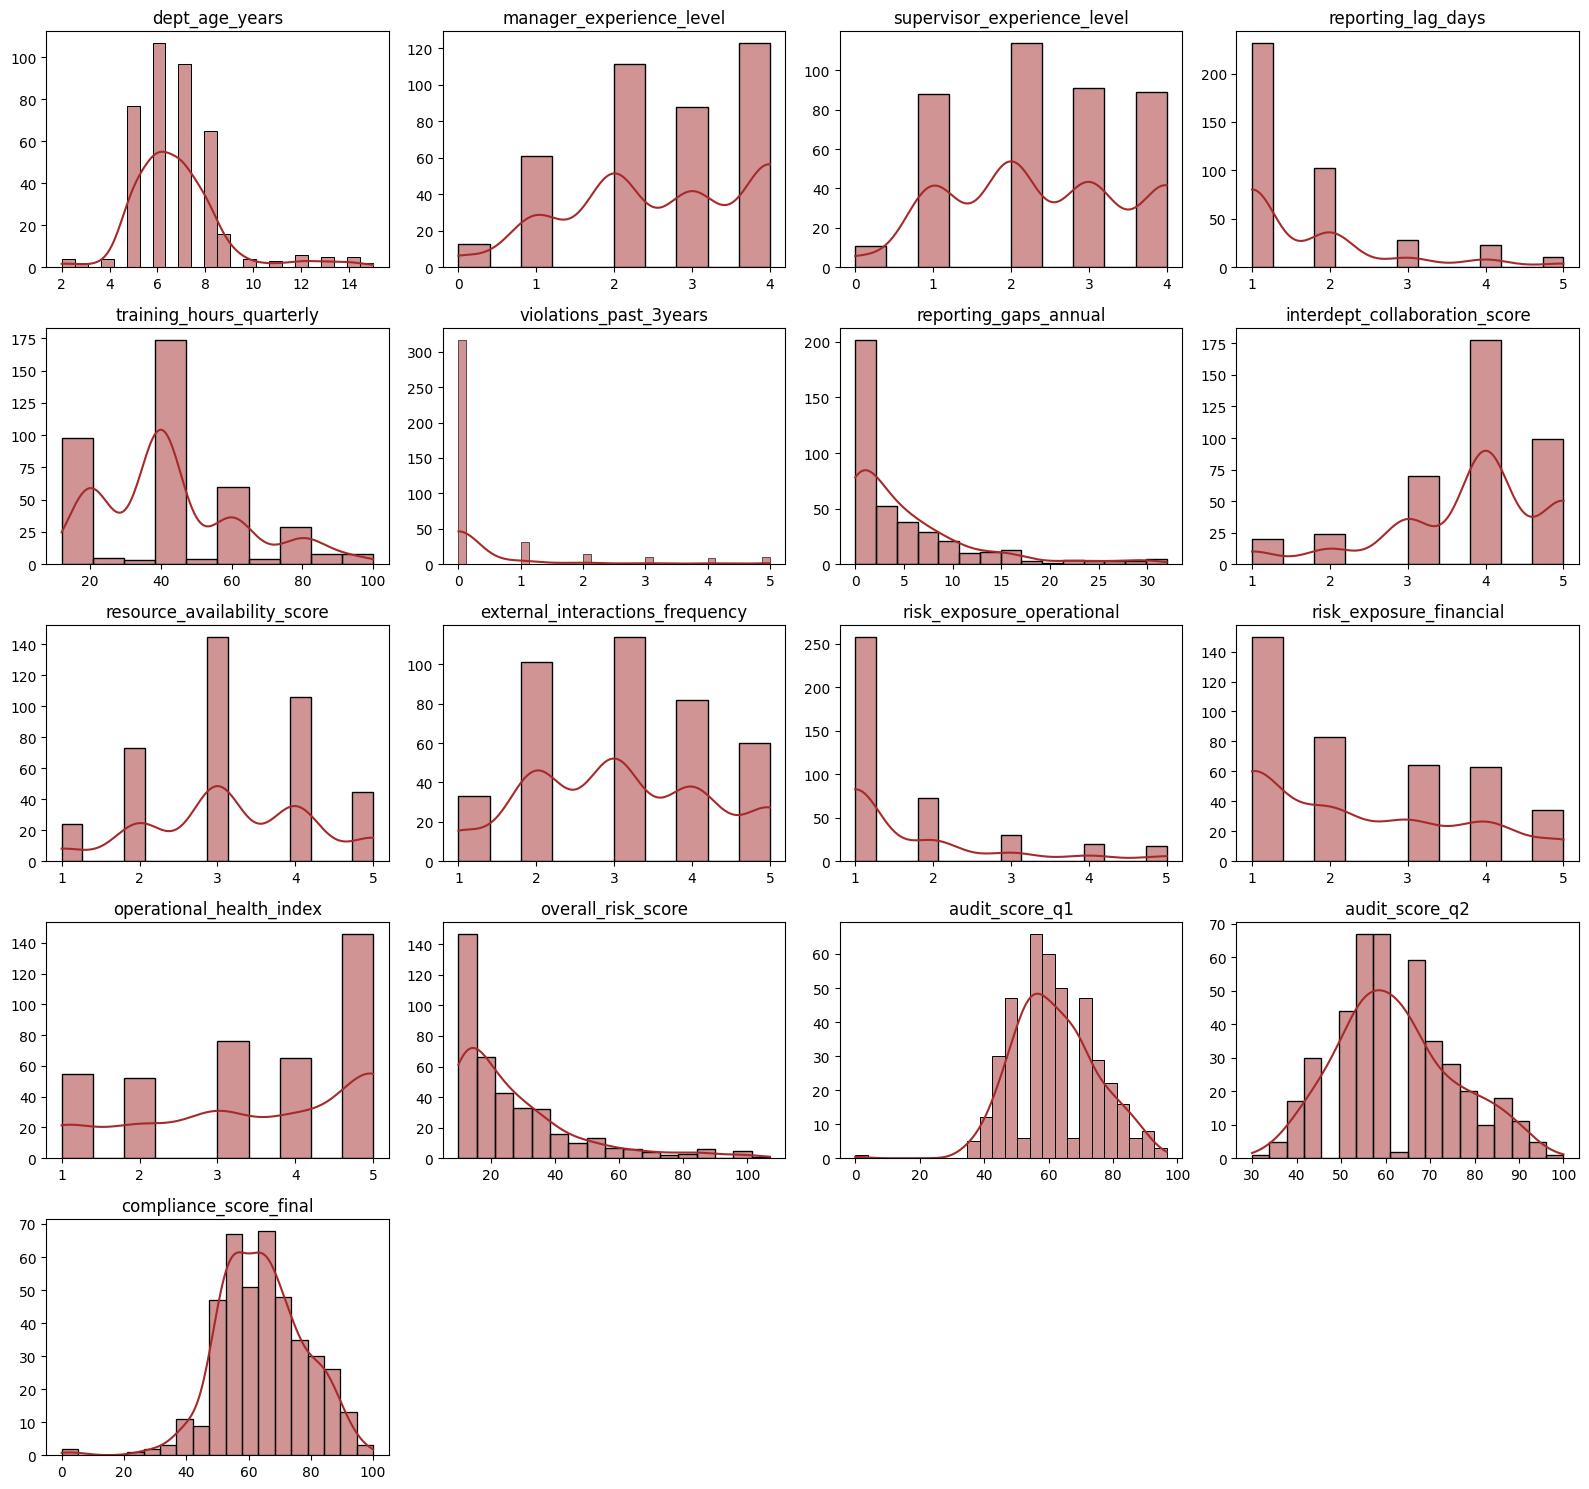

In [23]:
n_cols = 4  # number of plots per row
n_rows = math.ceil(len(numerical_cols) / n_cols)

plt.figure(figsize=(4 * n_cols, 3 * n_rows))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(departments[col].dropna(), kde=True, color='brown')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

---
There exist a few clear outliers we want to remove from the dataset:
- In audit_score_q1 a few observations are equal to 0 which is almost impossible -> these should be set to NaN.
- There is overall_risk_score > 100, which is very unlikely, so these should be also set to NaN.
- In the compliance_score_final, compliance for some observations was very close to 0, however, lies within the appropriate range [0,100]. Therefore, we can't remove these values. But they will be clearly interesting for the later analysis as extremely non compliant, so we should flag them.

For scale variables there are no continueous values.

However, before we set outliers to NaN, we should first explore these variables closer to prove the point.

---

**audit_score_q1**

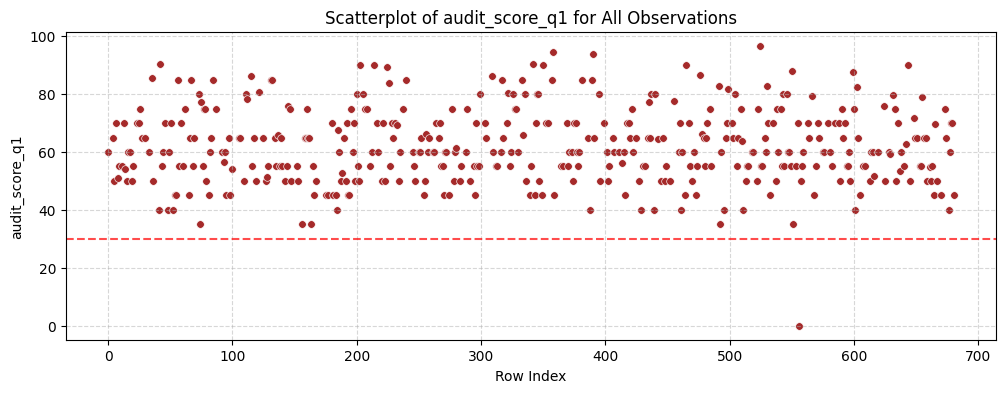

In [24]:
# Scatterplot of audit_score_q1
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['audit_score_q1'],
    color='brown',
    s=30
)

plt.xlabel("Row Index")
plt.ylabel("audit_score_q1")
plt.title("Scatterplot of audit_score_q1 for All Observations")
plt.axhline(30, color='red', linestyle='--', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Outlier confirmed and is clearly < 30. We set it to NaN.

---

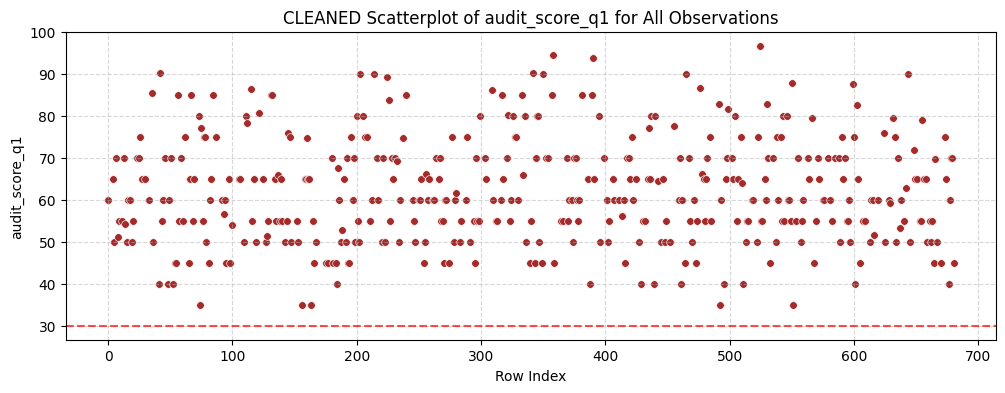

In [25]:
outlier_mask = departments['audit_score_q1'] < 30

departments.loc[outlier_mask, 'audit_score_q1'] = np.nan

# controll check
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['audit_score_q1'],
    color='brown',
    s=30
)

plt.xlabel("Row Index")
plt.ylabel("audit_score_q1")
plt.title("CLEANED Scatterplot of audit_score_q1 for All Observations")
plt.axhline(30, color='red', linestyle='--', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**overall_risk_score**

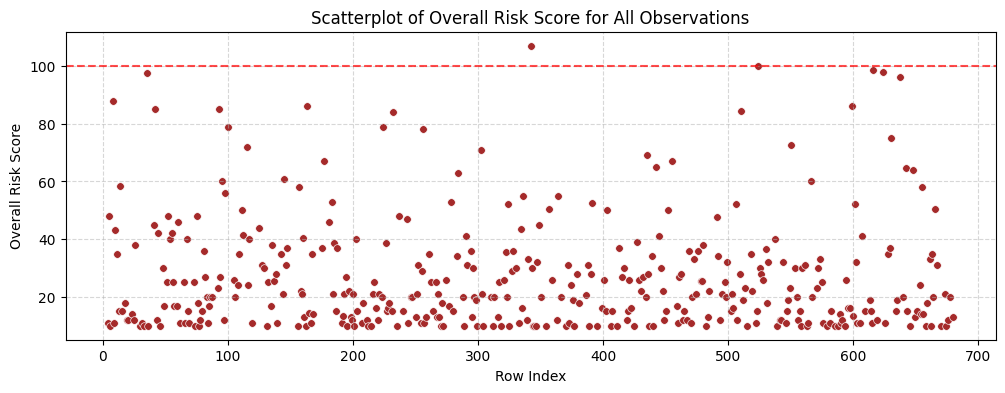

In [26]:
# Scatterplot of overall_risk_score
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['overall_risk_score'],
    color='brown',
    s=30
)

plt.xlabel("Row Index")
plt.ylabel("Overall Risk Score")
plt.title("Scatterplot of Overall Risk Score for All Observations")
plt.axhline(100, color='red', linestyle='--', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Outlier confirmed and is clearly > 100. We set it to NaN.

---

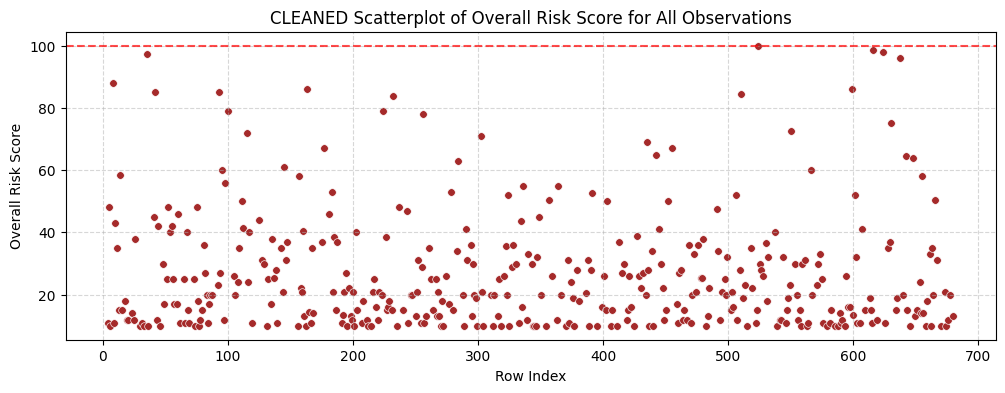

In [27]:
# Set extreme high values (>100) to NaN for overall_risk_score
departments.loc[departments['overall_risk_score'] > 100, 'overall_risk_score'] = np.nan
# controll check
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['overall_risk_score'],
    color='brown',
    s=30
)

plt.xlabel("Row Index")
plt.ylabel("Overall Risk Score")
plt.title("CLEANED Scatterplot of Overall Risk Score for All Observations")
plt.axhline(100, color='red', linestyle='--', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**compliance_score_final**

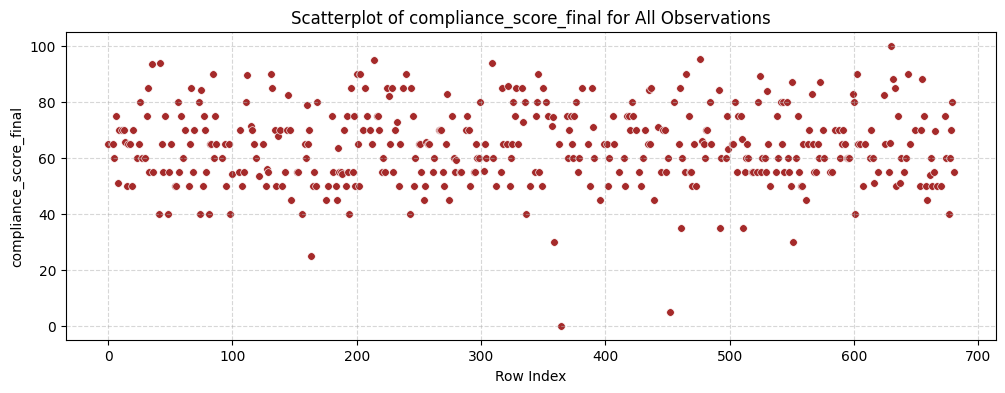

In [28]:
# Scatterplot of overall_risk_score
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index,
    y=departments['compliance_score_final'],
    color='brown',
    s=30  # marker size
)

plt.xlabel("Row Index")
plt.ylabel("compliance_score_final")
plt.title("Scatterplot of compliance_score_final for All Observations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Two values are clearly smaller than 20. We flag them.

---

In [29]:
# Flag extremely low compliance (<=20)
departments['extreme_non_compliance'] = (departments['compliance_score_final'] <= 20).astype(int)

#### **Boolean variables**

For boolean variables, twe check for continious variables.

---

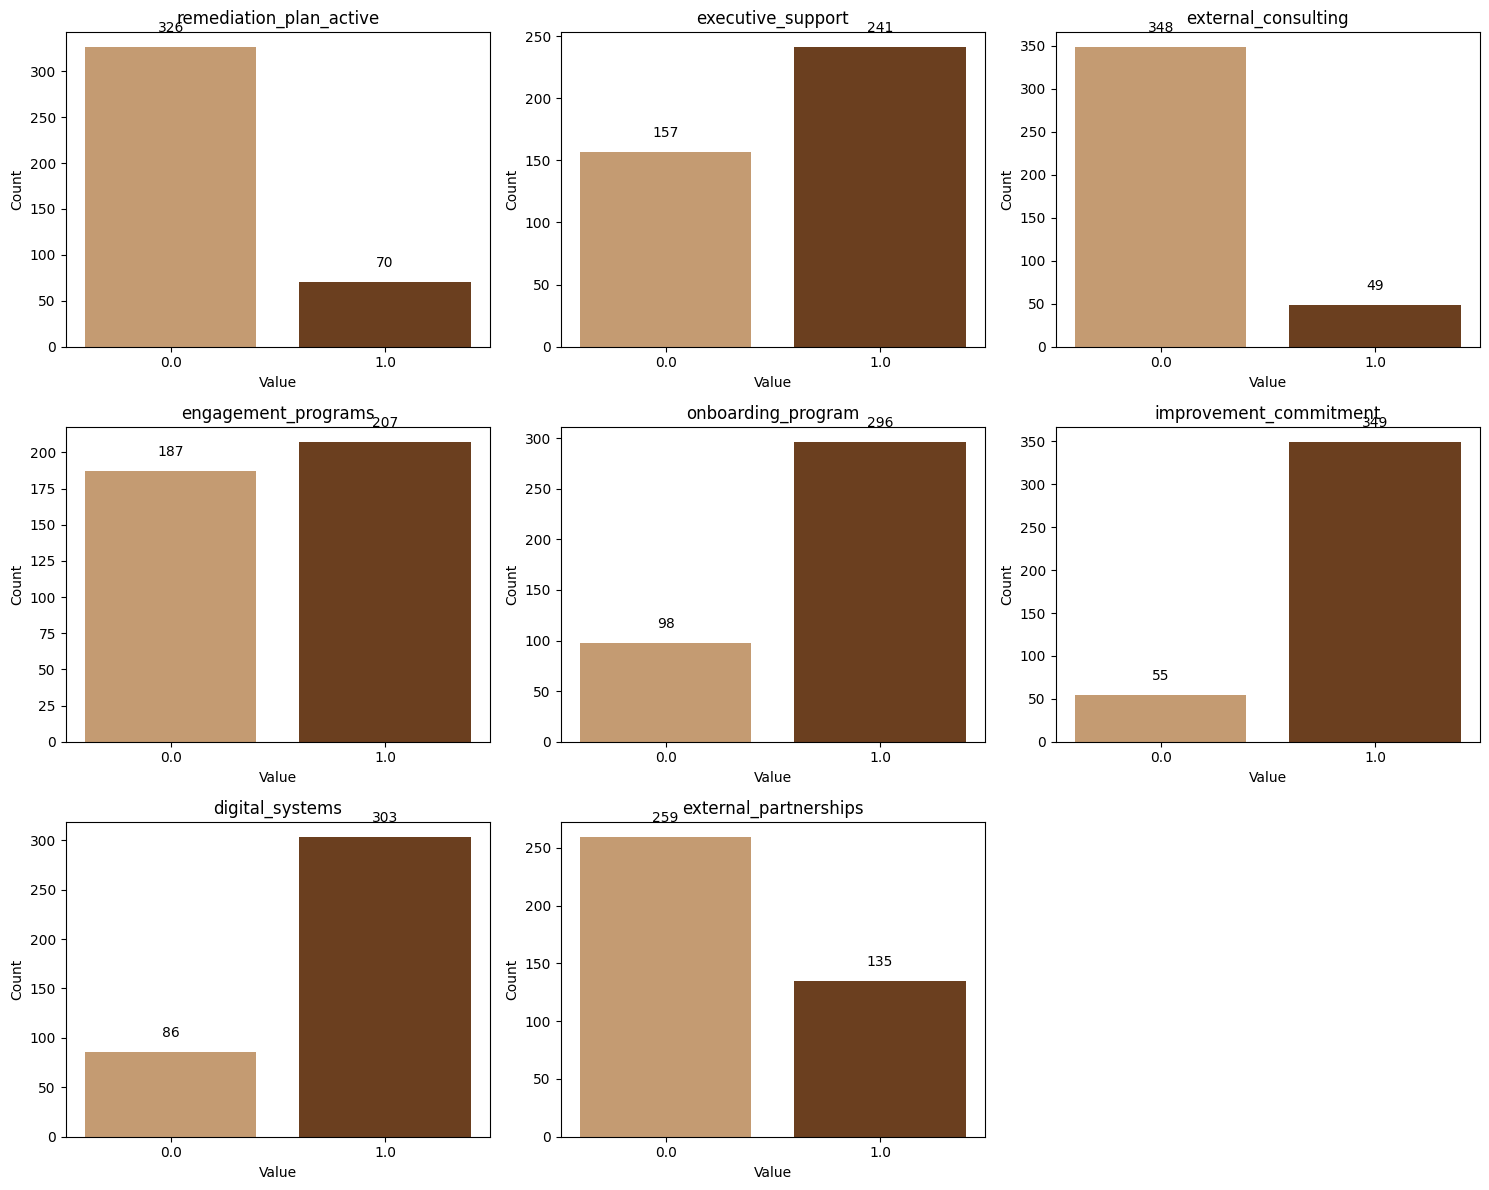

In [30]:
# List of boolean columns
bool_cols_for_outliers = [col for col in bool_cols]

# Figure layout
n_cols = 3
n_rows = (len(bool_cols_for_outliers) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # flatten in case of multiple rows

for i, col in enumerate(bool_cols_for_outliers):
    counts = departments[col].value_counts().sort_index()
    axes[i].bar(counts.index.astype(str), counts.values, color=["#c49b72", "#6b3f1f"])
    axes[i].set_title(col)
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("Value")
    for j, val in enumerate(counts.values):
        axes[i].text(j, val + 0.05 * max(counts.values), str(val), ha='center')

# Hide empty subplots
for i in range(len(bool_cols_for_outliers), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

---
For boolean variables there are no continueous values.

---

#### **Categorical columns**

For categorical variables, we check frequence outliers.

---

In [31]:
# Exclude dept_id
categorical_cols_no_id = [c for c in categorical_cols if c != "dept_id"]

cat_dist_list = []

for col in categorical_cols_no_id:
    counts = departments[col].value_counts()
    perc = departments[col].value_counts(normalize=True) * 100

    tmp = pd.DataFrame({
        "feature": col,
        "category": counts.index,
        "count": counts.values,
        "share_%": perc.round(1).values
    })

    cat_dist_list.append(tmp)

cat_distribution = pd.concat(cat_dist_list, ignore_index=True)

# Compact summary: how many categories + smallest / largest share for each feature
cat_summary = (
    cat_distribution
    .groupby("feature")
    .agg(
        n_categories=("category", "nunique"),
        min_share=("share_%", "min"),
        max_share=("share_%", "max"),
    )
    .round(1)
    .reset_index()
)

cat_summary


feature  n_categories  min_share  max_share
0        dept_category             3        3.5       58.9
1            dept_type             6        2.8       50.1
2             division             2        6.2       93.8
3        location_type             4        3.0       74.7
4       oversight_body             4        2.0       67.7
5     primary_function             7        2.5       34.5
6  reporting_structure             3        3.8       80.7
7            team_size             3        4.8       65.6

---
Even the smallest categories are not small enough to combine them with some other categories so we don't modify anything at this stage.

---

### **Summary statistics**

In [32]:
# Summary statistics for numerical_col
distribution_summary = departments[numerical_cols].describe().T  # transpose for readability

distribution_summary = distribution_summary.round(2)
distribution_summary

count   mean    std   min   25%   50%   75%  \
dept_age_years                   397.0   6.83   1.94   2.0   6.0   7.0   8.0   
manager_experience_level         396.0   2.62   1.17   0.0   2.0   3.0   4.0   
supervisor_experience_level      393.0   2.40   1.15   0.0   1.0   2.0   3.0   
reporting_lag_days               397.0   1.69   1.02   1.0   1.0   1.0   2.0   
training_hours_quarterly         393.0  43.26  19.79  12.0  21.0  40.0  60.0   
violations_past_3years           392.0   0.45   1.13   0.0   0.0   0.0   0.0   
reporting_gaps_annual            398.0   5.14   6.56   0.0   0.0   2.0   8.0   
interdept_collaboration_score    391.0   3.80   1.05   1.0   3.0   4.0   5.0   
resource_availability_score      393.0   3.19   1.06   1.0   3.0   3.0   4.0   
external_interactions_frequency  390.0   3.09   1.19   1.0   2.0   3.0   4.0   
risk_exposure_operational        399.0   1.66   1.10   1.0   1.0   1.0   2.0   
risk_exposure_financial          394.0   2.36   1.35   1.0   1.0   2.0   3.0   
operational_health_index         394.0   3.49   1.45   1.0   2.0   4.0   5.0   
overall_risk_score               393.0  26.69  18.91  10.0  12.0  20.0  34.0   
audit_score_q1                   413.0  62.10  12.63  35.0  55.0  60.0  70.0   
audit_score_q2                   420.0  62.36  13.35  30.0  55.0  60.0  70.0   
compliance_score_final           416.0  64.11  13.74   0.0  55.0  65.0  75.0   

                                   max  
dept_age_years                    15.0  
manager_experience_level           4.0  
supervisor_experience_level        4.0  
reporting_lag_days                 5.0  
training_hours_quarterly         100.0  
violations_past_3years             5.0  
reporting_gaps_annual             32.0  
interdept_collaboration_score      5.0  
resource_availability_score        5.0  
external_interactions_frequency    5.0  
risk_exposure_operational          5.0  
risk_exposure_financial            5.0  
operational_health_index           5.0  
overall_risk_score               100.0  
audit_score_q1                    96.7  
audit_score_q2                   100.0  
compliance_score_final           100.0

---
From this summary we derive three very important features:
- compliance_score_final ranges from 0 to 100, with the 25th percentile at 55. This means the bottom 25% of departments score 55 or lower — clearly below typical compliance levels. As we need to define non-compliance, we set non-compliance = compliance_score_final <= 55, focusing on the departments most at risk. **Low Compliance: 0 - 55, Moderate Compliance: 55–75, High Compliance: 75-100**.
- for overall_risk_score, we are most interested in finding very high scores rather than very low. Following the same logic as for the compliance_score_final, we obtain **Low Risk: 10 – 20** (up to median), **Moderate Risk: 21 – 34** (median to 75th percentile) which are departments that may need attention but are not immediately critical, **High Risk: 35 – 100** (above 75th percentile), which are departments likely to have compliance issues, operational exposure, or financial risks.

These classifications will be used further for modeling.

---

### **Logical Inconsistencies**

We have already checked in the Outliers check section that all values lay within the appropriate range. If they did not, we set them to NaN. Now we will check our dataset for the following logical inconsistency:
- Audit scores are absent, but compliance score exists.

---

In [33]:
is_final_score_missing = departments['compliance_score_final'].isna()

# Audits are present (i.e., EITHER Q1 score is NOT NaN OR Q2 score is NOT NaN)
is_audit_present = departments['audit_score_q1'].notna() | departments['audit_score_q2'].notna()

inconsistent_scores = departments[is_final_score_missing & is_audit_present]

print("--- Cross-Column Validation Check ---")
print(f"Number of inconsistencies (Final Score Missing BUT Audit Data Present): {len(inconsistent_scores)}")

if len(inconsistent_scores) > 0:
    print("Inconsistent Dept IDs (First 5):")
    # Using .head() to only show the first few IDs
    print(inconsistent_scores['dept_id'].head().tolist())

--- Cross-Column Validation Check ---
Number of inconsistencies (Final Score Missing BUT Audit Data Present): 22
Inconsistent Dept IDs (First 5):
['DEPT-1133', 'DEPT-1752', 'DEPT-2279', 'DEPT-2792', 'DEPT-2995']


---
We will check if any of these ids are part of the high_risk_departments table, and if they are, we cannot drop them, otherwise we will drop these rows.

---

In [34]:
# Check which inconsistent departments are considered high risk
inconsistent_scores_high_risk = inconsistent_scores[inconsistent_scores['present_in_high_risk_departments'] == 1]

print(f"Number of inconsistent departments flagged as high risk: {len(inconsistent_scores_high_risk)}")

if len(inconsistent_scores_high_risk) > 0:
    print("Dept IDs of inconsistent departments flagged as high risk:")
    display(inconsistent_scores_high_risk['dept_id'])
else:
    print("No inconsistent departments are flagged as high risk.")

Number of inconsistent departments flagged as high risk: 8
Dept IDs of inconsistent departments flagged as high risk:


10     DEPT-1133
52     DEPT-1752
93     DEPT-2279
157    DEPT-2995
342    DEPT-5329
377    DEPT-5849
535    DEPT-8087
648    DEPT-9653
Name: dept_id, dtype: object

---
Here we can see that we have 8 of these ID's which are added in the high_risk_departemnts table, so we will flag the 8 and drop the rest 14

---

In [35]:
# Flag the 8 inconsistent departments that are in high_risk_departments
departments['audit_scores_missing'] = 0
departments.loc[inconsistent_scores_high_risk.index, 'audit_scores_missing'] = 1

# Drop the remaining inconsistent rows that are NOT in high_risk_departments
to_drop = inconsistent_scores.index.difference(inconsistent_scores_high_risk.index)
departments.drop(index=to_drop, inplace=True)

# Reset index
departments.reset_index(drop=True, inplace=True)

# Quick check
print(f"Remaining inconsistent rows: {(departments['compliance_score_final'].isna() &
                                        (departments['audit_score_q1'].notna() |
                                         departments['audit_score_q2'].notna())).sum()}")
print("Flagged audit_scores_missing:")
display(departments[departments['audit_scores_missing'] == 1]['dept_id'])

Remaining inconsistent rows: 8
Flagged audit_scores_missing:


10     DEPT-1133
52     DEPT-1752
93     DEPT-2279
156    DEPT-2995
337    DEPT-5329
371    DEPT-5849
524    DEPT-8087
635    DEPT-9653
Name: dept_id, dtype: object

### **Missing Values**

#### **Overview**

In [36]:
# Count missing values per column
missing_counts = departments.isnull().sum()
missing_percent = (missing_counts / len(departments) * 100).round(2)

missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
}).sort_values(by='missing_percent', ascending=False)

display(missing_summary)

missing_count  missing_percent
external_interactions_frequency             292            43.71
digital_systems                             291            43.56
interdept_collaboration_score               290            43.41
overall_risk_score                          289            43.26
oversight_body                              288            43.11
engagement_programs                         288            43.11
violations_past_3years                      288            43.11
resource_availability_score                 288            43.11
risk_exposure_financial                     287            42.96
training_hours_quarterly                    287            42.96
operational_health_index                    287            42.96
external_partnerships                       287            42.96
supervisor_experience_level                 287            42.96
onboarding_program                          287            42.96
team_size                                   286            42.81
remediation_plan_active                     285            42.66
location_type                               285            42.66
external_consulting                         285            42.66
dept_type                                   284            42.51
reporting_gaps_annual                       284            42.51
manager_experience_level                    284            42.51
reporting_lag_days                          284            42.51
executive_support                           283            42.37
reporting_structure                         283            42.37
dept_age_years                              283            42.37
risk_exposure_operational                   281            42.07
primary_function                            279            41.77
improvement_commitment                      276            41.32
audit_score_q1                              269            40.27
audit_score_q2                              261            39.07
compliance_score_final                      252            37.72
division                                    244            36.53
dept_id                                       0             0.00
dept_category                                 0             0.00
present_in_high_risk_departments              0             0.00
extreme_non_compliance                        0             0.00
audit_scores_missing                          0             0.00

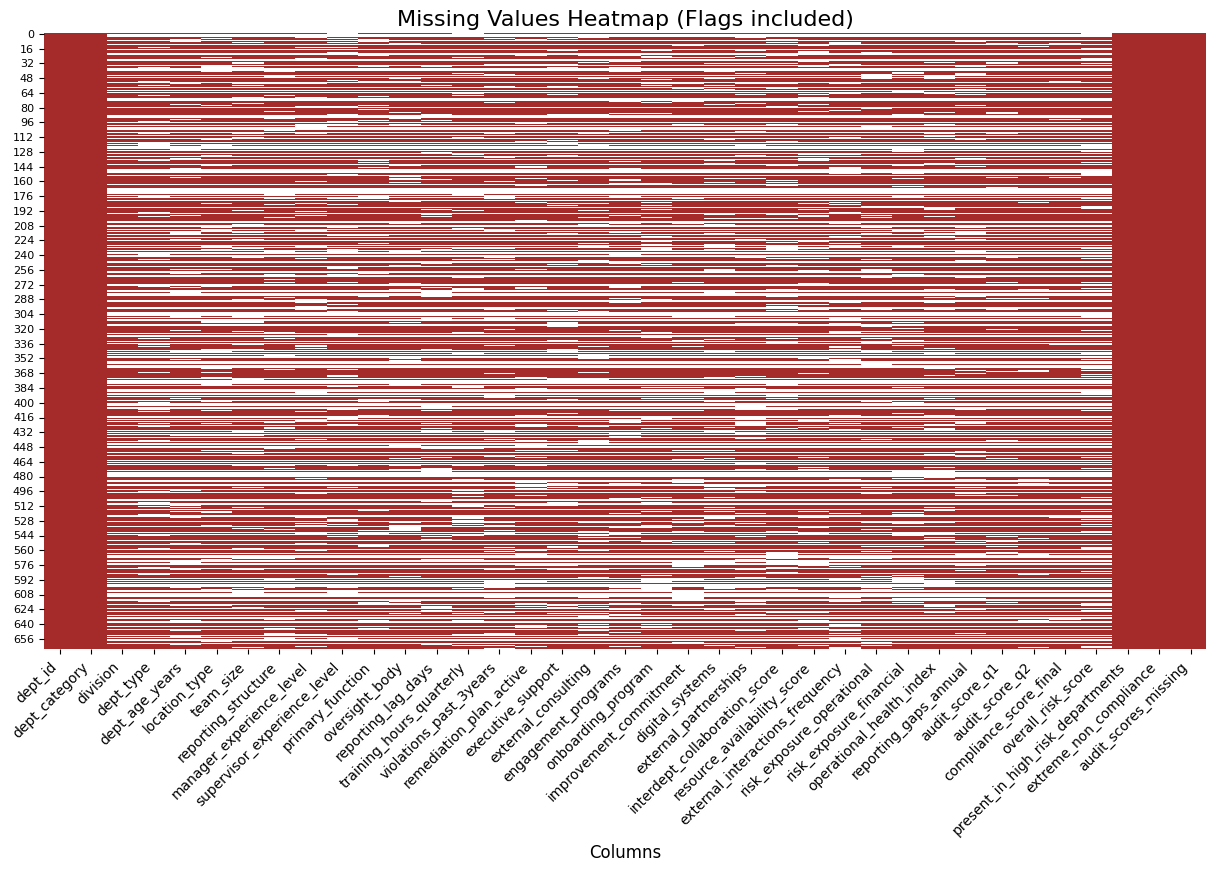

In [37]:
plt.figure(figsize=(15,8))

sns.heatmap(
    departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)

plt.title('Missing Values Heatmap (Flags included)', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

---
In `departments` there is substantial missing data in the dataset (around 36–43% per column).

However, our key categorical identifier variables — dept_id, and dept_category — contain no missing values.

Because these columns are complete, we can reliably group the dataset by these identifiers to examine whether the missingness in other variables is associated with specific departments or department categories to see if missing data is random or systematically related to certain groups of observations.

---

#### **Missingness by dept_category**

In [38]:
#columns to exclude
analytic_cols = departments.columns.difference(['dept_id', 'dept_category', 'present_in_high_risk_departments', 'extreme_non_compliance', 'audit_scores_missing' ])

missing_by_category = departments.groupby('dept_category')[analytic_cols].apply(
    lambda x: x.isnull().sum(),
    include_groups=False
)
display(missing_by_category)

grouped = departments.groupby('dept_category', dropna=False)
total_cells = grouped.size() * departments.shape[1]
missing_cells = grouped[analytic_cols].apply(lambda g: g.isna().sum().sum(), include_groups=False)
missing_rate = (missing_cells / total_cells) * 100

print("--- Overall Data Integrity Rate by Category ---")
print(missing_rate.round(2))

audit_score_q1  audit_score_q2  \
dept_category                                            
Financial_Reporting                 21              15   
Operational_Compliance             246             244   
Risk_Management                      2               2   

                        compliance_score_final  dept_age_years  dept_type  \
dept_category                                                               
Financial_Reporting                          3              34         35   
Operational_Compliance                     245             244        245   
Risk_Management                              4               5          4   

                        digital_systems  division  engagement_programs  \
dept_category                                                            
Financial_Reporting                  41         0                   40   
Operational_Compliance              245       244                  247   
Risk_Management                       5         0                    1   

                        executive_support  external_consulting  ...  \
dept_category                                                   ...   
Financial_Reporting                    38                   39  ...   
Operational_Compliance                244                  244  ...   
Risk_Management                         1                    2  ...   

                        reporting_gaps_annual  reporting_lag_days  \
dept_category                                                       
Financial_Reporting                        37                  39   
Operational_Compliance                    245                 244   
Risk_Management                             2                   1   

                        reporting_structure  resource_availability_score  \
dept_category                                                              
Financial_Reporting                      37                           39   
Operational_Compliance                  245                          245   
Risk_Management                           1                            4   

                        risk_exposure_financial  risk_exposure_operational  \
dept_category                                                                
Financial_Reporting                          37                         32   
Operational_Compliance                      245                        246   
Risk_Management                               5                          3   

                        supervisor_experience_level  team_size  \
dept_category                                                    
Financial_Reporting                              42         38   
Operational_Compliance                          244        246   
Risk_Management                                   1          2   

                        training_hours_quarterly  violations_past_3years  
dept_category                                                             
Financial_Reporting                           39                      42  
Operational_Compliance                       245                     245  
Risk_Management                                3                       1  

[3 rows x 32 columns]

--- Overall Data Integrity Rate by Category ---
dept_category
Financial_Reporting        7.74
Operational_Compliance    82.74
Risk_Management            8.56
dtype: float64


---
**Here we see a pattern:** most data is missing for 'Operational_Compliance'. Then data is almost equally missing for 'Financial_Reporting' and 'Risk_Management' category. These are the categories of rules that departments have to deal with. Therefore, when departments deal with 'Operational_Compliance' rules, the data becomes missing. Why? What is the correlation between the data being missing and this type of rules?

We will find the answer later in the next section.

---

#### **Missingness by division**

'division' has the least percent of missing values (37%) out of all columns with missing values, therefore, we can check the missingness by division too.

---

In [39]:
# Columns to exclude
analytic_cols = departments.columns.difference(['dept_id', 'dept_category', 'present_in_high_risk_departments', 'extreme_non_compliance', 'audit_scores_missing' ])

missing_by_division = departments.groupby('division')[analytic_cols].apply(lambda x: x.isna().sum())
display(missing_by_division)
grouped_data = departments.groupby('division', dropna=False)
total_cells_per_division = grouped_data.size() * len(analytic_cols)
total_missing_per_division = grouped_data[analytic_cols].apply(lambda x: x.isna().sum().sum())

# Missing rate per division (%)
overall_missing_rate = (total_missing_per_division / total_cells_per_division) * 100

print("--- Overall Data Integrity Rate by Division  ---")
final_rates = overall_missing_rate.round(2)
display(final_rates)

audit_score_q1  audit_score_q2  compliance_score_final  \
division                                                                      
Corporate_HQ                     22              14                       6   
Regional_Operations               3               3                       2   

                     dept_age_years  dept_type  digital_systems  division  \
division                                                                    
Corporate_HQ                     35         36               43         0   
Regional_Operations               4          4                4         0   

                     engagement_programs  executive_support  \
division                                                      
Corporate_HQ                          43                 39   
Regional_Operations                    1                  0   

                     external_consulting  ...  reporting_gaps_annual  \
division                                  ...                          
Corporate_HQ                          39  ...                     36   
Regional_Operations                    2  ...                      4   

                     reporting_lag_days  reporting_structure  \
division                                                       
Corporate_HQ                         39                   35   
Regional_Operations                   1                    4   

                     resource_availability_score  risk_exposure_financial  \
division                                                                    
Corporate_HQ                                  41                       38   
Regional_Operations                            3                        5   

                     risk_exposure_operational  supervisor_experience_level  \
division                                                                      
Corporate_HQ                                34                           41   
Regional_Operations                          3                            2   

                     team_size  training_hours_quarterly  \
division                                                   
Corporate_HQ                40                        41   
Regional_Operations          2                         2   

                     violations_past_3years  
division                                     
Corporate_HQ                             41  
Regional_Operations                       3  

[2 rows x 32 columns]

--- Overall Data Integrity Rate by Division  ---


division
Corporate_HQ             8.90
Regional_Operations      9.86
NaN                    100.00
dtype: float64

---
Here we see another pattern: 'Corporate_HQ' division, according to the first table, misses far more values than Regional_Operations. However, it is an illusion arising from the fact that a lot of departments (428) belong to the Corpoprate_HQ and only 27 departments belong to the Regional Operations division (from divisions table). In fact, the percentage of missing values in these two divisions is almost the same (around 9%).

What's more interesting, the missing division information (NaN) has an extremely high percent of missing data (100%). This is the strong proof that if the division information is missing -> everything else (exept for the 'dept_id', 'dept_category') is missing. Therefore, these rows, where division is missing, are useless:
- non-usable for modeling
- non-recoverable (too much missing data)

Therefore, we shoul drop them. But before, we want to find out another interesting detail: do all missing rows belong to the Operational_Compliance category?

---

In [40]:
# Rows where division is missing
missing_division_rows = departments[departments['division'].isna()]

total_missing_division = missing_division_rows.shape[0]

# Number of rows with missing division that belong to Operational_Compliance
missing_div_opcompliance = (missing_division_rows['dept_category'] == 'Operational_Compliance').sum()

print(f"Total rows with missing division: {total_missing_division}")
print(f"Rows with missing division and category 'Operational_Compliance': {missing_div_opcompliance}")

Total rows with missing division: 244
Rows with missing division and category 'Operational_Compliance': 244


---
The hypothesis is confirmed: there is a perfect overlap: **missing division -> missing data -> Operational_Compliance** category.

But are there any departments which deal with Operational_Compliance rules which actually submitted their data?

---

In [41]:
# Exclude the constant columns
exclude_cols = ['dept_id', 'dept_category', 'division']
analytic_cols = departments.columns.difference(exclude_cols)

# Mask for Operational_Compliance category
mask_op_compliance = departments['dept_category'] == 'Operational_Compliance'

# Check rows with AT LEAST ONE non-missing value in analytical columns
op_compliance_not_missing = departments.loc[mask_op_compliance, analytic_cols].dropna(how='all')

print(f"Number of Operational_Compliance rows with at least some data: {op_compliance_not_missing.shape[0]}")

Number of Operational_Compliance rows with at least some data: 256


---
Yes, there are 12 such departments. So the question now is: Why did these 12 departments manage to submit their data while the others did not?

Unfortunately, we cannot answer this question with the current dataset. Even if we analyze these 12 departments, we cannot compare them to the departments with missing values, because all the analytical columns are missing for the others. Only the dept_id ispresent, but this does not provide any meaningful information for analysis.

We have the last thing to check before we drop these departments with missing values: Does any of them belong to the table 'high_risk_departments'? This is meaningful, because the table 'high_risk_departments' shows departments already marked as risky and if any of the departments that we are going to drop will appear in this table, we can lose an important detail in analysing what makes departments risky. Maybe lack of values makes departments risky - we don't know yet.

---

In [42]:
# Select departments with missing division
missing_division_rows = departments[departments['division'].isna()]

# Find which of these departments are in high_risk_departments
matching_high_risk = high_risk_departments[
    high_risk_departments['dept_id'].isin(missing_division_rows['dept_id'])
]

# Display the departments as they are in the departments table
if not matching_high_risk.empty:
    print("Departments with missing division in the departments table:")
    display(missing_division_rows[
        missing_division_rows['dept_id'].isin(matching_high_risk['dept_id'])
    ])

    print("Same departments in the high_risk_departments table:")
    display(matching_high_risk)
else:
    print("No departments with missing division are in high_risk_departments.")

Departments with missing division in the departments table:


dept_id           dept_category division dept_type  dept_age_years  \
102  DEPT-2377  Operational_Compliance     None      None             NaN   
315  DEPT-5023  Operational_Compliance     None      None             NaN   

    location_type team_size reporting_structure  manager_experience_level  \
102          None      None                None                       NaN   
315          None      None                None                       NaN   

     supervisor_experience_level  ... risk_exposure_financial  \
102                          NaN  ...                     NaN   
315                          NaN  ...                     NaN   

    operational_health_index  reporting_gaps_annual  audit_score_q1  \
102                      NaN                    NaN             NaN   
315                      NaN                    NaN             NaN   

     audit_score_q2  compliance_score_final  overall_risk_score  \
102             NaN                     NaN                 NaN   
315             NaN                     NaN                 NaN   

     present_in_high_risk_departments  extreme_non_compliance  \
102                                 1                       0   
315                                 1                       0   

     audit_scores_missing  
102                     0  
315                     0  

[2 rows x 37 columns]

Same departments in the high_risk_departments table:


dept_id        dept_category      division dept_type  dept_age_years  \
50  DEPT-5023  Financial_Reporting  Corporate_HQ   Support             6.0   
58  DEPT-2377  Financial_Reporting  Corporate_HQ      None             NaN   

   location_type team_size reporting_structure  manager_experience_level  \
50         Urban     Large         Centralized                       1.0   
58         Urban     Small          Autonomous                       4.0   

    supervisor_experience_level  ... resource_availability_score  \
50                          1.0  ...                         5.0   
58                          4.0  ...                         1.0   

   external_interactions_frequency  risk_exposure_operational  \
50                             5.0                        5.0   
58                             3.0                        3.0   

    risk_exposure_financial  operational_health_index  reporting_gaps_annual  \
50                      5.0                       5.0                    0.0   
58                      5.0                       5.0                    6.0   

    audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  
50            50.0            50.0                    80.0                50.0  
58            45.0            45.0                    50.0                43.0  

[2 rows x 34 columns]

---
This comparison provided us with a great insight:

We can drop the rows with missing division information AND even those present in the high_risk_departments. Why? Because of the following reasoning:

1. Do all departments with missing values appear in the high_risk_departments? - No. So having all missing values is not equal to being risky.
2. Do missing overall_risk_score AND compliance_score_final make a department risky? - No (from conclusion 1).
3. Did these departments appear as risky because of the manual imputation? - Yes. So we initially didn't know anything about these departments and we know that the full missing data does not make a department risky. Therefore, all values for these departments were imputed with values that MADE them risky -> they appear as risky by accident.
4. Therefore, we should drop all departments with missing division.

To make sure that data missingness is not correlated with risk, we check correlation between missing values and compliance or risk

---

#### **Correlation between missing values and compliance or risk**

---
> The last thing about missing values we need to find before moving on to handling them: Is there any correlation between the missing values and the compliance or risk? Because if there is, then something about the missing data can affect the compliance or risk and we want to know what before handling missing values. Perhaps the number of missing values negatively correlates with the compliance and positively correlates with risk.
>
---

In [43]:
# Fraction of missing values per row
row_missing_rate = departments[analytic_cols].isna().mean(axis=1)

compliance_col = 'compliance_score_final'
risk_col = 'overall_risk_score'

correlation_compliance = row_missing_rate.corr(departments[compliance_col])
correlation_risk = row_missing_rate.corr(departments[risk_col])

print(f"Correlation between missingness and compliance_score:final: {correlation_compliance:.3f}")
print(f"Correlation between missingness and overall_risk_score: {correlation_risk:.3f}")

Correlation between missingness and compliance_score:final: 0.035
Correlation between missingness and overall_risk_score: 0.019


---
Correlation with compliance (0.35) → very low, meaning the amount of missing data does not systematically affect compliance scores.


Correlation with risk (0.019) → essentially zero, so missing data is not predictive of risk either.

In other words, based on this dataset:

Departments with more missing values are not inherently riskier.
Missingness seems to be mostly structural (like Operational_Compliance departments not submitting data), not related to the outcome variables.

Therefore, we should drop all rows with missing division.

---

In [44]:
# Identify department IDs with missing division
missing_div_dept_ids = departments.loc[departments['division'].isna(), 'dept_id']

# Drop from departments
departments = departments[~departments['dept_id'].isin(missing_div_dept_ids)].copy()

# Drop from high_risk_departments
high_risk_clean = high_risk_departments[
    ~high_risk_departments['dept_id'].isin(missing_div_dept_ids)
].copy()

print(f"Dropped {len(missing_div_dept_ids)} departments with missing division.")

Dropped 244 departments with missing division.


In [45]:
departments.shape

(424, 37)

In [46]:
high_risk_departments.shape

(200, 34)

#### **high_risk_departments** table

---
So far we analysed missing values in the `departments` table. Now we can look at two other improtant tables: `high_risk_departments` and `risk_summary_by_departments`

---

In [47]:
num_rows, num_columns = high_risk_departments.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")
high_risk_departments.head()

Number of rows: 200
Number of columns: 34


dept_id        dept_category      division   dept_type  dept_age_years  \
0  DEPT-1133  Financial_Reporting  Corporate_HQ  Compliance             8.0   
1  DEPT-4312  Financial_Reporting  Corporate_HQ  Operations             6.0   
2  DEPT-3347  Financial_Reporting  Corporate_HQ  Operations             6.0   
3  DEPT-2554  Financial_Reporting  Corporate_HQ     Support             5.0   
4  DEPT-3151  Financial_Reporting  Corporate_HQ        None             8.0   

  location_type team_size reporting_structure  manager_experience_level  \
0         Urban     Large         Centralized                       2.0   
1         Urban     Small         Centralized                       1.0   
2         Urban     Small         Centralized                       2.0   
3         Urban     Small          Autonomous                       3.0   
4         Urban     Small         Centralized                       3.0   

   supervisor_experience_level  ... resource_availability_score  \
0                          2.0  ...                         4.0   
1                          NaN  ...                         4.0   
2                          1.0  ...                         4.0   
3                          3.0  ...                         3.0   
4                          3.0  ...                         2.0   

  external_interactions_frequency  risk_exposure_operational  \
0                             NaN                        2.0   
1                             2.0                        1.0   
2                             4.0                        3.0   
3                             4.0                        4.0   
4                             4.0                        NaN   

   risk_exposure_financial  operational_health_index  reporting_gaps_annual  \
0                      2.0                       1.0                   26.0   
1                      1.0                       5.0                    2.0   
2                      5.0                       5.0                    6.0   
3                      4.0                       1.0                    0.0   
4                      4.0                       4.0                   10.0   

   audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  
0             NaN            40.0                     NaN                43.0  
1            45.0            45.0                    45.0                11.0  
2            45.0            50.0                    50.0                53.0  
3            65.0            60.0                    65.0                40.0  
4            50.0            50.0                    50.0                35.0  

[5 rows x 34 columns]

In [48]:
# Missing values per column
missing_high_risk = high_risk_departments.isna().sum()

# Missing percentage
missing_high_risk_percent = (missing_high_risk / high_risk_departments.shape[0]) * 100

# Create DataFrame
missing_df = pd.DataFrame({
    'missing_count': missing_high_risk,
    'missing_percent': missing_high_risk_percent
}).sort_values('missing_percent', ascending=False)

display(missing_df)

missing_count  missing_percent
violations_past_3years                      28             14.0
dept_age_years                              28             14.0
oversight_body                              25             12.5
digital_systems                             23             11.5
onboarding_program                          22             11.0
external_interactions_frequency             22             11.0
team_size                                   22             11.0
training_hours_quarterly                    21             10.5
interdept_collaboration_score               21             10.5
manager_experience_level                    21             10.5
location_type                               21             10.5
dept_type                                   21             10.5
reporting_structure                         20             10.0
reporting_lag_days                          20             10.0
overall_risk_score                          20             10.0
engagement_programs                         20             10.0
supervisor_experience_level                 19              9.5
remediation_plan_active                     19              9.5
risk_exposure_operational                   18              9.0
operational_health_index                    18              9.0
risk_exposure_financial                     17              8.5
executive_support                           17              8.5
resource_availability_score                 16              8.0
external_consulting                         16              8.0
primary_function                            16              8.0
external_partnerships                       15              7.5
reporting_gaps_annual                       14              7.0
improvement_commitment                      12              6.0
audit_score_q1                              11              5.5
audit_score_q2                               8              4.0
compliance_score_final                       7              3.5
dept_id                                      0              0.0
dept_category                                0              0.0
division                                     0              0.0

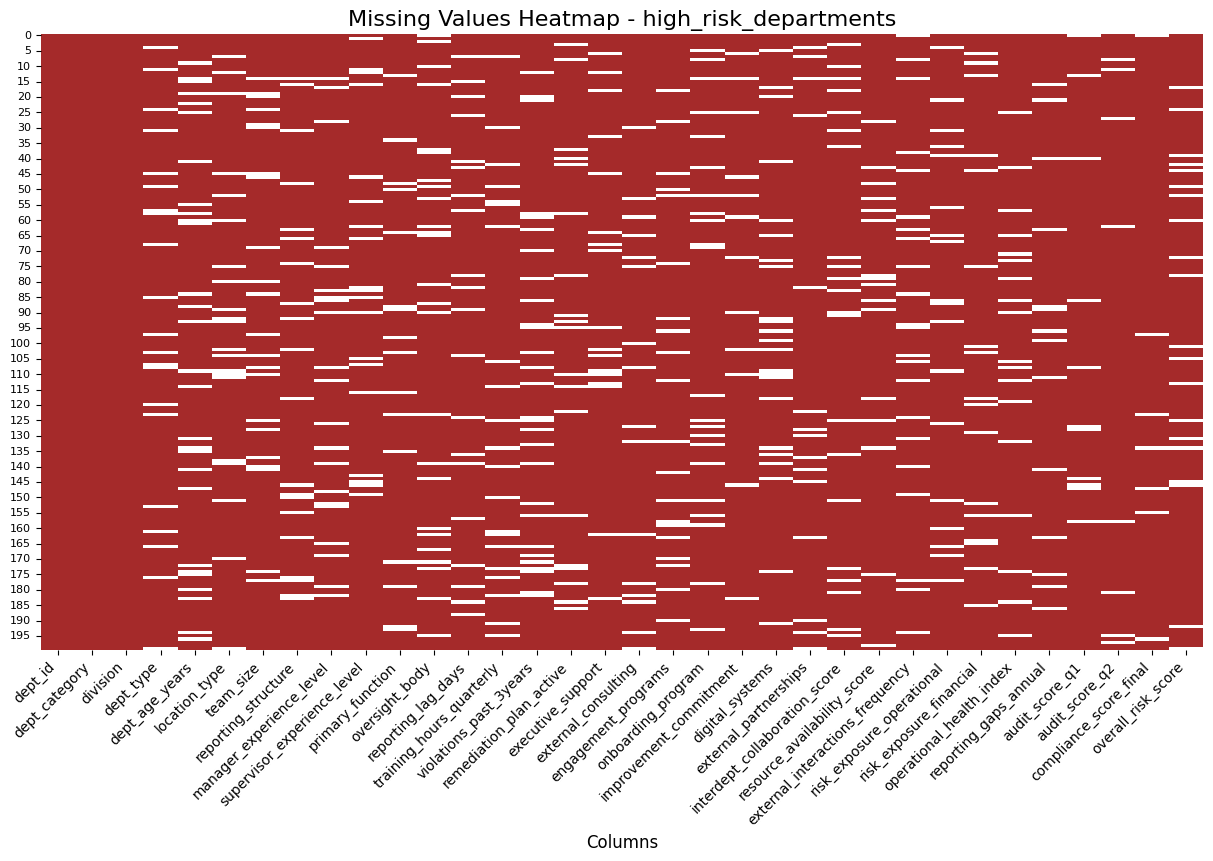

In [49]:
plt.figure(figsize=(15, 8))
sns.heatmap(
    high_risk_departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)
plt.title(f'Missing Values Heatmap - high_risk_departments', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

---
This table was already cleaned, there is much less missing data (around 10-14%).

---

### **Handling missing data**

Now we are going to compare two potential imputation procedures:

**Procedure 1**: We impute missing values in departments table with those present in high_risk_departments table. Other missing values we impute with median (numerical) and mode (categorical + boolean). The same method we apply to the high_risk_departments. Compare how similar the rows in high_risk_departments are to those in departments.

**Procedure 2**: We impute missing values with median (numerical) and mode (categorical + boolean) in both tables and compare how similar the rows in high_risk_departments are to those in departments.

To compare Procedures:

1. Compute statistics from the risk_summary_by_division table for both methods and see which keeps the original data patterns.
2. Look at numerical values distribution. Compare with the original table. Adopt the procedure that better keeps original data patterns.


---

In [50]:
# creating copies of departments and high_risk_departments tables
departments_copy_for_missing_imputation_1 = departments.copy()
high_risk_copy_for_missing_imputation_1 = high_risk_departments.copy()
departments_copy_for_missing_imputation_2 = departments.copy()
high_risk_copy_for_missing_imputation_2 = high_risk_departments.copy()

In [51]:
# Columns to exclude from imputation
exclude_cols = ['dept_id', 'present_in_high_risk_departments', 'extreme_non_compliance', 'audit_scores_missing']

# Identify numerical and categorical columns
numerical_cols_copy = [c for c in numerical_cols if c not in exclude_cols] + bool_cols
categorical_cols_copy = [c for c in categorical_cols if c not in exclude_cols + ['dept_id']]

In [52]:
# -----------------------------
# Procedure 1: Impute using high-risk reference
# -----------------------------

# Step 1: Impute departments_copy_for_missing_imputation_1 from high_risk_copy_for_missing_imputation_1
for idx, row in departments_copy_for_missing_imputation_1.iterrows():
    dept_id = row['dept_id']
    if dept_id in high_risk_copy_for_missing_imputation_1['dept_id'].values:
        hr_row = high_risk_copy_for_missing_imputation_1.loc[
            high_risk_copy_for_missing_imputation_1['dept_id'] == dept_id
        ].iloc[0]
        for col in numerical_cols_copy + categorical_cols_copy:
            if pd.isna(row[col]) and not pd.isna(hr_row[col]):
                departments_copy_for_missing_imputation_1.loc[idx, col] = hr_row[col]  # use .loc

# Step 2: Fill remaining missing values with median/mode
# Numerical → median
for col in numerical_cols_copy:
    median_val = departments_copy_for_missing_imputation_1[col].median()
    departments_copy_for_missing_imputation_1[col] = departments_copy_for_missing_imputation_1[col].fillna(median_val)
    high_risk_copy_for_missing_imputation_1[col] = high_risk_copy_for_missing_imputation_1[col].fillna(median_val)

# Categorical/Boolean → mode
for col in categorical_cols_copy:
    mode_val = departments_copy_for_missing_imputation_1[col].mode()[0]
    departments_copy_for_missing_imputation_1[col] = departments_copy_for_missing_imputation_1[col].fillna(mode_val)
    high_risk_copy_for_missing_imputation_1[col] = high_risk_copy_for_missing_imputation_1[col].fillna(mode_val)

# -----------------------------
# Step 3: Compare similarity
# -----------------------------
def row_similarity(row1, row2, cols):
    matches = sum(row1[c] == row2[c] for c in cols)
    return matches / len(cols) * 100

similarities = []
for idx, hr_row in high_risk_copy_for_missing_imputation_1.iterrows():
    dept_id = hr_row['dept_id']
    if dept_id in departments_copy_for_missing_imputation_1['dept_id'].values:
        dep_row = departments_copy_for_missing_imputation_1.loc[
            departments_copy_for_missing_imputation_1['dept_id'] == dept_id
        ].iloc[0]
        sim = row_similarity(hr_row, dep_row, numerical_cols_copy + categorical_cols_copy)
        similarities.append({'dept_id': dept_id, 'similarity_percent': sim})

similarity_df_1 = pd.DataFrame(similarities).sort_values(by='similarity_percent', ascending=False)
similarity_df_1.head(2)

dept_id  similarity_percent
0  DEPT-1133               100.0
1  DEPT-4312               100.0

In [53]:
# -----------------------------
# Procedure 2: Impute using median/mode only
# -----------------------------

# Step 1: Fill missing values with median/mode in both tables

# Numerical → median
for col in numerical_cols_copy:
    median_val = departments_copy_for_missing_imputation_2[col].median()
    departments_copy_for_missing_imputation_2[col] = departments_copy_for_missing_imputation_2[col].fillna(median_val)
    high_risk_copy_for_missing_imputation_2[col] = high_risk_copy_for_missing_imputation_2[col].fillna(median_val)

# Categorical/Boolean → mode
for col in categorical_cols_copy:
    mode_val = departments_copy_for_missing_imputation_2[col].mode()[0]
    departments_copy_for_missing_imputation_2[col] = departments_copy_for_missing_imputation_2[col].fillna(mode_val)
    high_risk_copy_for_missing_imputation_2[col] = high_risk_copy_for_missing_imputation_2[col].fillna(mode_val)

# -----------------------------
# Step 2: Compare similarity
# -----------------------------
similarities_2 = []
for idx, hr_row in high_risk_copy_for_missing_imputation_2.iterrows():
    dept_id = hr_row['dept_id']
    if dept_id in departments_copy_for_missing_imputation_2['dept_id'].values:
        dep_row = departments_copy_for_missing_imputation_2.loc[
            departments_copy_for_missing_imputation_2['dept_id'] == dept_id
        ].iloc[0]
        sim = row_similarity(hr_row, dep_row, numerical_cols_copy + categorical_cols_copy)
        similarities_2.append({'dept_id': dept_id, 'similarity_percent': sim})

similarity_df_2 = pd.DataFrame(similarities_2).sort_values(by='similarity_percent', ascending=False)
similarity_df_2.head(2)

dept_id  similarity_percent
0  DEPT-1133               100.0
1  DEPT-4312               100.0

In [54]:
# compute statistics like in the risk_summary_by_division table
def division_stats(df):
    return df.groupby('division').agg(
        avg_compliance_score=('compliance_score_final', 'mean'),
        std_compliance_score=('compliance_score_final', 'std'),
        min_compliance_score=('compliance_score_final', 'min'),
        max_compliance_score=('compliance_score_final', 'max'),
        total_violations=('violations_past_3years', 'sum'),
        avg_risk_score=('overall_risk_score', 'mean'),
        dept_count=('dept_id', 'count')
    ).reset_index()

In [55]:
# Procedure 1
proc1_stats = division_stats(departments_copy_for_missing_imputation_1)

# Procedure 2
proc2_stats = division_stats(departments_copy_for_missing_imputation_2)

In [56]:
# Display tables one after another
print("=== Original Divisions Table ===")
display(risk_summary_by_division)

print("\n=== Procedure 1 Division Stats ===")
display(proc1_stats)

print("\n=== Procedure 2 Division Stats ===")
display(proc2_stats)

=== Original Divisions Table ===


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.245477             13.369017   
1  Regional_Operations             76.054167             13.777896   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.463636         428  
1       64.000000          27


=== Procedure 1 Division Stats ===


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.372864             13.314393   
1  Regional_Operations             75.203846             13.552401   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.374372         398  
1       60.076923          26


=== Procedure 2 Division Stats ===


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.397990             13.307987   
1  Regional_Operations             75.203846             13.552401   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.374372         398  
1       56.769231          26

---
No huge differences appear and both methods can be used. Procedure 1 only preserves better avg_risk_score for Regional_Operations (60/64 vs 57/64).

---

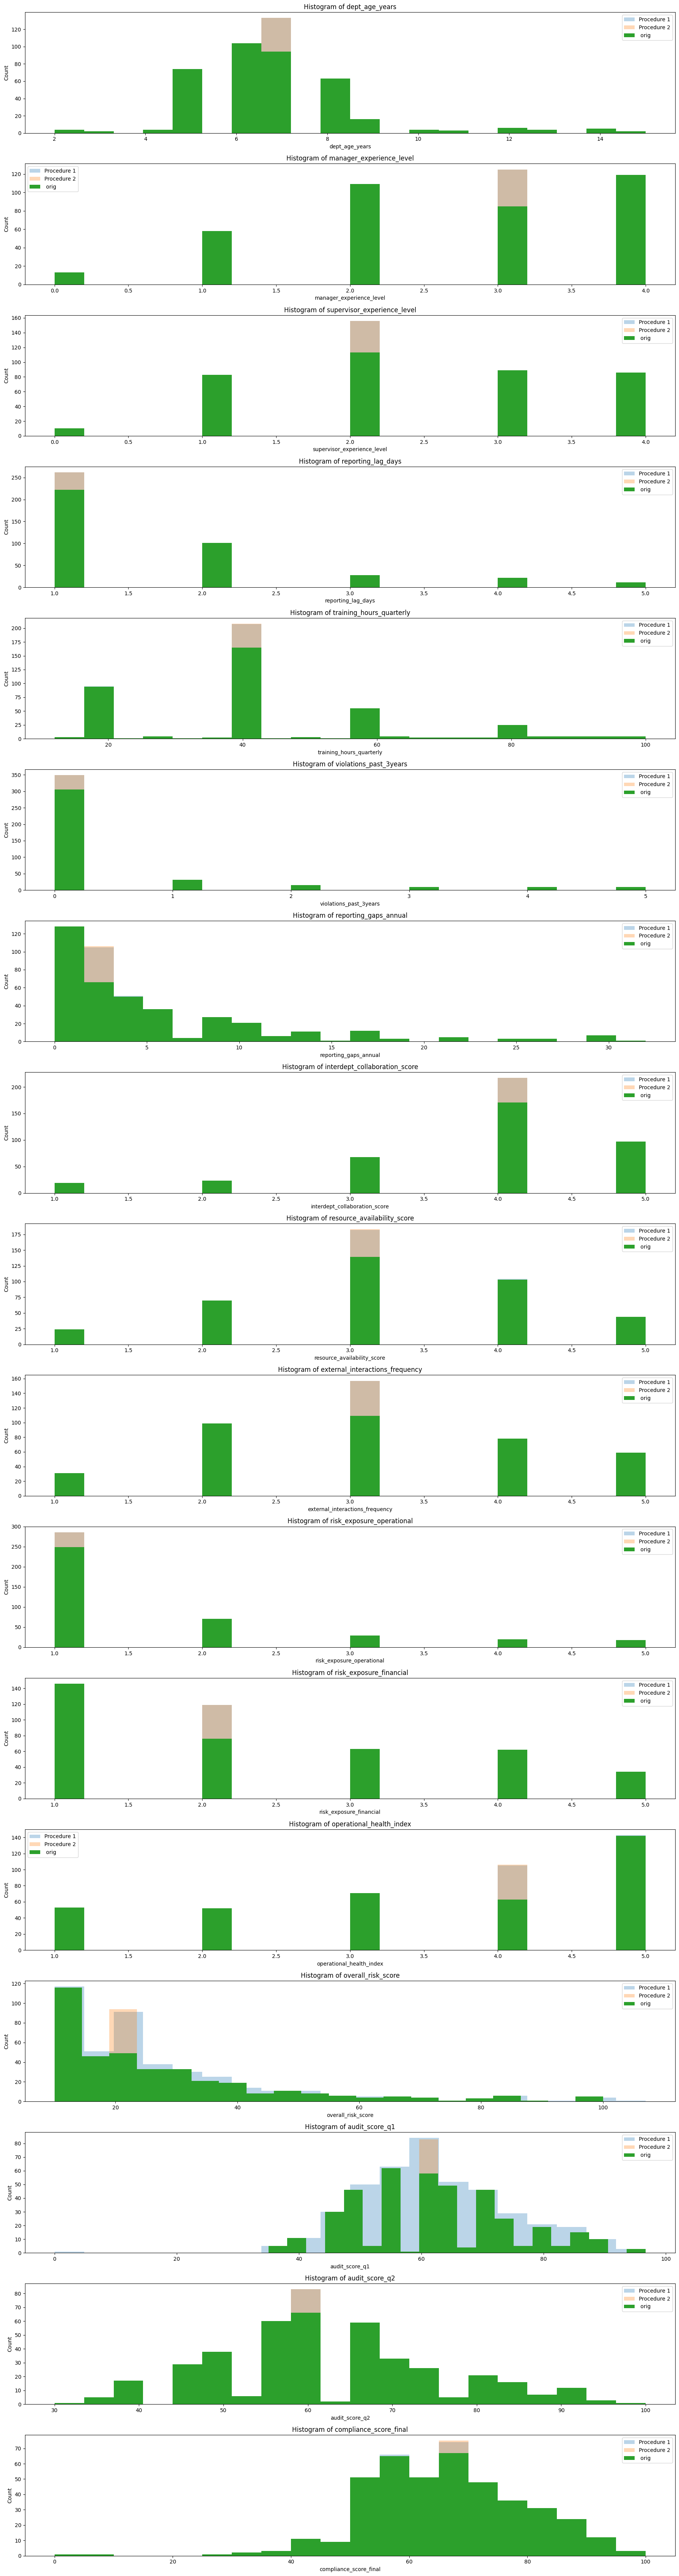

In [57]:
#compate distributions

# Columns to compare
numerical_cols_for_hist = [
    'dept_age_years', 'manager_experience_level', 'supervisor_experience_level',
    'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'reporting_gaps_annual', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'overall_risk_score', 'audit_score_q1', 'audit_score_q2',
    'compliance_score_final'
]

# Set up the figure
plt.figure(figsize=(18, len(numerical_cols_for_hist)*4))

for i, col in enumerate(numerical_cols_for_hist, 1):
    plt.subplot(len(numerical_cols_for_hist), 1, i)
    plt.hist(departments_copy_for_missing_imputation_1[col], bins=20, alpha=0.3, label='Procedure 1')
    plt.hist(departments_copy_for_missing_imputation_2[col], bins=20, alpha=0.3, label='Procedure 2')
    plt.hist(departments[col], bins=20, alpha=1, label=' orig')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

---
Although the division-level statistics between the two procedures are similar, the distributions of individual numerical variables show that Procedure 2 preserves the original data patterns more accurately. Therefore, Procedure 2 should be adopted for final imputation.

---

#### **Adopting Procedure 2**

In [58]:
departments = departments_copy_for_missing_imputation_2.copy()
high_risk_departments = high_risk_copy_for_missing_imputation_2.copy()
risk_summary_by_division_new = proc2_stats

In [59]:
departments.shape

(424, 37)

In [60]:
departments.head(5)

dept_id        dept_category             division   dept_type  \
0  DEPT-1003  Financial_Reporting         Corporate_HQ     Support   
4  DEPT-1066  Financial_Reporting         Corporate_HQ     Support   
5  DEPT-1070  Financial_Reporting         Corporate_HQ  Operations   
6  DEPT-1089  Financial_Reporting         Corporate_HQ     Support   
8  DEPT-1096  Financial_Reporting  Regional_Operations     Finance   

   dept_age_years  location_type team_size reporting_structure  \
0             8.0          Urban     Large         Centralized   
4             5.0          Urban     Large         Centralized   
5             6.0          Urban     Small         Centralized   
6             7.0          Urban     Small          Autonomous   
8             7.0  International     Large         Centralized   

   manager_experience_level  supervisor_experience_level  ...  \
0                       1.0                          2.0  ...   
4                       3.0                          4.0  ...   
5                       3.0                          2.0  ...   
6                       4.0                          4.0  ...   
8                       1.0                          0.0  ...   

  risk_exposure_financial operational_health_index  reporting_gaps_annual  \
0                     1.0                      4.0                    0.0   
4                     1.0                      5.0                    2.0   
5                     5.0                      3.0                   16.0   
6                     1.0                      4.0                    0.0   
8                     4.0                      2.0                    2.0   

   audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  \
0            60.0            65.0                    65.0                21.0   
4            65.0            65.0                    65.0                11.0   
5            50.0            55.0                    60.0                48.0   
6            70.0            75.0                    75.0                10.0   
8            51.1            51.0                    51.0                88.0   

   present_in_high_risk_departments  extreme_non_compliance  \
0                                 0                       0   
4                                 0                       0   
5                                 1                       0   
6                                 0                       0   
8                                 1                       0   

   audit_scores_missing  
0                     0  
4                     0  
5                     0  
6                     0  
8                     0  

[5 rows x 37 columns]

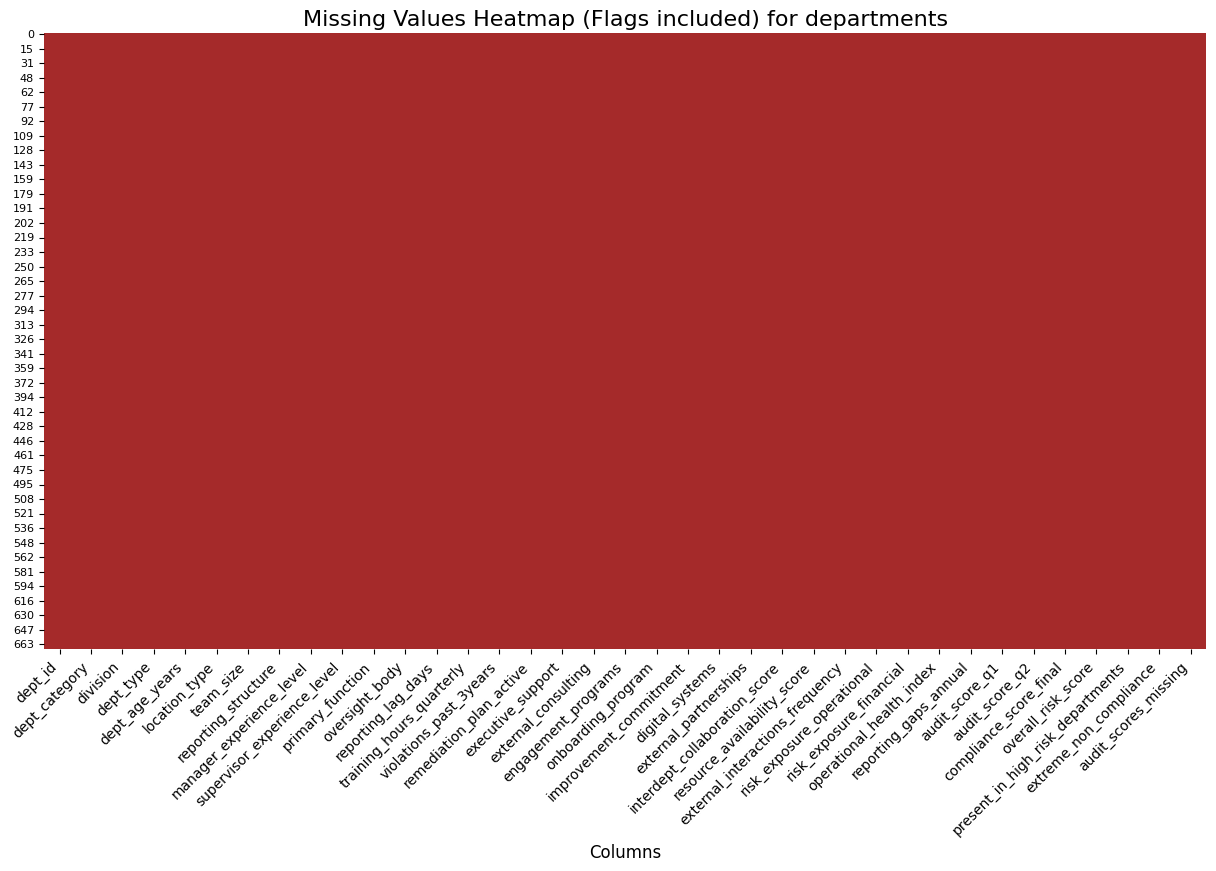

In [61]:
plt.figure(figsize=(15,8))

sns.heatmap(
    departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)

plt.title('Missing Values Heatmap (Flags included) for departments', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

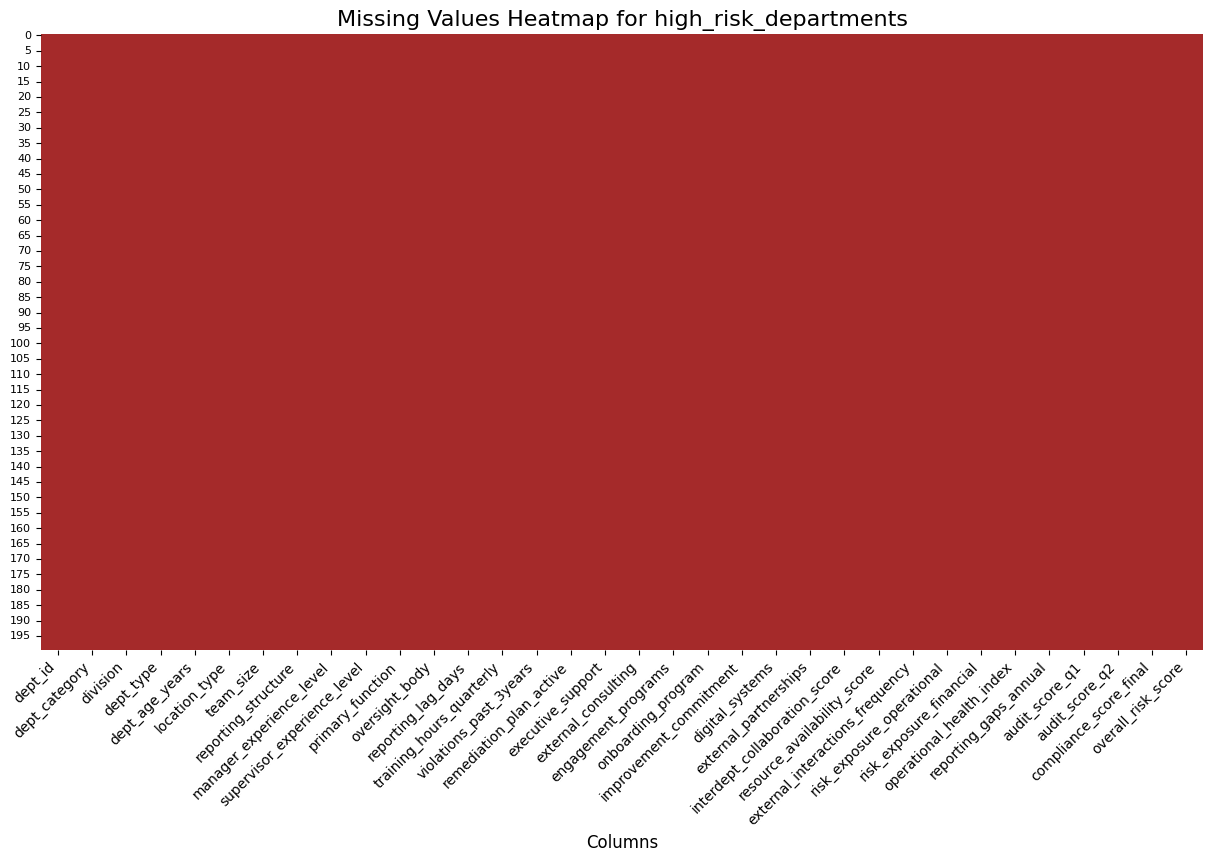

In [62]:
plt.figure(figsize=(15,8))

sns.heatmap(
    high_risk_departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)

plt.title('Missing Values Heatmap for high_risk_departments', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

In [63]:
departments_raww = departments.copy()

## **Standardize numerical variables**

In [64]:
df = departments.copy()

In [65]:
# Define feature groups
continuous_counts = [
    'dept_age_years', 'reporting_lag_days', 'training_hours_quarterly',
    'violations_past_3years', 'reporting_gaps_annual'
]

float_scores = [ 'audit_score_q1', 'audit_score_q2', 'overall_risk_score']

ordinal_scores = [
    'manager_experience_level', 'supervisor_experience_level',
    'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational',
    'risk_exposure_financial', 'operational_health_index'
]

binary_features = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships'
]


In [66]:
# Handle skewness for counts
skew_threshold = 0.75
skewed_counts = departments[continuous_counts].apply(lambda x: skew(x.dropna()))
skewed_counts = skewed_counts[abs(skewed_counts) > skew_threshold].index.tolist()

print("Skewed count features:", skewed_counts)

for col in skewed_counts:
    # log1p works for zeros
    departments[col] = np.log1p(departments[col])

Skewed count features: ['dept_age_years', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years', 'reporting_gaps_annual']


In [67]:
# Standardize continuous and ordinal features
to_standardize = continuous_counts + float_scores + ordinal_scores
scaler = StandardScaler()
departments[to_standardize] = scaler.fit_transform(departments[to_standardize])

print("\nStandardization complete. Preview:")
departments.head(3)


Standardization complete. Preview:


dept_id        dept_category      division   dept_type  dept_age_years  \
0  DEPT-1003  Financial_Reporting  Corporate_HQ     Support        0.733198   
4  DEPT-1066  Financial_Reporting  Corporate_HQ     Support       -1.089808   
5  DEPT-1070  Financial_Reporting  Corporate_HQ  Operations       -0.396733   

  location_type team_size reporting_structure  manager_experience_level  \
0         Urban     Large         Centralized                 -1.486610   
4         Urban     Large         Centralized                  0.306627   
5         Urban     Small         Centralized                  0.306627   

   supervisor_experience_level  ... risk_exposure_financial  \
0                    -0.344146  ...               -1.029951   
4                     1.502915  ...               -1.029951   
5                    -0.344146  ...                2.050820   

  operational_health_index  reporting_gaps_annual  audit_score_q1  \
0                 0.327411              -1.266665       -0.163561   
4                 1.050442              -0.177868        0.242945   
5                -0.395621               1.541237       -0.976575   

   audit_score_q2  compliance_score_final  overall_risk_score  \
0        0.204688                    65.0           -0.295272   
4        0.204688                    65.0           -0.846065   
5       -0.558281                    60.0            1.191870   

   present_in_high_risk_departments  extreme_non_compliance  \
0                                 0                       0   
4                                 0                       0   
5                                 1                       0   

   audit_scores_missing  
0                     0  
4                     0  
5                     0  

[3 rows x 37 columns]

## **Encoding**

We will begin with encoding of our categroical variables, in order to be able to work wiht them in trainin our ML model:

These following variables will be encoded using one-hot (dummy variable) encoding since we have no inherent order, and the varivbales do not have so many categories, so in this case OHE is the most effecive.

- dept_category
- division
- dept_type
- location_type
- team_size
- reporting_structure
- primary_function
- oversight_body

---

In [68]:
departments_copy_for_encoding = departments.copy()
departments_not_encoded = departments.copy()

In [69]:
#we list the variable swhich shall bve encoded as said before
categorical_cols_to_encode = [
    'dept_category', 'division', 'dept_type',
    'location_type', 'team_size', 'reporting_structure', 'primary_function',
     'oversight_body'
]

In [70]:
# store safely the 'dept_id' column separately since we are creatign a new data farnme wiht the categorical varibales
department_ids = departments['dept_id']

# then we drop the 'dept_id' from the working dataframe so it is not encoded, since the pd.get_dummies will be encoding all catheorical variables included in the original dataframe
departments_working = departments.drop(columns=['dept_id'])

In [71]:
# then here we perform one-H´hot encoding using the pd.get_dummies function as we know
departments_encoded = pd.get_dummies(
    departments_working,
    columns=categorical_cols_to_encode,
    #drop the first dummy variable to avoide the dummy variable trap
    drop_first=True,
    dtype=int
)

In [72]:
# finally insert the original dept_id column back into the encoded dataframe
departments_encoded.insert(0, 'dept_id', department_ids)
departments = departments_encoded

In [73]:
#to viualise the encoded varibales in the dataframe
departments.head(2)

dept_id  dept_age_years  manager_experience_level  \
0  DEPT-1003        0.733198                 -1.486610   
4  DEPT-1066       -1.089808                  0.306627   

   supervisor_experience_level  reporting_lag_days  training_hours_quarterly  \
0                    -0.344146            0.597346                  0.057076   
4                     1.502915           -0.697432                  0.973154   

   violations_past_3years  remediation_plan_active  executive_support  \
0               -0.429057                      1.0                0.0   
4               -0.429057                      0.0                1.0   

   external_consulting  ...  reporting_structure_Hybrid  \
0                  0.0  ...                           0   
4                  0.0  ...                           0   

   primary_function_Compliance  primary_function_Finance  \
0                            0                         0   
4                            1                         0   

   primary_function_Legal  primary_function_Operations  \
0                       0                            0   
4                       0                            0   

   primary_function_Other  primary_function_Technology  \
0                       1                            0   
4                       0                            0   

   oversight_body_Compliance_Officer  oversight_body_External_Auditor  \
0                                  0                                0   
4                                  0                                0   

   oversight_body_Internal_Audit  
0                              1  
4                              1  

[2 rows x 53 columns]

In [74]:
#Check for shape of dataframe
print(f"Final DataFrame Shape: {departments.shape}")

Final DataFrame Shape: (424, 53)


## **Feature selection and collinearity**

### **Correlation Analysis**

We check correlations with our two target variables:
- Primary: compliance_score_final
- Secondary: overall_risk_score

---
Both variables are numerical, therefore, we can check correlations **numetical vs numerical** and **numerical vs categorical**. Boolean variables we include in categorical.

---

**Target vs Categorical variables**

In [75]:
categorical_cols = ['dept_category', 'division', 'dept_type',
    'location_type', 'team_size', 'reporting_structure', 'primary_function',
     'oversight_body'
]
bool_cols = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships', 'present_in_high_risk_departments',
    'extreme_non_compliance','audit_scores_missing'
]
all_categorical_cols = categorical_cols + bool_cols

---
We use departments_not_encoded table.

---

In [76]:
# sns.boxplot(data=departments_not_encoded, x='dept_category', ...)

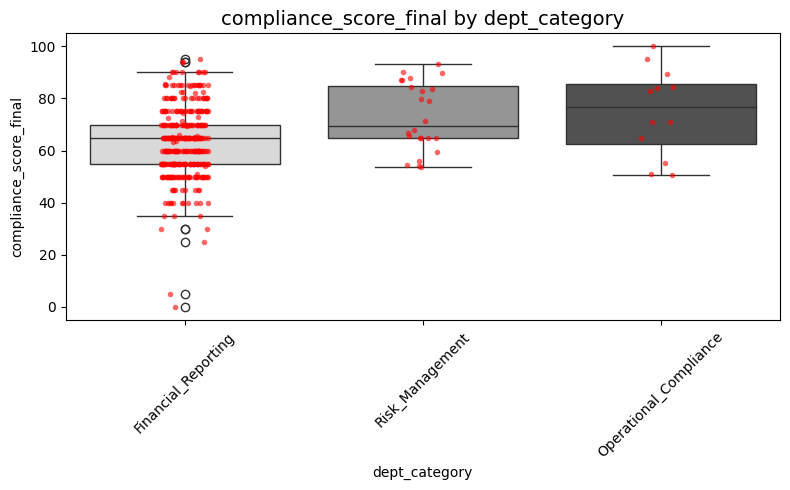

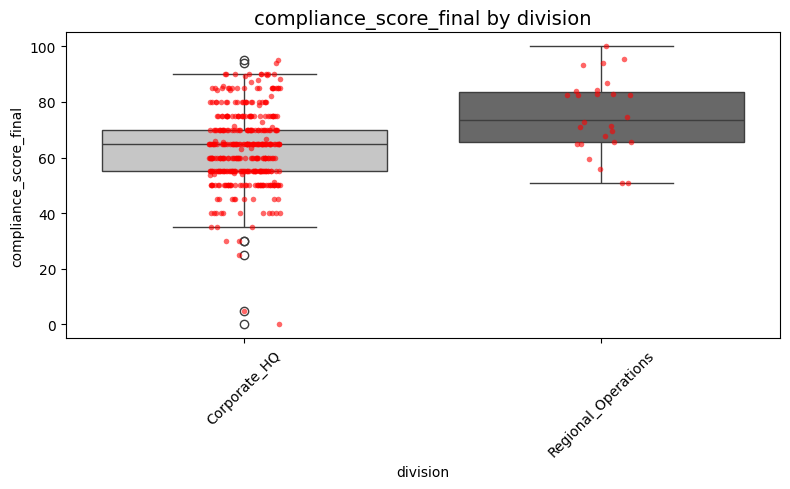

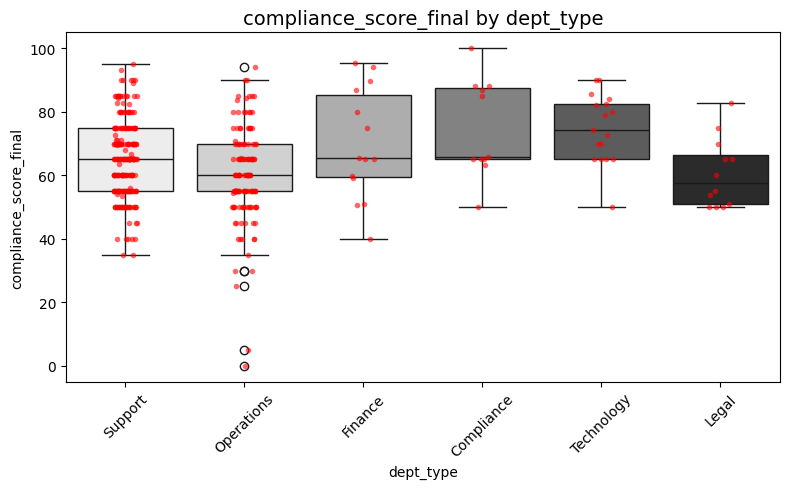

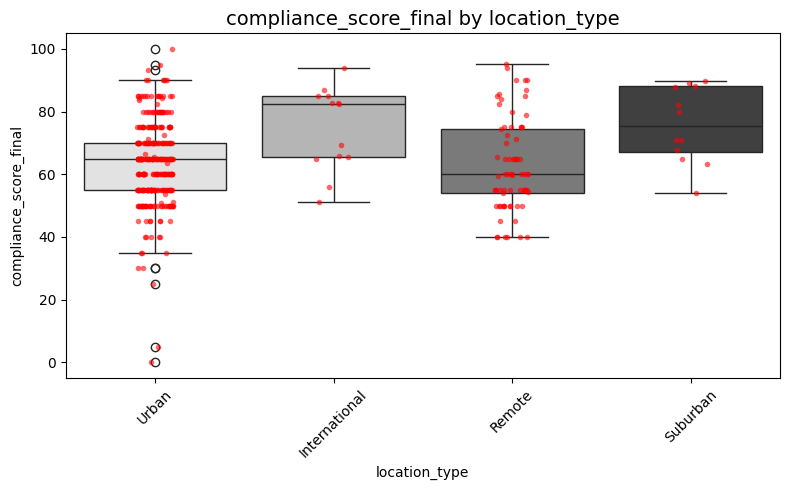

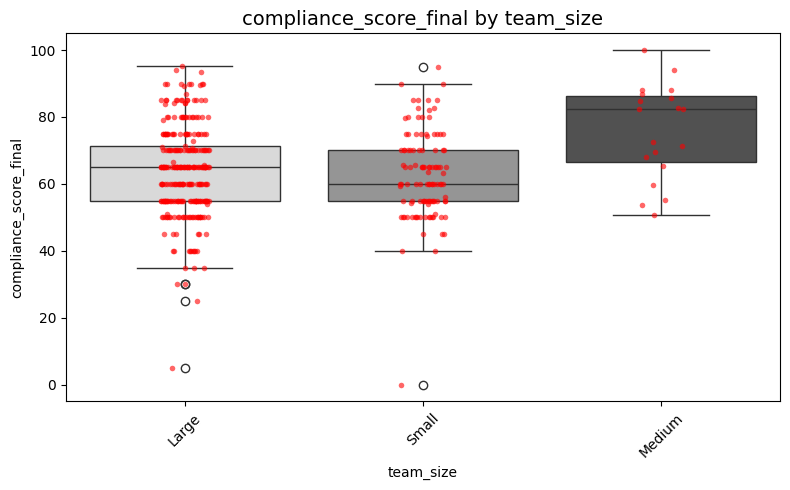

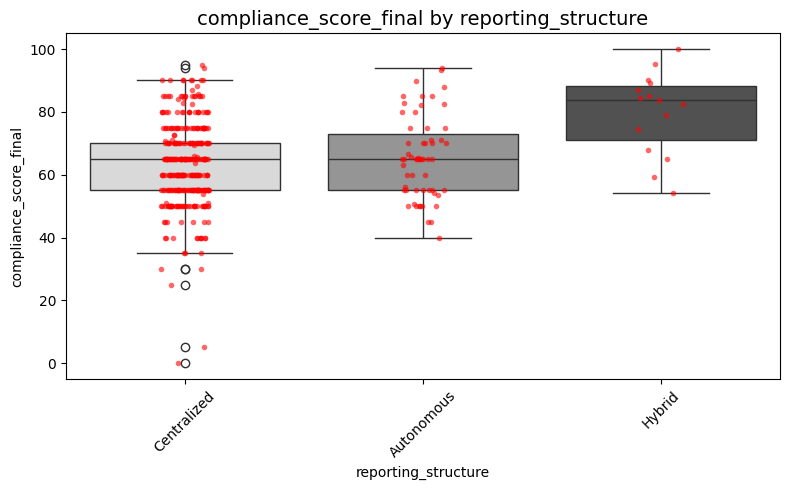

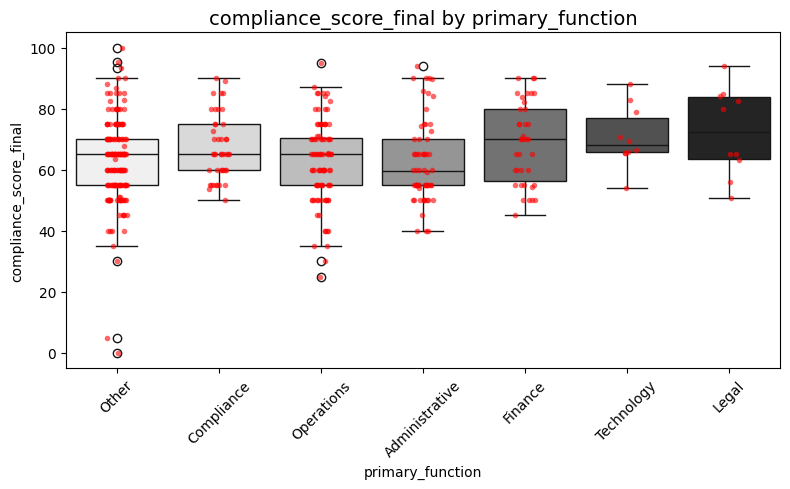

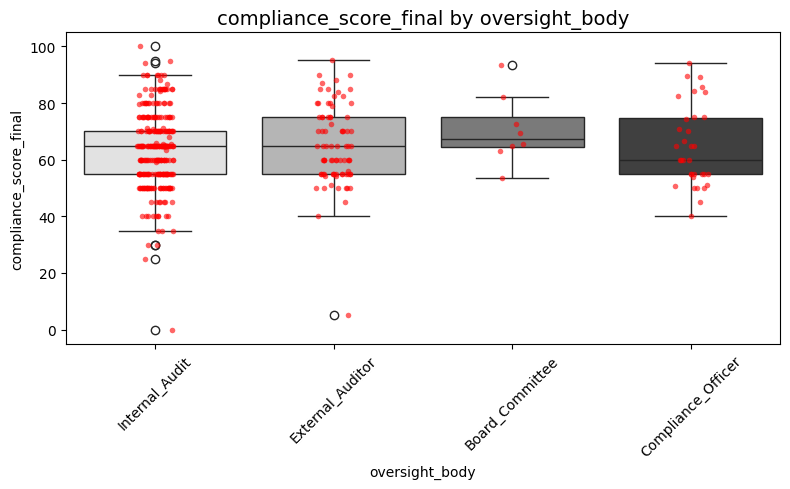

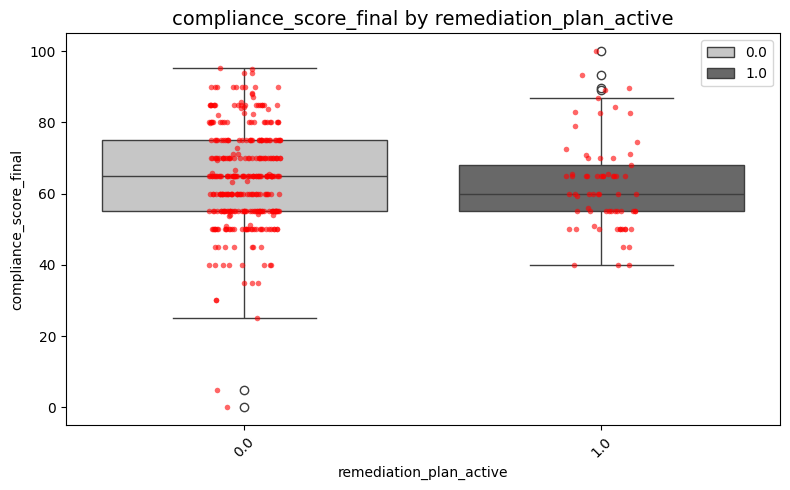

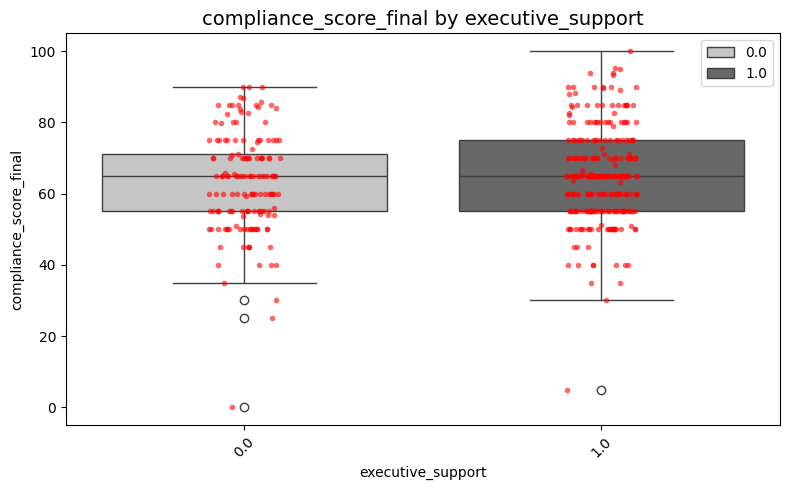

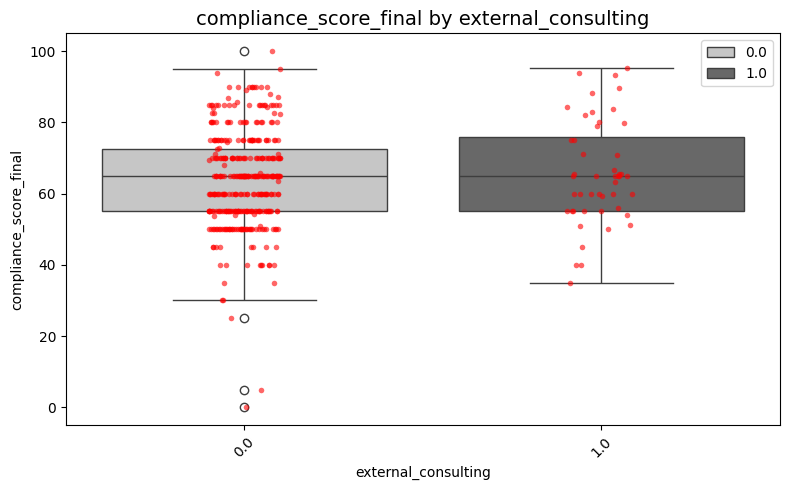

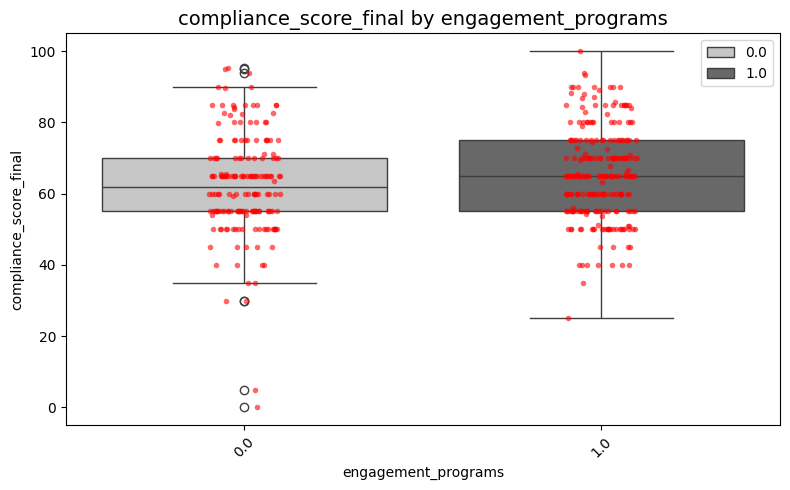

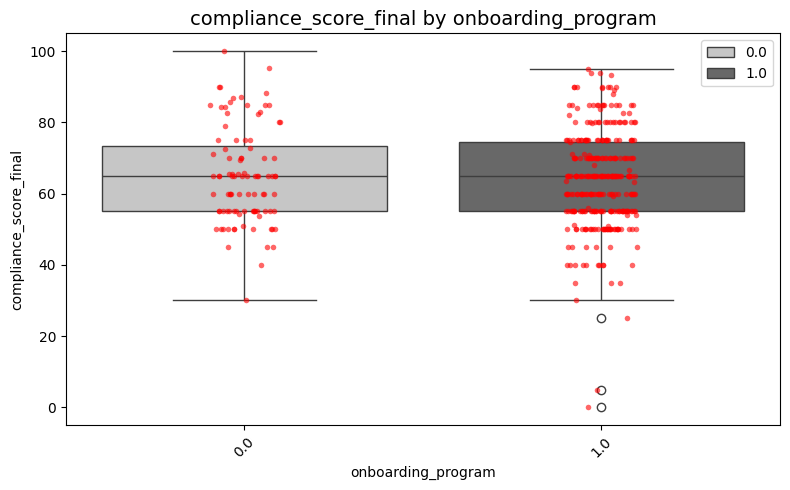

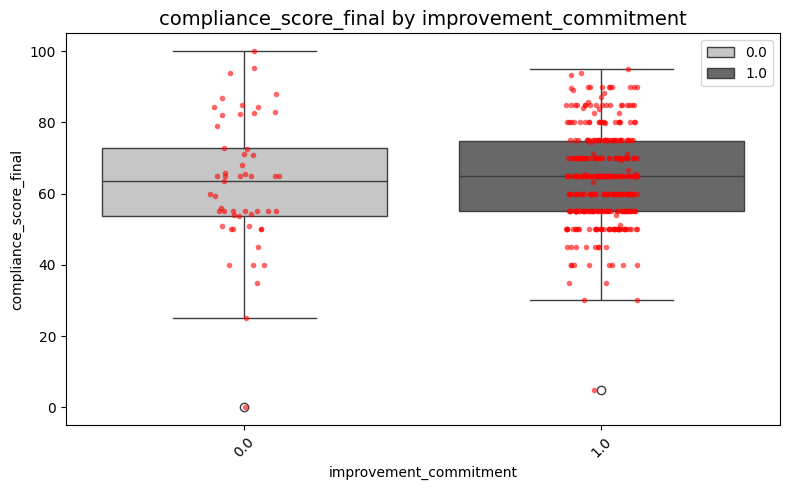

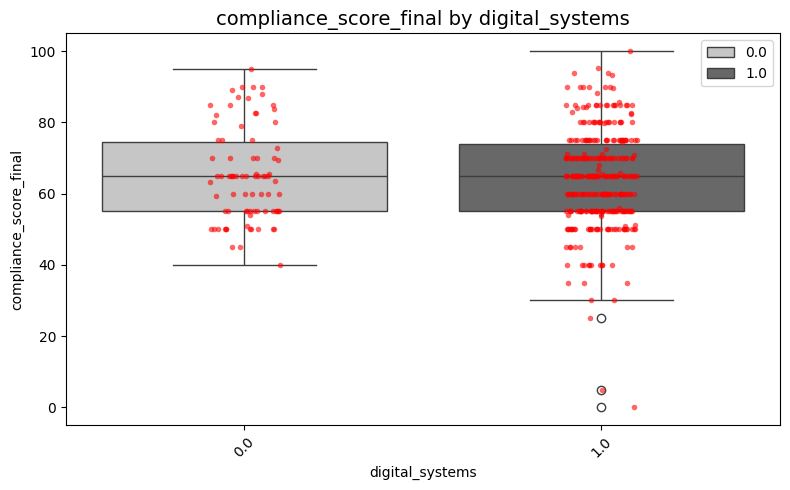

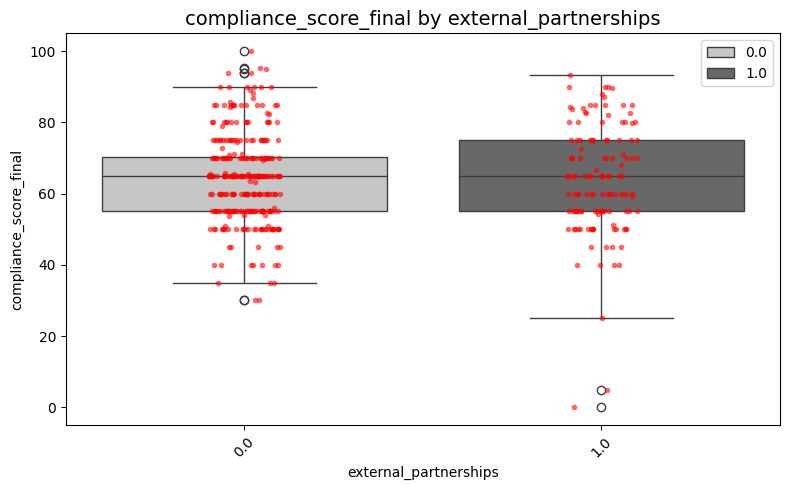

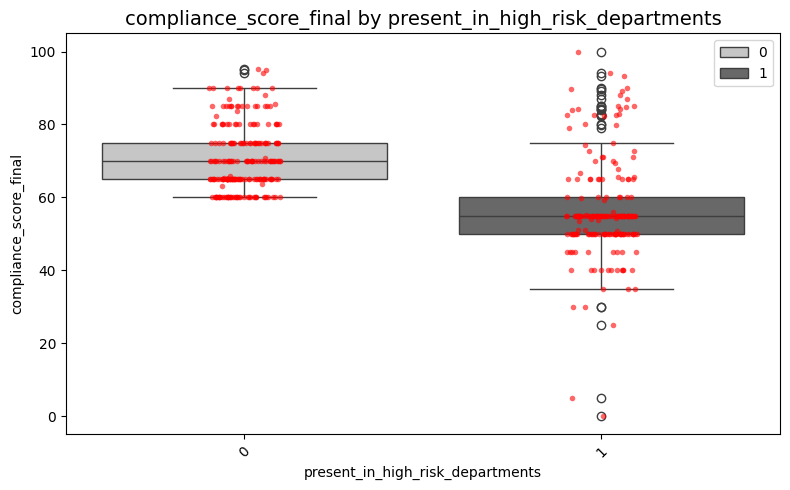

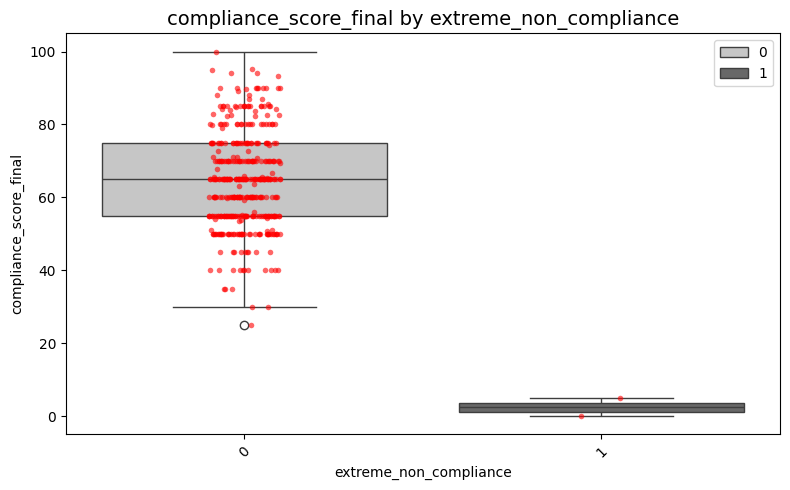

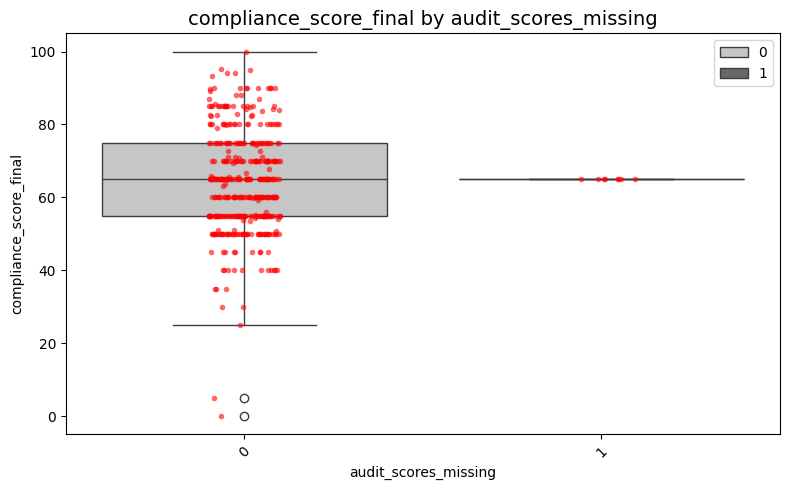

In [77]:
num_cols = ['compliance_score_final']

for cat_col in all_categorical_cols:
    for num_col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(
            data=departments_not_encoded,
            x=cat_col,
            y=num_col,
            hue=cat_col,
            palette="Greys"
        )
        sns.stripplot(  # shows all points like px.points='all'
            data=departments_not_encoded,
            x=cat_col,
            y=num_col,
            color='red',
            size=4,
            jitter=True,
            alpha=0.6
        )
        plt.title(f'{num_col} by {cat_col}', fontsize=14)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

---
On average:
- For Technology department type (dept_type) the compliance is the highest, while for Legal department type it is the lowest.
- Medium team_size clearly has higher compliance as well as Hybrid reporting structure.
- International location in location_type shows higher compliance (important to mention, that the least amount of departments work abroad)
- Departments with Remediation plan have slightly higher compliance.
- Departments that were marked as high risky show lower compliance.

---

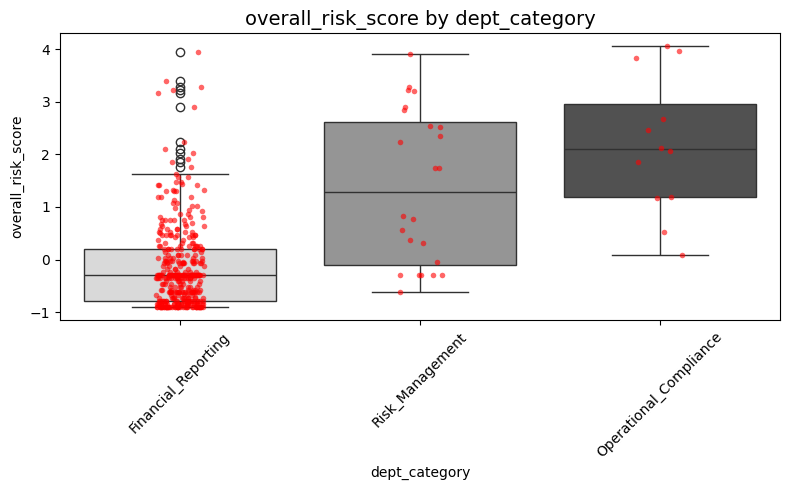

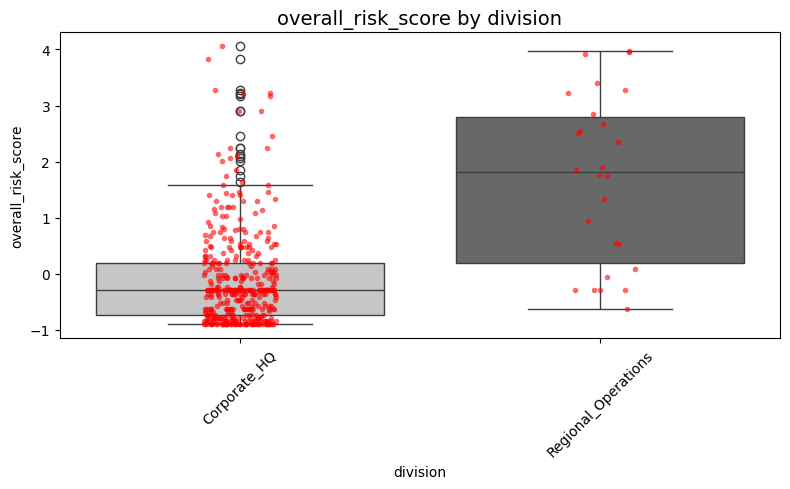

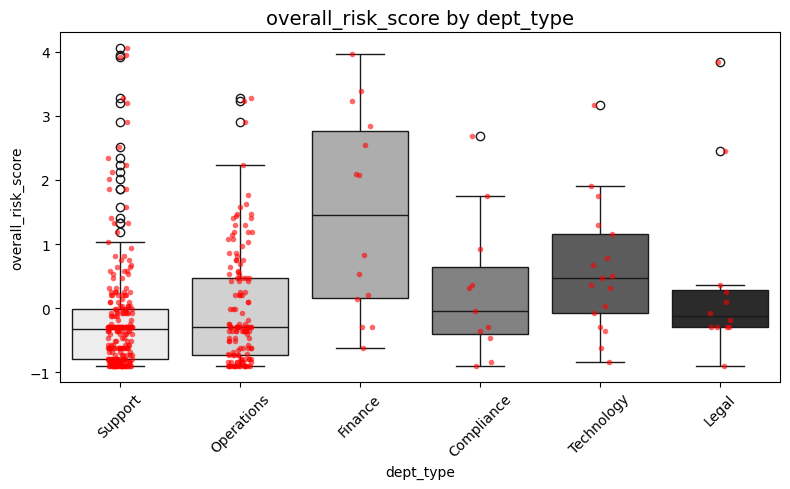

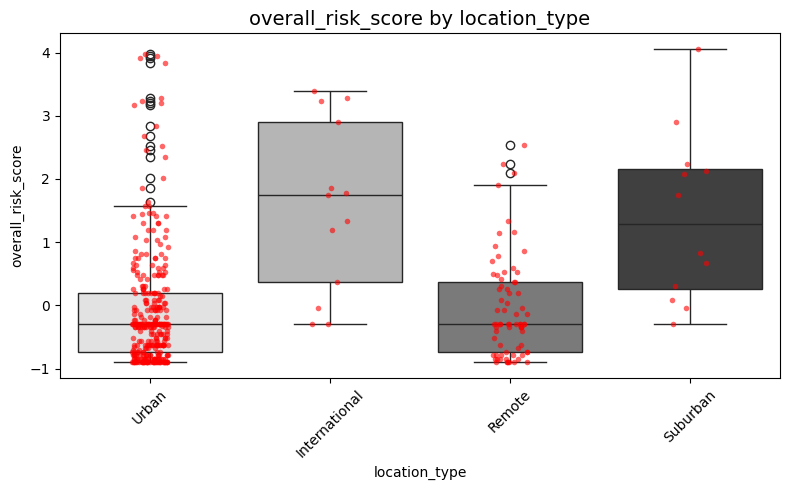

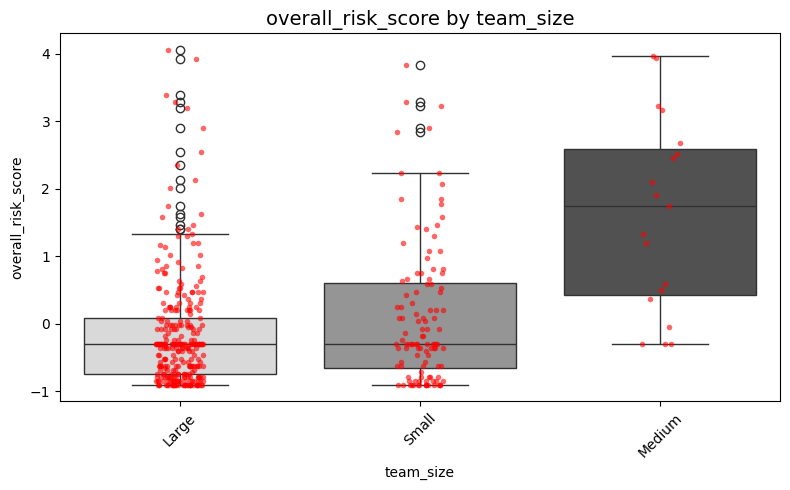

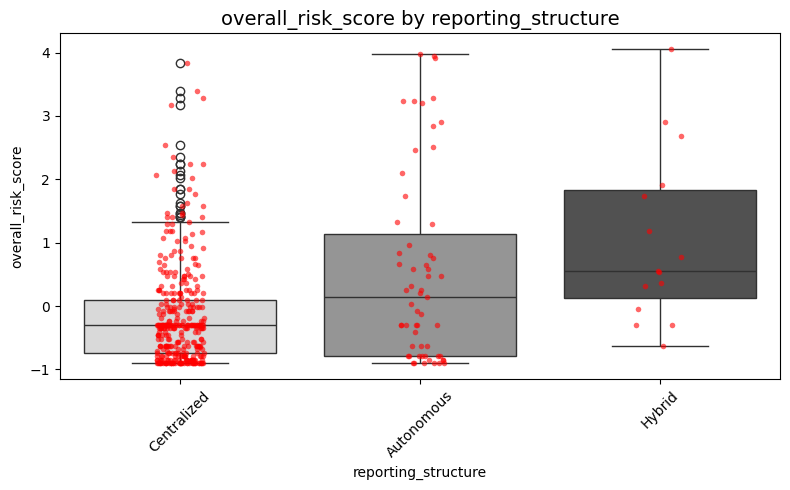

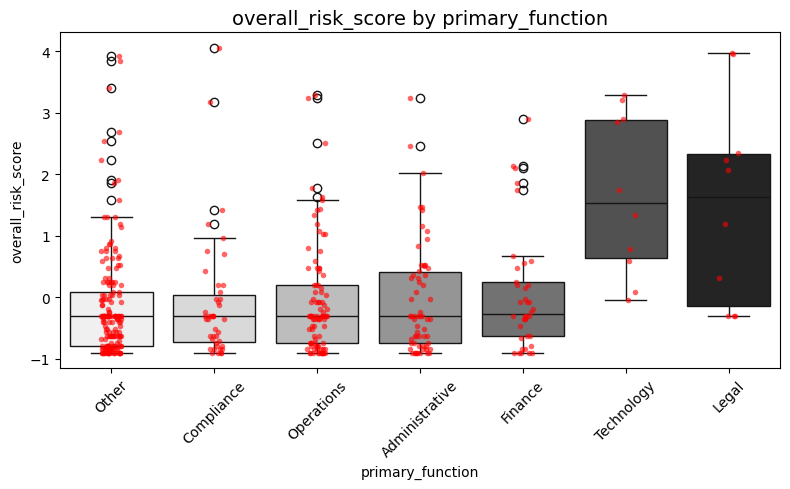

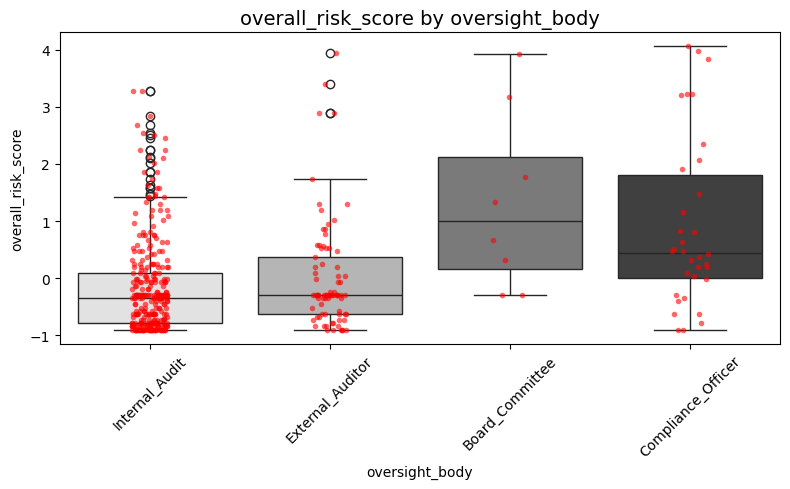

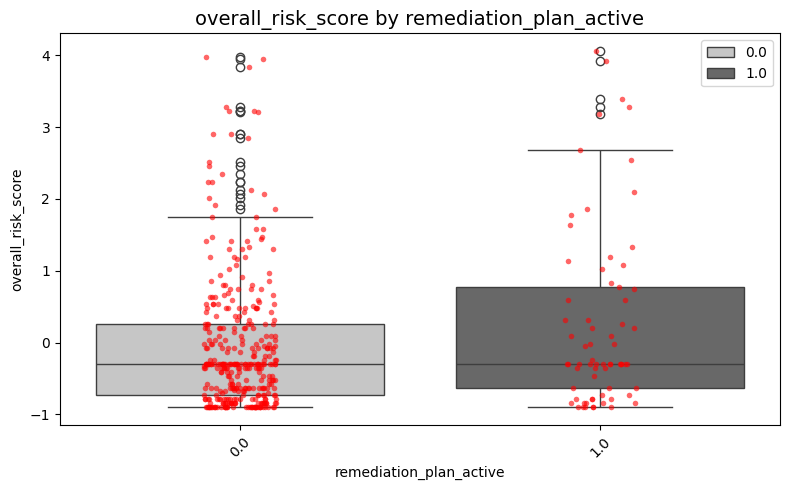

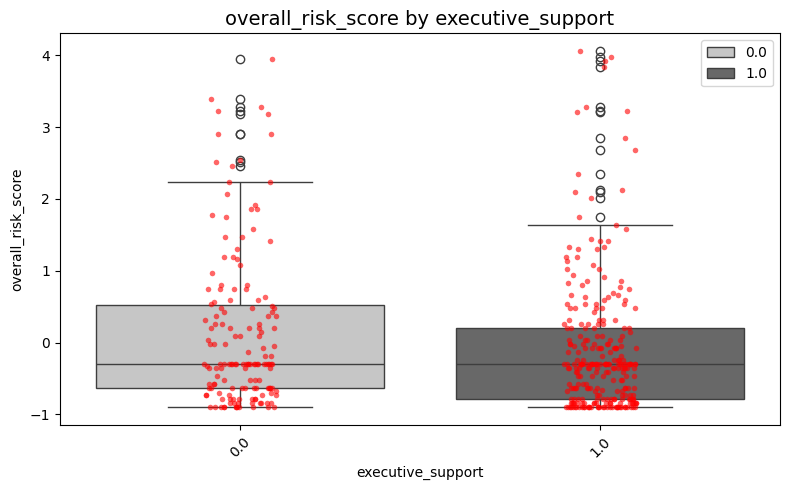

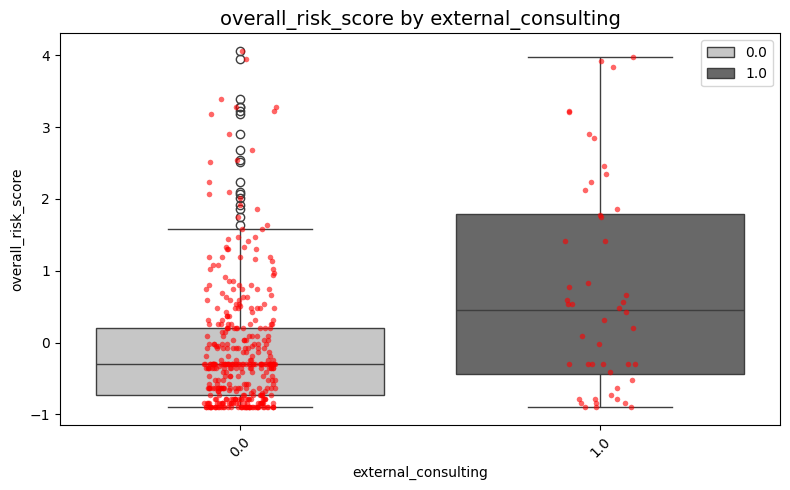

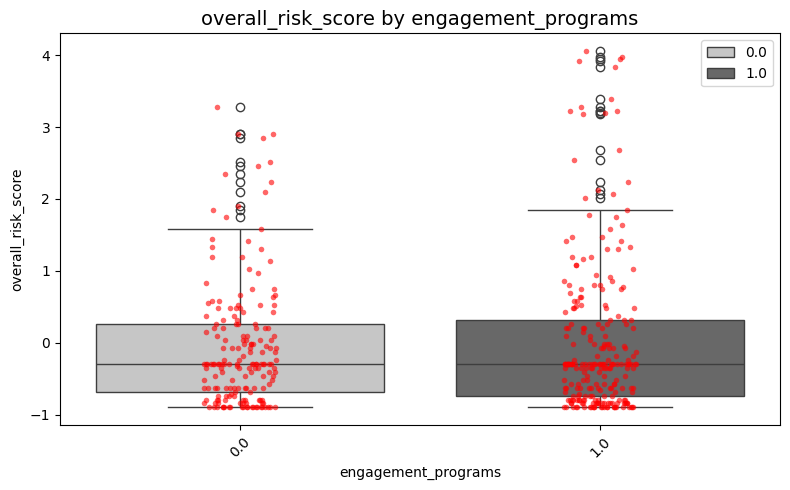

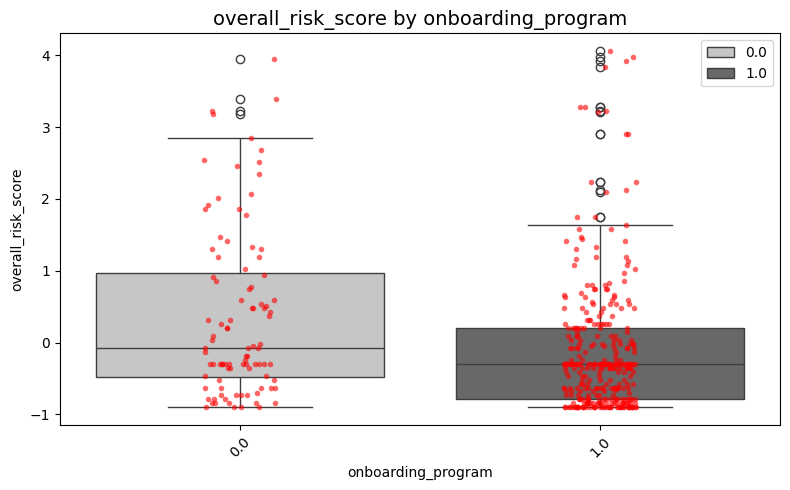

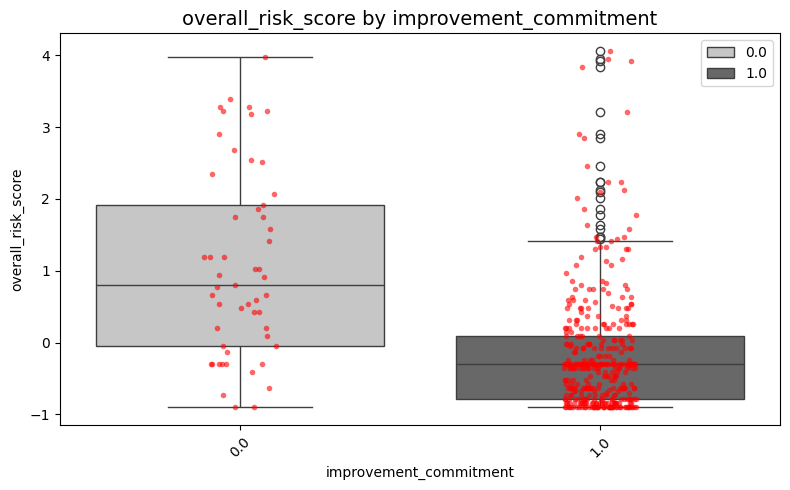

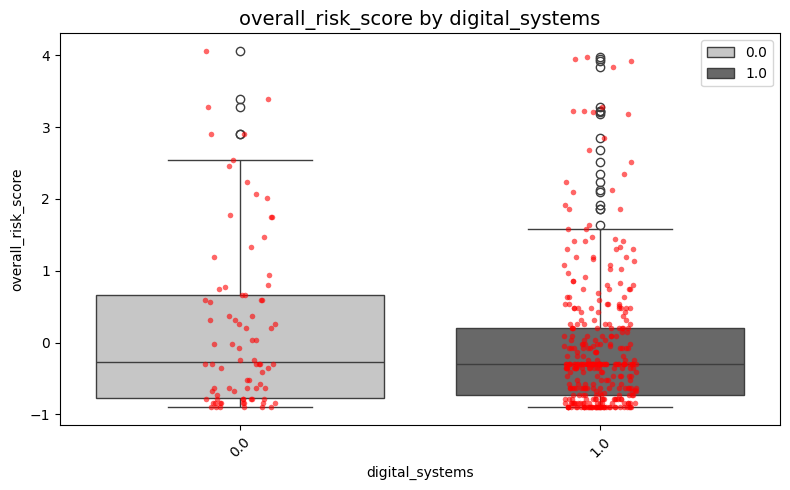

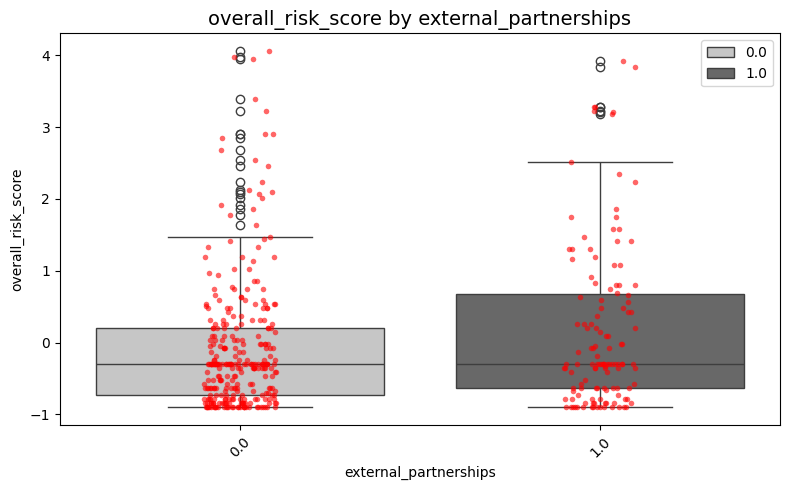

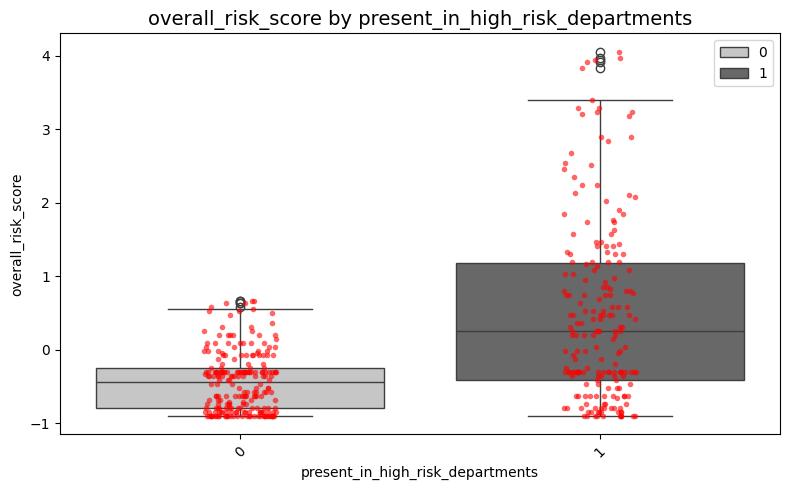

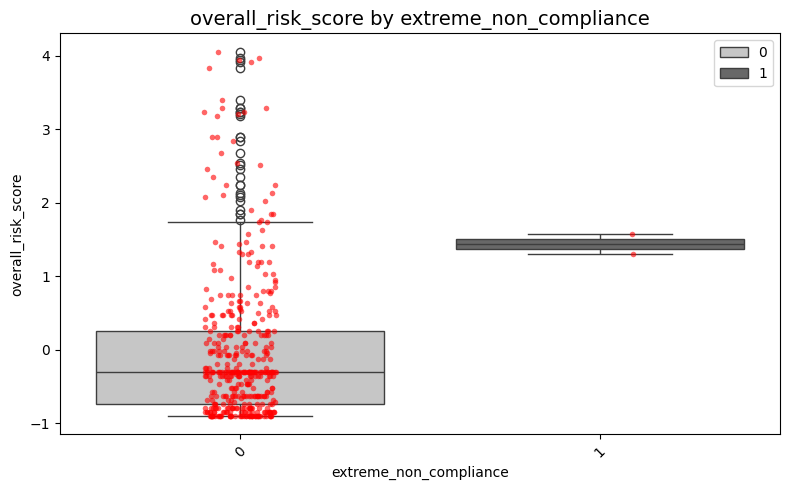

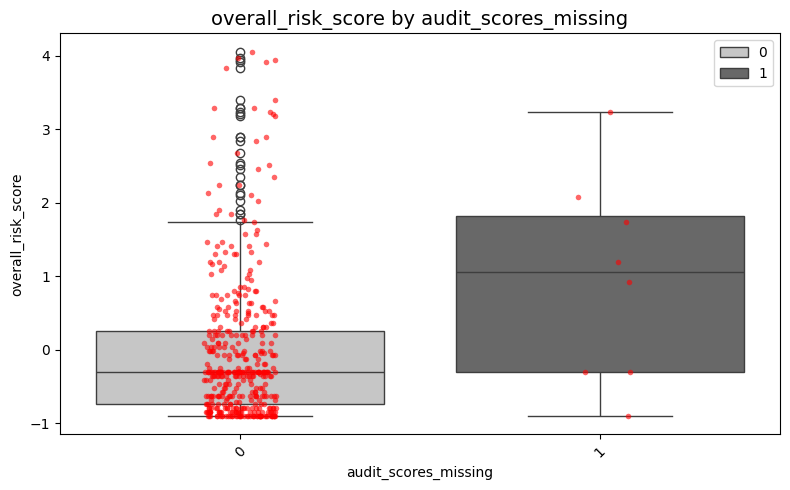

In [78]:
num_cols = ['overall_risk_score']

for cat_col in all_categorical_cols:
    for num_col in num_cols:
        plt.figure(figsize=(8, 5))

        sns.boxplot(
            data=departments_not_encoded,
            x=cat_col,
            y=num_col,
            hue=cat_col,
            palette="Greys"   # works fine now
        )

        sns.stripplot(
            data=departments_not_encoded,
            x=cat_col,
            y=num_col,
            color='red',
            size=4,
            jitter=True,
            alpha=0.6
        )

        plt.title(f'{num_col} by {cat_col}', fontsize=14)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

---
On average:
- Departments dealing with Operational Compliance rules show the highest risk score, while for Financial Reporting, risk is the lowest.
- Regional Compliance division also demonstrates very high risk score, comparing to Corporate division.
- Financial departments tend to have higher risks, while Support are among the lowest together with Operations.
- International and suburban locations are much more risky than urban and remote.
- Medium team size shows the highest risks, while small and large are approximately on the same level and are not risky in general.
- Departments whose primary function is Legal or technology have much higher risks than any others.
- Departments checked by Board Committee show the highest risks.
- Absence of Improvement commitments increases risks
- Presence of external consulting also increases risks
- Obviously, departments previousely marked as highly risky show higher risks scores.
- Departments with Extreme non-compliance are also much more risky.
- Departments with missing audit scores (any) have higher risks.

---

**Target vs Numerical variables**

In [79]:
# Compute correlation matrix
corr_matrix = departments_not_encoded[numerical_cols].corr()

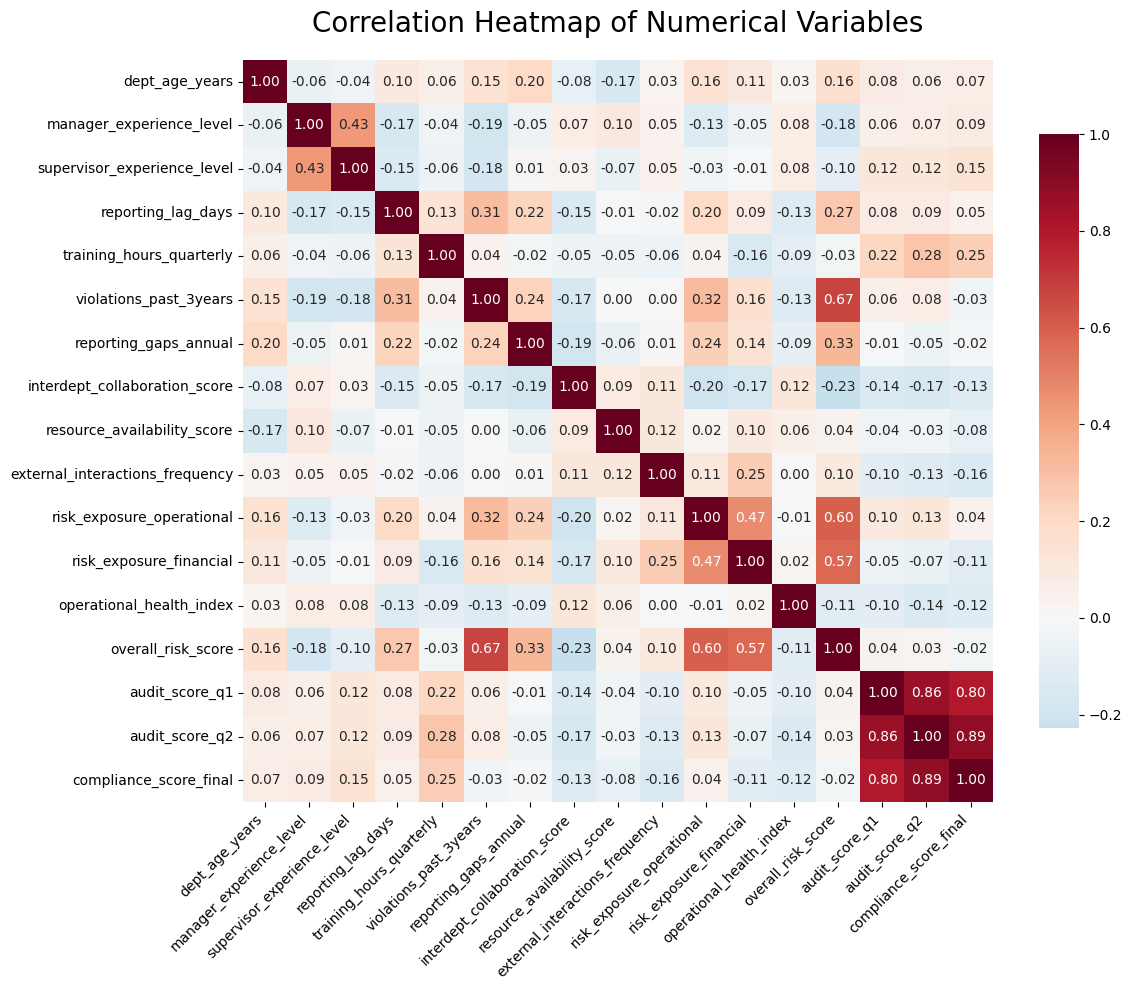

In [80]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,         # show correlation values
    fmt=".2f",
    cmap="RdBu_r",      # same as Plotly RdBu_r
    center=0,
    cbar_kws={"shrink": 0.8, "aspect": 15}  # similar thickness/length as Plotly
)

plt.title("Correlation Heatmap of Numerical Variables", fontsize=20, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
***FOR compliance_score_final***

The two audit variables completely dominate:
- audit_score_q2 → 0.89
- audit_score_q1 → 0.80

This is the only non-audit factor with meaningful relationship:

training_hours_quarterly → 0.25

Weak correlations:
- external_interactions_frequency → -0.16
- operational_health_index → -0.12
- interdept_collaboration_score → -0.13
- dept_age_years → 0.11


Other relationships are too weak.


---
***FOR overall_risk_score***

Strong predictors:
- risk_exposure_operational → 0.60
- violations_past_3years → 0.67
- risk_exposure_financial → 0.57
- reporting_gaps_annual → 0.38

These variables dominate the relationship with overall_risk_score and should definitely be kept.

Moderate predictors:
- dept_age_years → 0.24
- interdept_collaboration_score → -0,23
- reporting_lag_days → 0.28
- manager_experience_level → -0.18

Other relationships are too weak.

---

### **Multicolinearity check**

Now we will dig into searching for multicollinearuty between our varibales, since this might be problematic for our future model training.

This step is critical for creating an analytical framework for explanation and risk mitigation!

As an exapmle if two of our variables lets say: if team_size_Large and reporting_structure_Centralized are 95% correlated, our model will not be able to detect which of these two varibles are responsible for a change in the risk score.

In addition, statistically multicollinearity might create more unstabile and harder to train models.

We can detect multicollineraity using the VIF (variance inflation factor). The VIF measures how much the variance of a regression coefficient is increased due to collinearity with other predictors.

---

In [81]:
columns_we_drop = [
    'compliance_score_final',          # our target variable
    'overall_risk_score',              # total score                # Sum of Full + Part time   # Flag
    'presense_in_high_risk_departments',# Flag
    'extreme_non_compliance',
    'audit_scores_missing'

    # Flag
]

multi_col_check = departments.drop(columns=columns_we_drop, errors='ignore')
#take only numerical columns
multi_col_check = multi_col_check.select_dtypes(include=np.number)

print(f"Final VIF Check on {len(multi_col_check.columns)} columns.")

# tehn we run the VIF score calculation
vif_list = []
for i in range(multi_col_check.shape[1]):
    y = multi_col_check.iloc[:, i]
    X_i = multi_col_check.drop(columns=multi_col_check.columns[i])

    model = LinearRegression()
    model.fit(X_i, y)
    R2 = model.score(X_i, y)
    VIF = 1 / (1 - R2)
    vif_list.append(VIF)

# Show Results
vif_data = pd.DataFrame({"Feature": multi_col_check.columns, "VIF": vif_list})
print(vif_data.sort_values(by="VIF", ascending=False).round(2))

Final VIF Check on 48 columns.
                                 Feature    VIF
47         oversight_body_Internal_Audit  17.07
46       oversight_body_External_Auditor  13.38
30                     dept_type_Support  13.19
29                  dept_type_Operations  11.97
34                   location_type_Urban  10.57
32                  location_type_Remote   8.79
45     oversight_body_Compliance_Officer   6.60
22                        audit_score_q2   5.24
21                        audit_score_q1   4.30
31                  dept_type_Technology   3.11
27                     dept_type_Finance   2.90
33                location_type_Suburban   2.89
25         dept_category_Risk_Management   2.78
43                primary_function_Other   2.62
28                       dept_type_Legal   2.57
26          division_Regional_Operations   2.54
42           primary_function_Operations   2.51
38            reporting_structure_Hybrid   2.38
23      present_in_high_risk_departments   2.28
39       

In [82]:
threshold_certain = 10.0  # Common threshold for severe multicollinearity
threshold_possible = 5.0  # Common threshold for moderate multicollinearity

# --- 2. Define the Categorization Function ---
def categorize_vif(vif_score):
    """Assigns a categorical label based on the VIF score."""
    # Ensure VIF is treated as a number; use NaN check for safety
    if pd.isna(vif_score):
        return "Not Applicable (NaN)"

    if vif_score >= threshold_certain:
        return "Certain Multicollinearity (VIF >= 10)"
    elif vif_score >= threshold_possible:
        return "Possible Multicollinearity (VIF >= 5)"
    else:
        return "No Multicollinearity (VIF < 5)"

# --- 3. Apply Categorization ---
vif_data['multicollinearity_level'] = vif_data['VIF'].apply(categorize_vif)

print("\n--- Categorized Multicollinearity Levels Summary ---")

# --- 4. Show Variables with CERTAIN Multicollinearity ---
certain_vif_df = vif_data[vif_data['VIF'] >= threshold_certain]
print("\n--- Certain Multicollinearity (VIF >= 10) ---")
if not certain_vif_df.empty:
    print(certain_vif_df)
else:
    print("No features found with VIF >= 10. (Model is stable here.)")
print("-" * 30)

# --- 5. Show Variables with POSSIBLE Multicollinearity ---
possible_vif_df = vif_data[(vif_data['VIF'] >= threshold_possible) & (vif_data['VIF'] < threshold_certain)]
print("\n--- Possible Multicollinearity (VIF >= 5 and < 10) ---")
if not possible_vif_df.empty:
    print(possible_vif_df)
else:
    print("No features found with VIF >= 5.")
print("-" * 30)

# --- 6. Show Variables with NO Multicollinearity ---
no_vif_df = vif_data[vif_data['VIF'] < threshold_possible]
print(f"\n--- No Multicollinearity (VIF < 5) - {len(no_vif_df)} Features ---")
# Only print a sample since this list is usually long
print(no_vif_df.head(10))


--- Categorized Multicollinearity Levels Summary ---

--- Certain Multicollinearity (VIF >= 10) ---
                            Feature        VIF  \
29             dept_type_Operations  11.970847   
30                dept_type_Support  13.190663   
34              location_type_Urban  10.573844   
46  oversight_body_External_Auditor  13.383538   
47    oversight_body_Internal_Audit  17.074907   

                  multicollinearity_level  
29  Certain Multicollinearity (VIF >= 10)  
30  Certain Multicollinearity (VIF >= 10)  
34  Certain Multicollinearity (VIF >= 10)  
46  Certain Multicollinearity (VIF >= 10)  
47  Certain Multicollinearity (VIF >= 10)  
------------------------------

--- Possible Multicollinearity (VIF >= 5 and < 10) ---
                              Feature       VIF  \
22                     audit_score_q2  5.244076   
32               location_type_Remote  8.789859   
45  oversight_body_Compliance_Officer  6.595913   

                  multicollinearity_level 

Drop surely multicollinear variables

In [83]:
# --- 1. Identify features to drop ---
features_to_drop = certain_vif_df['Feature'].tolist()
print("Dropping features due to certain multicollinearity (VIF >= 10):")
print(features_to_drop)

# --- 2. Drop these features from your main dataframe ---
departments_clean = departments.drop(columns=features_to_drop)

print(f"\nShape before dropping: {departments.shape}")
print(f"Shape after dropping: {departments_clean.shape}")

Dropping features due to certain multicollinearity (VIF >= 10):
['dept_type_Operations', 'dept_type_Support', 'location_type_Urban', 'oversight_body_External_Auditor', 'oversight_body_Internal_Audit']

Shape before dropping: (424, 53)
Shape after dropping: (424, 48)


---

### **Mutual Information**

Mutual Information measures how much knowing variable A reduces uncertainty about variable B.

Works for:
- nonlinear relationships
- categorical variables
- boolean variables

Interpretation:
- MI = 0 → variables are completely independent
- MI > 0 → some relationship exists
- The larger the MI, the stronger the dependency (not necessarily linear)

---

In [84]:
from sklearn.metrics import mutual_info_score
import numpy as np
import pandas as pd

# Function to compute entropy
def entropy(x):
    probs = np.bincount(x) / len(x)
    probs = probs[probs > 0]  # avoid log(0)
    return -np.sum(probs * np.log2(probs))

# Compute normalized MI (by min entropy)
cols = departments.columns
dep_mi = departments.copy()
for c in dep_mi.columns:
    dep_mi[c] = pd.factorize(dep_mi[c])[0]

mi_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

for c1 in cols:
    for c2 in cols:
        mi = mutual_info_score(dep_mi[c1], dep_mi[c2])
        h1 = entropy(dep_mi[c1])
        h2 = entropy(dep_mi[c2])
        mi_matrix.loc[c1, c2] = mi / min(h1, h2)  # normalized MI

mi_matrix

dept_id  dept_age_years  \
dept_id                               0.693147        0.693147   
dept_age_years                        0.693147        0.693147   
manager_experience_level              0.693147        0.038294   
supervisor_experience_level           0.693147        0.032911   
reporting_lag_days                    0.693147        0.085729   
training_hours_quarterly              0.693147        0.171265   
violations_past_3years                0.693147        0.137176   
remediation_plan_active               0.693147        0.077324   
executive_support                     0.693147        0.012837   
external_consulting                   0.693147        0.058770   
engagement_programs                   0.693147        0.010755   
onboarding_program                    0.693147        0.043033   
improvement_commitment                0.693147        0.127191   
digital_systems                       0.693147        0.044141   
external_partnerships                 0.693147        0.024196   
interdept_collaboration_score         0.693147        0.038055   
resource_availability_score           0.693147        0.046669   
external_interactions_frequency       0.693147        0.055006   
risk_exposure_operational             0.693147        0.073343   
risk_exposure_financial               0.693147        0.038162   
operational_health_index              0.693147        0.031780   
reporting_gaps_annual                 0.693147        0.116760   
audit_score_q1                        0.693147        0.203248   
audit_score_q2                        0.693147        0.218414   
compliance_score_final                0.693147        0.215390   
overall_risk_score                    0.693147        0.236809   
present_in_high_risk_departments      0.693147        0.022342   
extreme_non_compliance                0.693147        0.105470   
audit_scores_missing                  0.693147        0.133746   
dept_category_Operational_Compliance  0.693147        0.361312   
dept_category_Risk_Management         0.693147        0.150702   
division_Regional_Operations          0.693147        0.253891   
dept_type_Finance                     0.693147        0.150868   
dept_type_Legal                       0.693147        0.086409   
dept_type_Operations                  0.693147        0.029693   
dept_type_Support                     0.693147        0.022381   
dept_type_Technology                  0.693147        0.104312   
location_type_Remote                  0.693147        0.029781   
location_type_Suburban                0.693147        0.221451   
location_type_Urban                   0.693147        0.083640   
team_size_Medium                      0.693147        0.364087   
team_size_Small                       0.693147        0.026346   
reporting_structure_Centralized       0.693147        0.081963   
reporting_structure_Hybrid            0.693147        0.236972   
primary_function_Compliance           0.693147        0.032184   
primary_function_Finance              0.693147        0.031963   
primary_function_Legal                0.693147        0.238798   
primary_function_Operations           0.693147        0.015689   
primary_function_Other                0.693147        0.017243   
primary_function_Technology           0.693147        0.207854   
oversight_body_Compliance_Officer     0.693147        0.117725   
oversight_body_External_Auditor       0.693147        0.026823   
oversight_body_Internal_Audit         0.693147        0.040576   

                                      manager_experience_level  \
dept_id                                               0.693147   
dept_age_years                                        0.038294   
manager_experience_level                              0.693147   
supervisor_experience_level                           0.083686   
reporting_lag_days                                    0.020940   
training_hours_quarterly                              0.102315   
violations_p

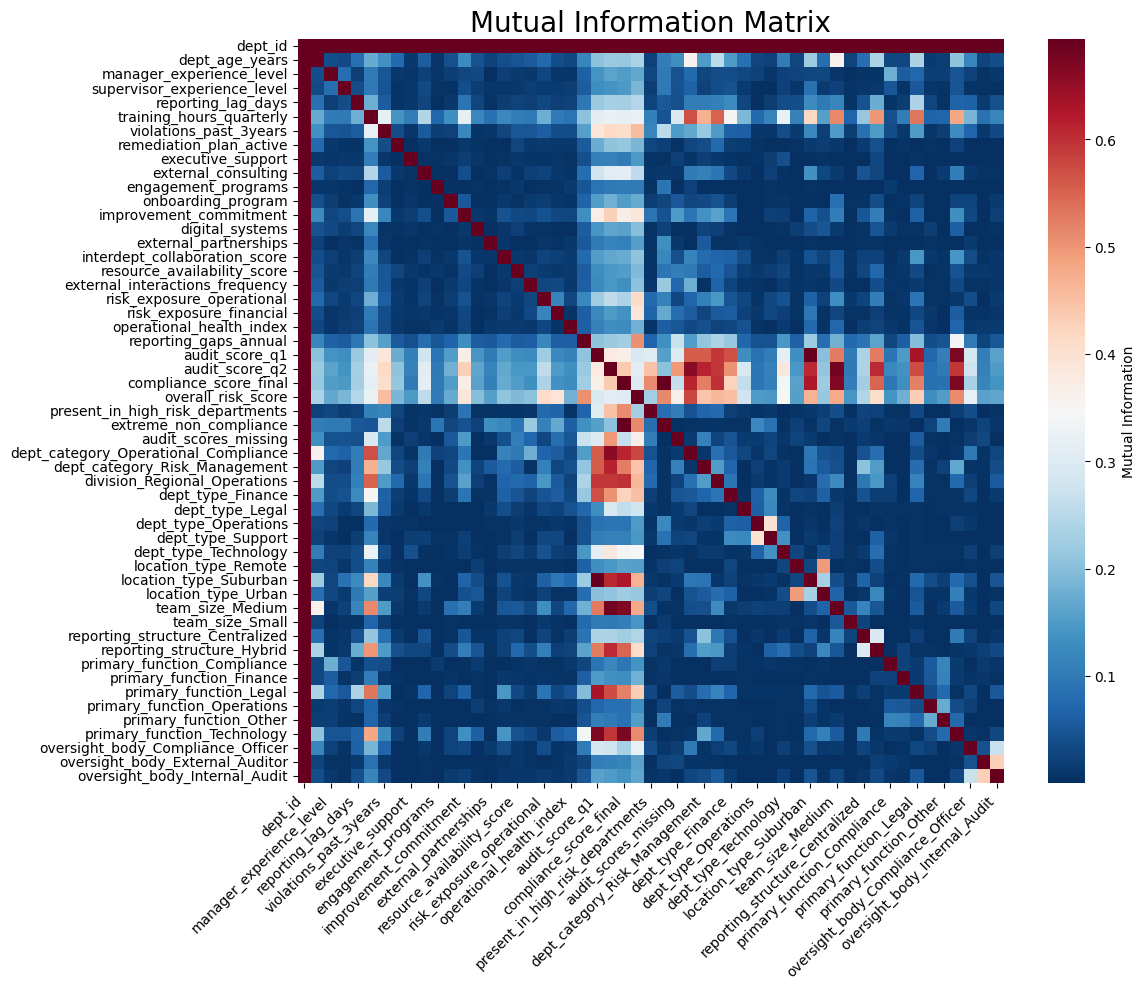

In [85]:
# 2. Heatmap with Seaborn

plt.figure(figsize=(12, 10))
sns.heatmap(mi_matrix, cmap="RdBu_r", annot=False, cbar_kws={'label': 'Mutual Information'})
plt.title("Mutual Information Matrix", fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---

In [86]:
# 1. Define target and features

y = departments['compliance_score_final']          # target variable
X = departments.drop(columns=['compliance_score_final', 'dept_id'])  # features (no ID)

In [87]:
# 2. Detect task type
is_classification = y.dtype.name == 'category' or y.nunique() < 10

# 3. Compute MI with fixed random_state
if is_classification:
    mi = mutual_info_classif(
        X, y,
        discrete_features='auto',
        random_state=42     # FIXED SEED ✔️
    )
else:
    mi = mutual_info_regression(
        X, y,
        discrete_features='auto',
        random_state=42     # FIXED SEED ✔️
    )

# Convert to series
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

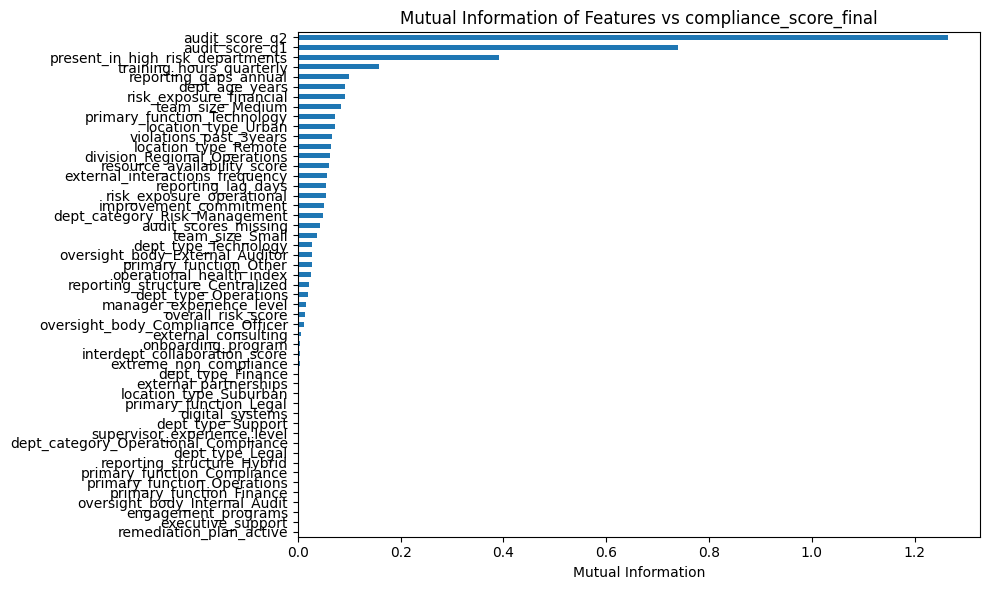

In [88]:
# ------------------------------
# 4. Plot MI
# ------------------------------
plt.figure(figsize=(10, 6))
mi_series.sort_values(ascending=True).plot(kind='barh')
plt.title("Mutual Information of Features vs compliance_score_final")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()


In [89]:
# ------------------------------
# 5. Select features above MI threshold
# ------------------------------
selected_features = mi_series[mi_series > 0.01].index.tolist()
X_reduced = X[selected_features]

print("\nSelected features:", selected_features)


Selected features: ['audit_score_q2', 'audit_score_q1', 'present_in_high_risk_departments', 'training_hours_quarterly', 'reporting_gaps_annual', 'dept_age_years', 'risk_exposure_financial', 'team_size_Medium', 'primary_function_Technology', 'location_type_Urban', 'violations_past_3years', 'location_type_Remote', 'division_Regional_Operations', 'resource_availability_score', 'external_interactions_frequency', 'reporting_lag_days', 'risk_exposure_operational', 'improvement_commitment', 'dept_category_Risk_Management', 'audit_scores_missing', 'team_size_Small', 'dept_type_Technology', 'oversight_body_External_Auditor', 'primary_function_Other', 'operational_health_index', 'reporting_structure_Centralized', 'dept_type_Operations', 'manager_experience_level', 'overall_risk_score', 'oversight_body_Compliance_Officer']


In [90]:
# ------------------------------
# 6. Identify dropped features
# ------------------------------
dropped_features = [col for col in X.columns if col not in selected_features]
print("\nDropped features:", dropped_features)


Dropped features: ['supervisor_experience_level', 'remediation_plan_active', 'executive_support', 'external_consulting', 'engagement_programs', 'onboarding_program', 'digital_systems', 'external_partnerships', 'interdept_collaboration_score', 'extreme_non_compliance', 'dept_category_Operational_Compliance', 'dept_type_Finance', 'dept_type_Legal', 'dept_type_Support', 'location_type_Suburban', 'reporting_structure_Hybrid', 'primary_function_Compliance', 'primary_function_Finance', 'primary_function_Legal', 'primary_function_Operations', 'oversight_body_Internal_Audit']


In [91]:
# ------------------------------
# 7. Reattach dept_id + target to make the final dataset
# ------------------------------
departments_selected = pd.concat(
    [
        departments[['dept_id']],         # return dept_id
        X_reduced,                         # selected predictive features
        departments[['compliance_score_final']]  # target
    ],
    axis=1
)

print("\nFinal dataset shape:", departments_selected.shape)
departments = departments_selected.copy()
departments.head(2)


Final dataset shape: (424, 32)


dept_id  audit_score_q2  audit_score_q1  \
0  DEPT-1003        0.204688       -0.163561   
4  DEPT-1066        0.204688        0.242945   

   present_in_high_risk_departments  training_hours_quarterly  \
0                                 0                  0.057076   
4                                 0                  0.973154   

   reporting_gaps_annual  dept_age_years  risk_exposure_financial  \
0              -1.266665        0.733198                -1.029951   
4              -0.177868       -1.089808                -1.029951   

   team_size_Medium  primary_function_Technology  ...  dept_type_Technology  \
0                 0                            0  ...                     0   
4                 0                            0  ...                     0   

   oversight_body_External_Auditor  primary_function_Other  \
0                                0                       1   
4                                0                       0   

   operational_health_index  reporting_structure_Centralized  \
0                  0.327411                                1   
4                  1.050442                                1   

   dept_type_Operations  manager_experience_level  overall_risk_score  \
0                     0                 -1.486610           -0.295272   
4                     0                  0.306627           -0.846065   

   oversight_body_Compliance_Officer  compliance_score_final  
0                                  0                    65.0  
4                                  0                    65.0  

[2 rows x 32 columns]

# **MODELING**

1. **Train three models to identify which departments are non-compliant**

- We set a threshold (from summary statistic) for non-compliance.
- Train Logistic Regression, SVC, and HGB to identify which non-compliance.
- Compare three models and choose the best.

2. **For the best model, discover which variables are strongly associated with non-compliance. Based on them, create a non-compliance framework**

---

## **1. Training models and selecting the best**

Looking at the data distribution in Summary Statistics, we see that 25% of data lies under compliance_score_final = 55. Therefore, we define it as a theshold.

---

In [92]:
threshold = 55
departments['non_compliant'] = (departments['compliance_score_final'] < threshold).astype(int)

---
To compare non-complaint departments with compliant departments, we split the table into two tables:compliant_depts and non_compliant_depts.

---

In [93]:
non_compliant_depts = departments[departments['non_compliant'] == 1]
compliant_depts = departments[departments['non_compliant'] == 0]

---
Target variable: 1 if compliance_score_final < 55 (non-compliant), 0 otherwise.
Data was already standardised earlier.

---

In [94]:
y = departments['non_compliant']
X = departments.drop(columns=['compliance_score_final', 'non_compliant', 'dept_id'])

# List of all features for scaling
numerical_features = X.columns.tolist()

---
Create model pipelines and hyperparameter grids

---

In [95]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('clf', LogisticRegression(solver='liblinear', random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('clf', GradientBoostingClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('clf', SVC(probability=True, random_state=42))
    ])
}

#hyperparameter grids
param_grids = {
    'LogisticRegression': {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__penalty': ['l1', 'l2'],
        'clf__class_weight': [None, 'balanced']
    },

    'GradientBoosting': {
        'clf__n_estimators': [100, 200],
        'clf__learning_rate': [0.03, 0.05, 0.1],
        'clf__min_samples_leaf': [5, 10],
        'clf__max_depth': [3, 4],
        'clf__subsample': [0.8, 0.9]
    },

    'SVM': {
        'clf__C': [0.5, 1, 10],
        'clf__kernel': ['rbf'],
        'clf__gamma': ['scale', 0.1]
    }
}

---
Set up 5-fold cross-validation, making sure each fold keeps the same proportion of compliant vs non-compliant departments (Stratified).

---

In [96]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

---
We go through each model (Logistic Regression, Gradient Boosting, SVM) one by one.

We are testing different settings for each model using cross-validation, seeing which settings give the best ROC AUC, and keeping those “best versions” for later evaluation and comparison.

---

In [97]:
results = {}
for name, pipe in pipelines.items():
    print(f"\n--- Tuning {name} ---")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X, y)

    # Store best model and score
    results[name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'model': grid.best_estimator_
    }

    print(f"{name} Best ROC AUC (CV Score): {grid.best_score_:.4f}")


--- Tuning LogisticRegression ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
LogisticRegression Best ROC AUC (CV Score): 0.9546

--- Tuning GradientBoosting ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits
GradientBoosting Best ROC AUC (CV Score): 0.9491

--- Tuning SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVM Best ROC AUC (CV Score): 0.9414


---
Use best estimators for CV metrics

---

In [98]:
model_pipelines = {name: res['model'] for name, res in results.items()}

scorers = {
    'Accuracy': 'accuracy',
    'Precision': make_scorer(precision_score, pos_label=1),
    'Recall': make_scorer(recall_score, pos_label=1),
    'F1': make_scorer(f1_score, pos_label=1),
    'ROC-AUC': 'roc_auc'
}

cv_results_final = {}

for name, model in model_pipelines.items():
    scores = {}
    for metric_name, scorer in scorers.items():
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)
        scores[metric_name] = cv_scores.mean()
    cv_results_final[name] = scores

# Final comparison table
cv_df = pd.DataFrame.from_dict(cv_results_final, orient='index').round(4)
cv_df = cv_df.sort_values(by='F1', ascending=False)
print("\n--- Final Model Comparison (Mean CV Scores) ---")
display(cv_df)


--- Final Model Comparison (Mean CV Scores) ---


Accuracy  Precision  Recall      F1  ROC-AUC
LogisticRegression    0.9198     0.8817  0.6708  0.7557   0.9546
GradientBoosting      0.9057     0.7608  0.7483  0.7446   0.9491
SVM                   0.8821     0.8339  0.4575  0.5774   0.9414

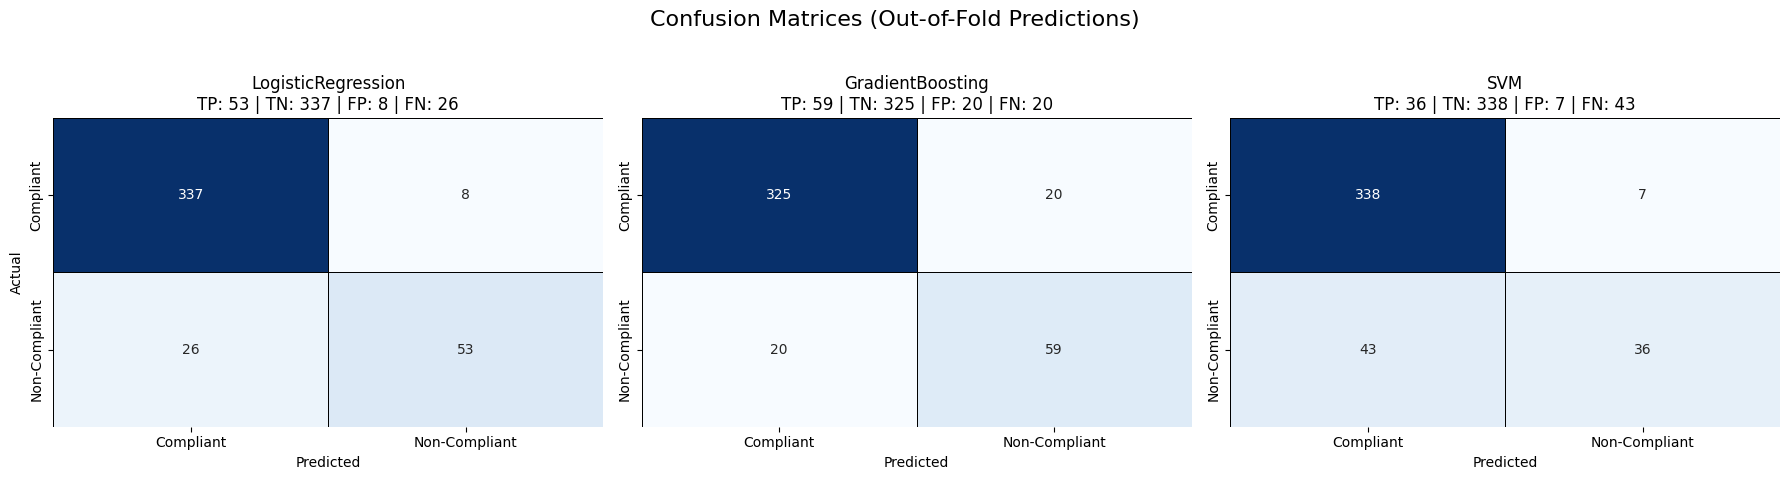

In [99]:
# Confusion matrices for each model using cross_val_predict
fig, axes = plt.subplots(1, len(model_pipelines), figsize=(18, 5))
plt.suptitle('Confusion Matrices (Out-of-Fold Predictions)', fontsize=16)

for i, (name, res) in enumerate(results.items()):
    model = res['model']
    y_pred_oof = cross_val_predict(model, X, y, cv=cv, method='predict', n_jobs=-1)
    cm = confusion_matrix(y, y_pred_oof)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Compliant', 'Non-Compliant'],
        yticklabels=['Compliant', 'Non-Compliant'],
        cbar=False,
        linewidths=.5,
        linecolor='black',
        ax=axes[i]
    )

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    axes[i].set_title(f"{name}\nTP: {TP} | TN: {TN} | FP: {FP} | FN: {FN}", fontsize=12)
    axes[i].set_xlabel('Predicted')
    if i == 0:
        axes[i].set_ylabel('Actual')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

---
Initially, Logistic Regression performed at approximately the same level as HistGradientBoosting. However, because Logistic Regression is more interpretable and better suited for downstream analysis, we focused on improving it through hyperparameter tuning. The optimized results are shown above.

After model comparison, two algorithms stand out:

HistGradientBoosting
- Achieves the highest Recall, which is important for identifying positive cases.

Logistic Regression
- Highest ROC-AUC (0.9546)
- Strong Accuracy
- Higher Precision and F1-score
- More stable and interpretable coefficients

Given this combination of performance and interpretability, we select Logistic Regression as the final model. It offers the best balance between predictive quality, stability, and practical interpretability, making it the most suitable choice for our analysis.

---


Fit Logistic Regression on the entire dataset

---

In [100]:
# Pick Logistic Regression as the final model based on CV metrics
final_model = Pipeline([
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Fit on the entire dataset
final_model.fit(X, y)

Pipeline(steps=[('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

---
Overfitting check

---

In [101]:
# Cross-validated metrics with training vs CV scores
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring, return_train_score=True)

pd.DataFrame(cv_results).round(4)

fit_time  score_time  test_roc_auc  train_roc_auc  test_accuracy  \
0     0.008       0.037        0.9321         0.9780         0.8706   
1     0.016       0.063        0.9801         0.9691         0.9412   
2     0.010       0.039        0.9574         0.9739         0.9176   
3     0.010       0.034        0.9339         0.9776         0.9294   
4     0.007       0.040        0.9353         0.9766         0.9048   

   train_accuracy  test_precision  train_precision  test_recall  train_recall  \
0          0.9499          0.7273           0.8710       0.5000        0.8571   
1          0.9263          0.8235           0.8276       0.8750        0.7619   
2          0.9322          0.7143           0.8571       0.9375        0.7619   
3          0.9292          1.0000           0.8305       0.6250        0.7778   
4          0.9353          0.6842           0.8621       0.8667        0.7812   

   test_f1  train_f1  
0   0.5926    0.8640  
1   0.8485    0.7934  
2   0.8108    0.8067  
3   0.7692    0.8033  
4   0.7647    0.8197

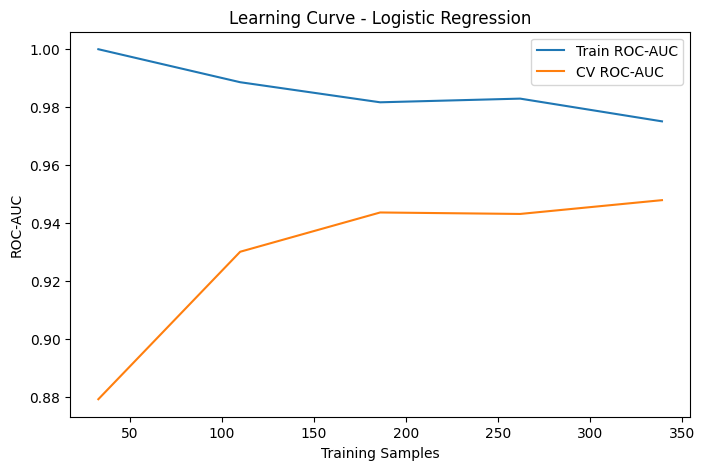

In [102]:
train_sizes, train_scores, test_scores = learning_curve(
    final_model, X, y, cv=cv, scoring='roc_auc'
)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train ROC-AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), label='CV ROC-AUC')
plt.xlabel("Training Samples")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve - Logistic Regression")
plt.legend()
plt.show()

---
There are some signs of overfitting, however, the gap between training and test is still moderate (about 0.026).

---

## **2. Framework creation based on Logistic Regression**

### **Main Idea**

As a result of Logistic Regression, the model outputs a probability.
The framework uses Logistic Regression to estimate the Non-Compliance Risk P̂. Before producing this probability, the model first computes a raw value called the log-odds or Z-score. This Z-score can range from negative to positive infinity, because it is a linear combination of all input features.

To convert this unbounded value into a probability between 0 and 1, Logistic Regression applies the logistic (sigmoid) function.The result P̂ is interpreted as the **Non-Compliance Risk**, i.e., the model’s estimated probability that a department belongs to the high-risk category.

In practical terms, the non_compliance_risk variable shows how close a department is to becoming non-compliant. If the risk is above a certain threshold (we define it later), the department is approaching the danger zone and should adjust its weakest factor immediately. If the risk is 20% or lower, the department is not in urgent danger but should continue active monitoring and focused improvement.

---

### **Overwiew**

**We combine statistical knowlesge and Logistic Regression model to receive a table containing the following information:**

- **dept_id**: ID of a Departament
- **non_compliance_prediction**: Predicted by LR class 'compliant/non-compliant'
- **status**: Status of **Risk to be non-compliant** 'High/Medium/Low'
- **non_compliance_risk (%)**: **Risk to be non-compliant** in percent
- **target_risk_level**: **Risk** improvement target, lower risk status: 'Medium/Low'
- **optimal_action_portfolio**: What to improve and how much to achieve risk target.
- **risk_driver**: top 5 drivers of risk.

---

### **Creation Process**

#### **1. Preparation**

---
Define Features and Data

---

In [103]:
COLUMNS_TO_EXCLUDE = ['compliance_score_final', 'non_compliant', 'dept_id']

y = departments['non_compliant']
X = departments.drop(columns=COLUMNS_TO_EXCLUDE, errors='ignore') # Feature matrix (already scaled)
all_input_features = X.columns.tolist()

---
Since we want the output to be readable and easily interpretable, we need to unscale previousely standardized variables. To do it later, we define the features that were standardized previously

---

In [104]:
# Define the features that were standardized previously (essential for unscaling)
continuous_counts = [
    'dept_age_years', 'reporting_lag_days', 'training_hours_quarterly',
    'violations_past_3years', 'reporting_gaps_annual'
]
float_scores = [ 'audit_score_q1', 'audit_score_q2', 'overall_risk_score']
ordinal_scores = [
    'manager_experience_level', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational',
    'risk_exposure_financial', 'operational_health_index'
]
to_standardize = continuous_counts + float_scores + ordinal_scores

---
Then we need to classify discrete and continueous variables for later round them and give proper recommendations.

Example: Violations cannot be decreased from 3 to 1.3 to reduce risk. But they can be decreased either to 1 or to 2.

---

In [105]:
MEASURABLE_FEATURES = [
    'dept_age_years', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'resource_availability_score', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'reporting_gaps_annual',
    'audit_score_q1', 'audit_score_q2', 'overall_risk_score'
]

DISCRETE_NUMERIC_FEATURES = [
    'dept_age_years', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'resource_availability_score', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'reporting_gaps_annual'
]

---
We already fitted our scaled data to the whole dataset previousely. Now we extract coefficients that LR used to distinct non-compliant from compliant, they determine non-compliance risk.
We also take the data used to train the model.

---

In [106]:
logreg_model = final_model.named_steps['classifier']
X_scaled_df = pd.DataFrame(X, columns=X.columns, index=departments.index)

# Extract Coefficients
coeff_series = pd.Series(logreg_model.coef_[0], index=X.columns)

---
We create a 'translation key' that converts the model's scaled language (Standard Deviations) back into real-world scores (e.g., Audit Score from 80 to 95).

---

In [107]:
# Reconstruct scaler_params from the global 'scaler' object (fitted earlier)
scaler_params_data = {}
for feature in all_input_features:
    if feature in to_standardize:
        try:
            idx = to_standardize.index(feature)
            scaler_params_data[feature] = {'mean': scaler.mean_[idx], 'std': scaler.scale_[idx]}
        except ValueError:
             scaler_params_data[feature] = {'mean': 0.0, 'std': 1.0} # Should not happen if to_standardize is correct
    else:
        scaler_params_data[feature] = {'mean': 0.0, 'std': 1.0} # For binary, dummy, log-transformed features not in 'to_standardize'

scaler_params = pd.DataFrame(scaler_params_data).T.loc[MEASURABLE_FEATURES].copy() #only include Measurable Features


#### **2. Column 'non_compliance_risk'**


---
As a result of Logistic Regression, the model outputs a probability. We will use Logistic Regression to estimate the Non-Compliance Risk P̂.

Before producing this probability, the model first computes a raw value (log-odds or Z-score). This Z-score can range from negative to positive infinity, because it is a linear combination of all input features.

To convert this unbounded value into a probability between 0 and 1, Logistic Regression applies the logistic (sigmoid) function.

The result P̂ is interpreted as the **Non-Compliance Risk**, i.e., the model’s estimated probability that a department belongs to the high-risk category.

---

In [108]:
departments['non_compliance_risk'] = final_model.predict_proba(X)[:, 1]

#### **3. Column 'non_compliance_prediction'**

In [109]:
departments['non_compliance_prediction'] = np.where(
    final_model.predict(X) == 1,
    '🔴 Non-Compliant',
    '🟢 Compliant'
)

#### **4. Column 'status'**

To define a status of the risk, we need to understand which risk can be considered high, medium, and low. To do it properly, we use K-mean clustering (K = 3 ). We cluster departments based on their Non-Compliance Risk.

In [110]:
kmeans = KMeans(n_clusters=3, random_state=42)
departments['risk_cluster'] = kmeans.fit_predict(departments[['non_compliance_risk']])

cluster_means = departments.groupby('risk_cluster')['non_compliance_risk'].mean().sort_values()
cluster_mapping = {cluster: label for cluster, label in zip(
    cluster_means.index, ['Low Risk 🟢', 'Medium Risk 🟡', 'High Risk 🔴']
)}

departments['risk_cluster_label'] = departments['risk_cluster'].map(cluster_mapping)

risk_centroids = departments.groupby('risk_cluster_label')['non_compliance_risk'].mean().loc[
    ['Low Risk 🟢', 'Medium Risk 🟡', 'High Risk 🔴']
]
centroid_data = pd.DataFrame({
    'non_compliance_risk': risk_centroids.values,
    'x_pos': [np.mean(departments[departments['risk_cluster_label'] == label].index)
              for label in risk_centroids.index]
}, index=risk_centroids.index)


C:\Users\Valerija\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Valerija\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Valerija\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


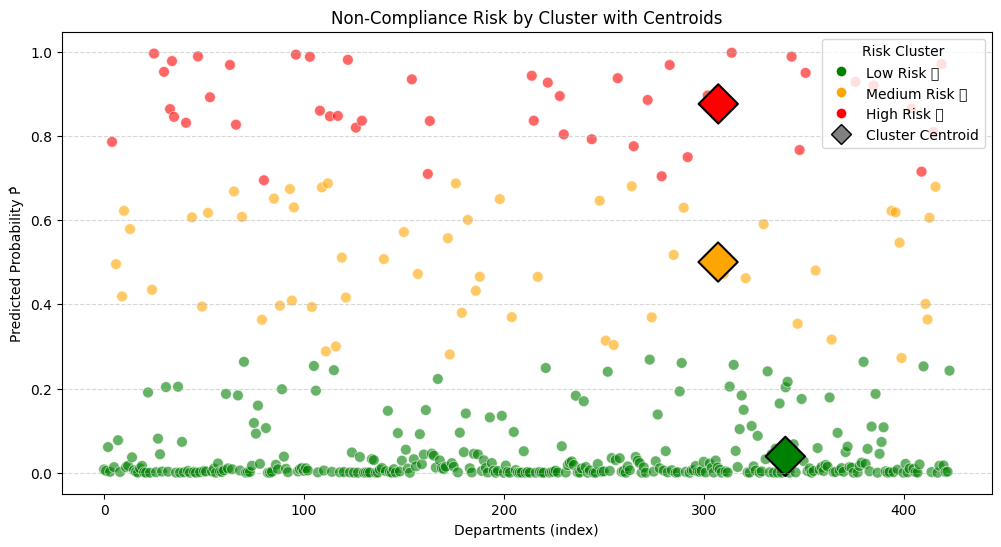

In [111]:
# Visualization
plt.figure(figsize=(12, 6))

sns.scatterplot(
    x=range(len(departments)),
    y='non_compliance_risk',
    hue='risk_cluster_label',
    palette={'Low Risk 🟢':'green', 'Medium Risk 🟡':'orange', 'High Risk 🔴':'red'},
    data=departments,
    s=60,
    legend=False,
    alpha=0.6
)

plt.scatter(
    x=[np.mean(departments[departments['risk_cluster_label'] == label].index)
       for label in risk_centroids.index],
    y=risk_centroids.values,
    s=400,
    marker='D',
    color=risk_centroids.index.map({'Low Risk 🟢':'green', 'Medium Risk 🟡':'orange', 'High Risk 🔴':'red'}),
    edgecolor='black',
    linewidth=1.5,
    label='Cluster Centroid'
)

plt.title("Non-Compliance Risk by Cluster with Centroids")
plt.ylabel("Predicted Probability P̂")
plt.xlabel("Departments (index)")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Low Risk 🟢', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Medium Risk 🟡', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='High Risk 🔴', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='D', color='w', label='Cluster Centroid', markerfacecolor='gray', markeredgecolor='black', markersize=10),
]
plt.legend(handles=legend_elements, title="Risk Cluster")

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

> (the error appears because of using 🟢, 🟡, 🔴 )

In [112]:
centers = kmeans.cluster_centers_.flatten()
centers.sort()

low_to_med = (centers[0] + centers[1]) / 2
med_to_high = (centers[1] + centers[2]) / 2

print("Low/Medium border:", low_to_med)
print("Medium/High border:", med_to_high)

Low/Medium border: 0.2696937768255811
Medium/High border: 0.6883563743286767


Now having the thresholds, we can define a risk status for each department.

In [113]:
# Generate the current categorical status
HIGH_RISK_THRESHOLD = 0.6883563743286831
MEDIUM_RISK_THRESHOLD = 0.26969377682558604

def define_risk_status(risk_P):
    if risk_P >= HIGH_RISK_THRESHOLD:
        return '🔴 High Risk'
    elif risk_P >= MEDIUM_RISK_THRESHOLD:
        return '🟡 Medium Risk'
    else:
        return '🟢 Low Risk'


departments['status'] = departments['non_compliance_risk'].apply(define_risk_status)

#### **4. Columns 'target_risk_level'**

Target level is a level higher that the current risk status.

In [114]:
def define_target_risk(current_status):
    if current_status == '🔴 High Risk':
        return "🟡  Medium Risk (69%)"
    elif current_status == '🟡 Medium Risk':
        return "🟢 Low Risk (27%)"
    else: # '🟢 Low Risk'
        return "Maintain good results!"

departments['target_risk_level'] = departments['status'].apply(define_target_risk)

#### **5. Columns 'optimal_sctions_portfolio' and 'risk_driver'**

In [115]:
# Define the core Prescriptive Analysis function
def generate_prescriptive_output_combined(
    row, X_scaled_df, coeff_series, scaler_params, logreg_model,
    MEASURABLE_FEATURES, DISCRETE_NUMERIC_FEATURES
):

    current_status = row['status']

    if current_status == '🟢 Low Risk':
        return "Monitor risk drivers. Goal: Maintain Low Risk.", "None identified (Low Risk)."

    current_P = row['non_compliance_risk']
    scaled_features = X_scaled_df.loc[row.name]

    # Contribution: How much each feature adds to the Log-Odds (L)
    contributions = scaled_features * coeff_series

    # Risk Drivers: Features with positive contribution to risk (L)
    red_flags = contributions[contributions > 0].sort_values(ascending=False)

    # --- Part 1: Risk Drivers String (Top 5) ---
    risk_drivers_list = []
    if not red_flags.empty:
        total_positive_contribution = red_flags.sum()
        top_5 = red_flags.head(5)
        for i, (feat, val) in enumerate(top_5.items()):
            # Calculate the percentage contribution to the total positive log-odds
            risk_drivers_list.append(f"{i+1}. {feat} ({(val/total_positive_contribution)*100:.1f}%)")
    risk_drivers_str = "; ".join(risk_drivers_list) if risk_drivers_list else "None identified."

    # --- Part 2: Action Goal Setting (Calculate Target Change) ---

    # Set GRADUATED P_target (must match Cell 3's target)
    if current_status == '🔴 High Risk':
        P_target = HIGH_RISK_THRESHOLD
    elif current_status == '🟡 Medium Risk':
        P_target = MEDIUM_RISK_THRESHOLD

    # Logit transformation of the target probability
    L_target = np.log(P_target / (1 - P_target))
    current_L = logreg_model.intercept_[0] + contributions.sum()
    # Delta L is the total change in log-odds needed to reach the target L
    delta_L_needed = current_L - L_target

    # Identify the TOP 3 MEASURABLE risk factors for the portfolio
    top_measurable_drivers = [f for f in red_flags.index if f in MEASURABLE_FEATURES][:3]

    portfolio_options = []

    for top_feature in top_measurable_drivers:
        if top_feature not in scaler_params.index:
            continue

        beta_i = coeff_series[top_feature]

        # Calculate the required change in SCALED units (delta_x_scaled) to achieve delta_L_needed
        delta_x_scaled = delta_L_needed / beta_i
        x_scaled = scaled_features[top_feature]
        x_target_scaled = x_scaled - delta_x_scaled # Target = Current - Change (since delta_L_needed is positive for risk reduction)

        # Unscale: Convert scaled scores back to REAL-WORLD UNITS
        mean, std = scaler_params.loc[top_feature, ['mean', 'std']]
        x_current = x_scaled * std + mean
        x_target = x_target_scaled * std + mean

        # Determine if the action is to decrease or increase the raw feature value
        action = "decrease" if beta_i > 0 else "increase"

        # Apply rounding for discrete features
        if top_feature in DISCRETE_NUMERIC_FEATURES:
            x_current = round(x_current)
            x_target = round(x_target)
            fmt = "{:.0f}"
        else:
            fmt = "{:.1f}"

        if x_target < 0: x_target = 0
        if not np.isfinite(x_target): x_target = x_current

        portfolio_options.append(
            f"{action.capitalize()} **{top_feature}** from **{fmt.format(x_current)}** to **{fmt.format(x_target)}**."
        )

# --- Part 3: Construct Final Action String (Formatted for Managers) ---

    if not portfolio_options:
        action_goal_str = "Critical: Top risk is non-measurable. Seek strategic or structural changes."
    else:

        # Prepare nicely formatted bullet points
        bullets = "\n".join([f"• {opt}" for opt in portfolio_options])

        action_goal_str = (
            f"Option 1 — Single Action\n"
            f"{bullets.splitlines()[0]}\n\n"
            f"Option 2 — Portfolio (Multiple Actions)\n"
            f"Required changes:\n"
            f"{bullets}"
        )
    return action_goal_str, risk_drivers_str

In [116]:
# Apply the function and unpack results
results = departments.apply(
    lambda row: generate_prescriptive_output_combined(
        row, X_scaled_df, coeff_series, scaler_params, logreg_model,
        MEASURABLE_FEATURES, DISCRETE_NUMERIC_FEATURES
    ),
    axis=1,
    result_type='expand'
)
#rename
departments['optimal_action_portfolio'] = results[0]
departments['risk_drivers'] = results[1]

#### **6. Final formatted report table**

In [117]:
final_table = departments.copy()

final_table = final_table.sort_values(by='non_compliance_risk', ascending=False)
final_table['non_compliance_risk (%)'] = final_table['non_compliance_risk'].apply(lambda x: f"{x:.1%}")

# Drop the original numeric risk column since the sorting is complete
final_table = final_table.drop(columns=['non_compliance_risk'])

FINAL_COLUMN_ORDER = [
    'dept_id',
    'non_compliance_prediction',
    'status',
    'non_compliance_risk (%)',
    'target_risk_level',
    'optimal_action_portfolio',
    'risk_drivers'
]

final_report = final_table[FINAL_COLUMN_ORDER]

pd.set_option('display.max_rows', 426)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

final_report.head(426)

dept_id non_compliance_prediction         status non_compliance_risk (%)       target_risk_level                                                                                                                                                                                                                                                                                                                   optimal_action_portfolio                                                                                                                                                                          risk_drivers
500  DEPT-7715           🔴 Non-Compliant    🔴 High Risk                   99.8%    🟡  Medium Risk (69%)           Option 1 — Single Action\n• Increase **audit_score_q2** from **40.0** to **71.6**.\n\nOption 2 — Portfolio (Multiple Actions)\nRequired changes:\n• Increase **audit_score_q2** from **40.0** to **71.6**.\n• Decrease **violations_past_3years** from **1** to **0**.\n• Increase **audit_score_q1** from **40.0** to **96.1**.           1. audit_score_q2 (35.3%); 2. violations_past_3years (23.7%); 3. audit_score_q1 (19.6%); 4. present_in_high_risk_departments (11.6%); 5. resource_availability_score (4.7%)
41   DEPT-1584           🔴 Non-Compliant    🔴 High Risk                   99.6%    🟡  Medium Risk (69%)           Option 1 — Single Action\n• Increase **audit_score_q2** from **35.0** to **62.9**.\n\nOption 2 — Portfolio (Multiple Actions)\nRequired changes:\n• Increase **audit_score_q2** from **35.0** to **62.9**.\n• Decrease **violations_past_3years** from **1** to **0**.\n• Increase **audit_score_q1** from **40.0** to **89.5**.           1. audit_score_q2 (41.3%); 2. violations_past_3years (22.6%); 3. audit_score_q1 (18.7%); 4. present_in_high_risk_departments (11.0%); 5. resource_availability_score (4.5%)
155  DEPT-2992           🔴 Non-Compliant    🔴 High Risk                   99.3%    🟡  Medium Risk (69%)        Option 1 — Single Action\n• Increase **audit_score_q2** from **35.0** to **60.0**.\n\nOption 2 — Portfolio (Multiple Actions)\nRequired changes:\n• Increase **audit_score_q2** from **35.0** to **60.0**.\n• Increase **audit_score_q1** from **35.0** to **79.3**.\n• Increase **overall_risk_score** from **10.0** to **188.6**.                   1. audit_score_q2 (49.4%); 2. audit_score_q1 (27.5%); 3. present_in_high_risk_departments (13.2%); 4. overall_risk_score (4.1%); 5. manager_experience_level (1.9%)
74   DEPT-2037           🔴 Non-Compliant    🔴 High Risk                   98.9%    🟡  Medium Risk (69%)        Option 1 — Single Action\n• Increase **audit_score_q2** from **40.0** to **62.0**.\n\nOption 2 — Portfolio (Multiple Actions)\nRequired changes:\n• Increase **audit_score_q2** from **40.0** to **62.0**.\n• Increase **audit_score_q1** from **35.0** to **74.0**.\n• Increase **overall_risk_score** from **10.0** to **167.3**.                   1. audit_score_q2 (42.4%); 2. audit_score_q1 (28.9%); 3. present_in_high_risk_departments (13.9%); 4. overall_risk_score (4.3%); 5. operational_health_index (3.0%)
540  DEPT-8278           🔴 Non-Compliant    🔴 High Risk                   98.9%    🟡  Medium Risk (69%)           Option 1 — Single Action\n• Increase **audit_score_q2** from **40.0** to **61.7**.\n\nOption 2 — Portfolio (Multiple Actions)\nRequired changes:\n• Increase **audit_score_q2** from **40.0** to **61.7**.\n• Increase **audit_score_q1** from **35.0** to **73.6**.\n• Decrease **violations_past_3years** from **1** to **0**.       1. audit_score_q2 (37.7%); 2. audit_score_q1 (25.7%); 3. violations_past_3years (19.2%); 4. present_in_high_risk_departments (12.3%); 5. external_interactions_frequency (1.8%)
162  DEPT-3061           🔴 Non-Compliant    🔴 High Risk                   98.8%    🟡  Medium Risk (69%)           Option 1 — Single Action\n• Increase **audit_score_q2** from **40.0** to **61.5**.\n\nOption 2 — Portfolio (Multiple Actions)\nRequired changes:\n• Increase **audit_score_q2** from **40.0** t

**Suggestions output example for a department with index '162'**

In [118]:
print('---Top 5 Risk Drivers---')
print(final_report.loc[162, 'risk_drivers'])
print('\n ---Optimal Action Portfolio---')
print(final_report.loc[162, 'optimal_action_portfolio'])

---Top 5 Risk Drivers---
1. audit_score_q2 (33.9%); 2. audit_score_q1 (23.1%); 3. violations_past_3years (22.8%); 4. present_in_high_risk_departments (11.1%); 5. operational_health_index (2.4%)

 ---Optimal Action Portfolio---
Option 1 — Single Action
• Increase **audit_score_q2** from **40.0** to **61.5**.

Option 2 — Portfolio (Multiple Actions)
Required changes:
• Increase **audit_score_q2** from **40.0** to **61.5**.
• Increase **audit_score_q1** from **35.0** to **73.2**.
• Decrease **violations_past_3years** from **1** to **0**.


### **Interpretation guide**

---
**Condition 1**

- Non-compliant
- Risk Level: High Risk
- Predicted Non-Compliance Probability (P̂): > 69%
- Target Status: Medium Risk
- Recommended Actions: (list of feature changes)

**Interpretation**

This department is already failing compliance now and the model sees a very high chance it will continue to fail if nothing changes.
The situation is urgent.
The actions shown are the fastest and most effective steps to bring the department down to Medium Risk.
They are real, measurable adjustments—things the department can actually change.

---

**Condition 2**

- Non-compliant
- Risk Level: Medium Risk
- Predicted Non-Compliance Probability (P̂): 27%–69%
- Target Status: Low Risk
- Recommended Actions: (list of feature changes)

**Interpretation**

The department did not meet compliance requirements this time, but it is not far from improving.
The model sees a moderate chance of future non-compliance.
With the recommended actions, the department can realistically reach Low Risk and stay compliant next cycle.

---

**Condition 3**

- Compliant
- Risk Level: Medium Risk
- Predicted Non-Compliance Probability (P̂): 27%–69%
- Target Status: Low Risk
- Recommended Actions: (list of feature changes)

**Interpretation**

The department passed compliance this cycle, but the model sees a moderate risk that it could fail next time.
This is an area that needs proactive improvement, not emergency action.
If the suggested steps are followed, the department can reach Low Risk.

---

**Condition 4**

- Compliant
- Risk Level: Low Risk
- Predicted Non-Compliance Probability (P̂): < 27%
- Target Status: Low Risk (maintain)
- Recommended Actions: None required

**Interpretation**

The department is doing well and the risk of future non-compliance is very low.
No major changes needed.
This is an example of stable, healthy performance.

---

### **Quick Framework Creation Map**

In [119]:
import pandas as pd

# Define the columns generated by the ML pipeline to be transferred
ML_COLUMNS_TO_ADD = [
    'non_compliant',
    'non_compliance_risk',
    'non_compliance_prediction',
    'risk_cluster',
    'risk_cluster_label',
    'status',
    'target_risk_level',
    'optimal_action_portfolio',
    'risk_drivers'
]

# --- 1. Select the columns to be transferred from the 'departments' table ---
# We use .copy() to ensure we are working with a new DataFrame chunk
ml_results = departments[ML_COLUMNS_TO_ADD].copy()


# --- 2. Perform the Merge Operation (Consolidation) ---

# We use a left merge:
# 1. 'departments_not_encoded' is the left table (keeps all its rows).
# 2. It looks for matches in 'ml_results' (right table) based on the index (on='index').
# 3. 'how="left"' ensures that if a department exists in 'departments_not_encoded' but was somehow
#    missed in the ML pipeline (unlikely in this flow, but good practice), it is kept,
#    though its new columns will be NaN.

# Note: Since your logic stated "if not [in departments_not_encoded] - drop this department"
# and we assume 'departments_not_encoded' is your final target size, a LEFT merge is correct.
# If you wanted ONLY the intersection, you would use how='inner'.

departments_raww = pd.merge(
    departments_raww,
    ml_results,
    left_index=True,  # Merge based on the index of departments_not_encoded
    right_index=True, # Merge based on the index of ml_results
    how='left'        # Keep all rows from departments_not_encoded
)

# --- 3. Verification and Cleanup ---

# Check for any missing ML results (should be very few/none)
if departments_raww[ML_COLUMNS_TO_ADD].isnull().any(axis=None):
    print("\n⚠️ Warning: Some departments in the final table are missing ML results (NaNs).")

print("\n✅ Data consolidation complete.")
print(f"Final table size: {len(departments_raww)} departments.")
print("The following ML columns have been added to departments_not_encoded:")
print(ML_COLUMNS_TO_ADD)

# Display a preview of the new columns
print(departments_raww[ML_COLUMNS_TO_ADD].head())


✅ Data consolidation complete.
Final table size: 424 departments.
The following ML columns have been added to departments_not_encoded:
['non_compliant', 'non_compliance_risk', 'non_compliance_prediction', 'risk_cluster', 'risk_cluster_label', 'status', 'target_risk_level', 'optimal_action_portfolio', 'risk_drivers']
   non_compliant  non_compliance_risk non_compliance_prediction  risk_cluster risk_cluster_label       status       target_risk_level                                                                                                                                                                                                                                                                                                            optimal_action_portfolio                                                                                                                                                                 risk_drivers
0              0             0.007782             

In [120]:
departments_raww

dept_id           dept_category             division   dept_type  dept_age_years  location_type team_size reporting_structure  manager_experience_level  supervisor_experience_level  ... audit_scores_missing non_compliant  non_compliance_risk  non_compliance_prediction  risk_cluster  risk_cluster_label         status       target_risk_level                                                                                                                                                                                                                                                                                                                   optimal_action_portfolio                                                                                                                                                                          risk_drivers
0    DEPT-1003     Financial_Reporting         Corporate_HQ     Support             8.0          Urban     Large         Centralized                       1.0                          2.0  ...                    0             0             0.007782                🟢 Compliant             0          Low Risk 🟢     🟢 Low Risk  Maintain good results!                                                                                                                                                                                                                                                                                             Monitor risk drivers. Goal: Maintain Low Risk.                                                                                                                                                           None identified (Low Risk).
4    DEPT-1066     Financial_Reporting         Corporate_HQ     Support             5.0          Urban     Large         Centralized                       3.0                          4.0  ...                    0             0             0.004569                🟢 Compliant             0          Low Risk 🟢     🟢 Low Risk  Maintain good results!                                                                                                                                                                                                                                                                                             Monitor risk drivers. Goal: Maintain Low Risk.                                                                                                                                                           None identified (Low Risk).
5    DEPT-1070     Financial_Reporting         Corporate_HQ  Operations             6.0          Urban     Small         Centralized                       3.0                          2.0  ...                    0             0             0.060893                🟢 Compliant             0          Low Risk 🟢     🟢 Low Risk  Maintain good results!                                                                                                                                                                                                                                                                                             Monitor risk drivers. Goal: Maintain Low Risk.                                                                                                                                                           None identified (Low Risk).
6    DEPT-1089     Financial_Reporting         Corporate_HQ     Support             7.0          Urban     Small          Autonomous                       4.0                          4.0  ...                    0             0             0.002136                🟢 Compliant             0          Low Risk 🟢     🟢 Low Risk  Maintain good results!                                                                                                                                                                                                                   

In [121]:
import pandas as pd

# Define the columns generated by the ML pipeline to be transferred
ML_COLUMNS_TO_ADD = [
    'non_compliant',
    'non_compliance_risk',
    'non_compliance_prediction',
    'risk_cluster',
    'risk_cluster_label',
    'status',
    'target_risk_level',
    'optimal_action_portfolio',
    'risk_drivers'
]

# --- 1. Select the columns to be transferred from the 'departments' table ---
# We use .copy() to ensure we are working with a new DataFrame chunk
ml_results = departments[ML_COLUMNS_TO_ADD].copy()


# --- 2. Perform the Merge Operation (Consolidation) ---

# We use a left merge:
# 1. 'departments_not_encoded' is the left table (keeps all its rows).
# 2. It looks for matches in 'ml_results' (right table) based on the index (on='index').
# 3. 'how="left"' ensures that if a department exists in 'departments_not_encoded' but was somehow
#    missed in the ML pipeline (unlikely in this flow, but good practice), it is kept,
#    though its new columns will be NaN.

# Note: Since your logic stated "if not [in departments_not_encoded] - drop this department"
# and we assume 'departments_not_encoded' is your final target size, a LEFT merge is correct.
# If you wanted ONLY the intersection, you would use how='inner'.

departments_not_encoded = pd.merge(
    departments_not_encoded,
    ml_results,
    left_index=True,  # Merge based on the index of departments_not_encoded
    right_index=True, # Merge based on the index of ml_results
    how='left'        # Keep all rows from departments_not_encoded
)

# --- 3. Verification and Cleanup ---

# Check for any missing ML results (should be very few/none)
if departments_not_encoded[ML_COLUMNS_TO_ADD].isnull().any(axis=None):
    print("\n⚠️ Warning: Some departments in the final table are missing ML results (NaNs).")

print("\n✅ Data consolidation complete.")
print(f"Final table size: {len(departments_not_encoded)} departments.")
print("The following ML columns have been added to departments_not_encoded:")
print(ML_COLUMNS_TO_ADD)

# Display a preview of the new columns
print(departments_not_encoded[ML_COLUMNS_TO_ADD].head())


✅ Data consolidation complete.
Final table size: 424 departments.
The following ML columns have been added to departments_not_encoded:
['non_compliant', 'non_compliance_risk', 'non_compliance_prediction', 'risk_cluster', 'risk_cluster_label', 'status', 'target_risk_level', 'optimal_action_portfolio', 'risk_drivers']
   non_compliant  non_compliance_risk non_compliance_prediction  risk_cluster risk_cluster_label       status       target_risk_level                                                                                                                                                                                                                                                                                                            optimal_action_portfolio                                                                                                                                                                 risk_drivers
0              0             0.007782             

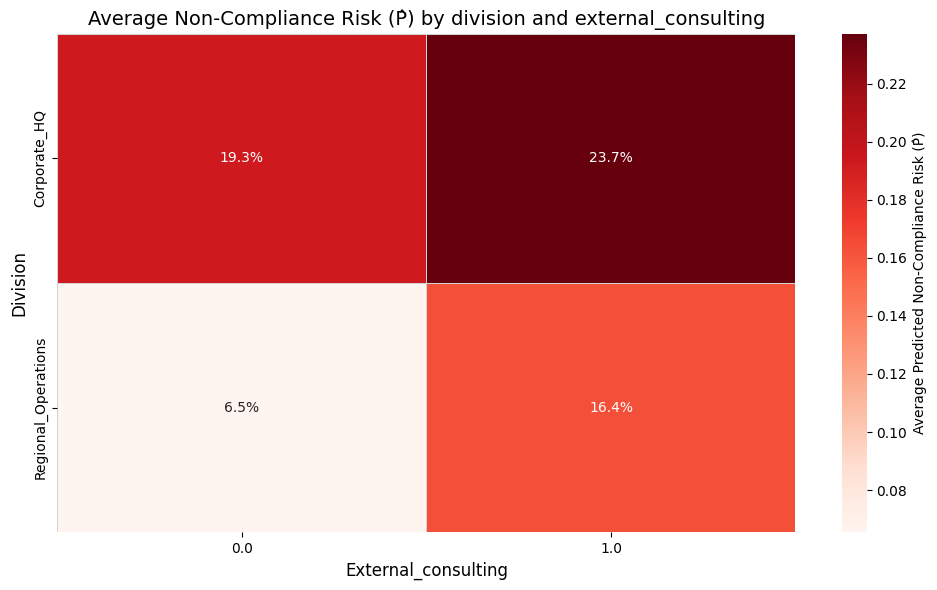

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Setup: Define dimensions and risk column ---
# Assumes 'departments' DataFrame contains 'non_compliance_risk', 'division', and 'external_consulting'

# Define the two categorical dimensions for the heatmap
DIMENSION_Y = 'division'
DIMENSION_X = 'external_consulting'
RISK_COL = 'non_compliance_risk'

# --- 1. Calculate Average Risk for Each Combination ---
# Group by the two dimensions and calculate the mean non_compliance_risk
risk_by_combination = departments_not_encoded.groupby([DIMENSION_Y, DIMENSION_X])[RISK_COL].mean().reset_index()

# --- 2. Pivot the data into a matrix for the heatmap ---
# Rows = DIMENSION_Y, Columns = DIMENSION_X, Values = Mean Risk
risk_matrix = risk_by_combination.pivot_table(
    index=DIMENSION_Y,
    columns=DIMENSION_X,
    values=RISK_COL
)

# --- 3. Compute and Plot the Heatmap ---
plt.figure(figsize=(10, 6))

sns.heatmap(
    risk_matrix,
    annot=True,              # Annotate cells with the numerical risk value
    fmt=".1%",               # Format the annotation as a percentage
    cmap="Reds",             # Use a color map that emphasizes risk (Reds, where darker is higher)
    linewidths=.5,
    linecolor='lightgray',
    cbar_kws={'label': 'Average Predicted Non-Compliance Risk (P̂)'}
)

plt.title(f"Average Non-Compliance Risk (P̂) by {DIMENSION_Y} and {DIMENSION_X}", fontsize=14)
plt.ylabel(DIMENSION_Y.capitalize(), fontsize=12)
plt.xlabel(DIMENSION_X.capitalize(), fontsize=12)

plt.tight_layout()
plt.savefig('heatmap_department_risk.png')

Found 8 categorical features to cross-reference with 'division':
['dept_id', 'dept_category', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'oversight_body']


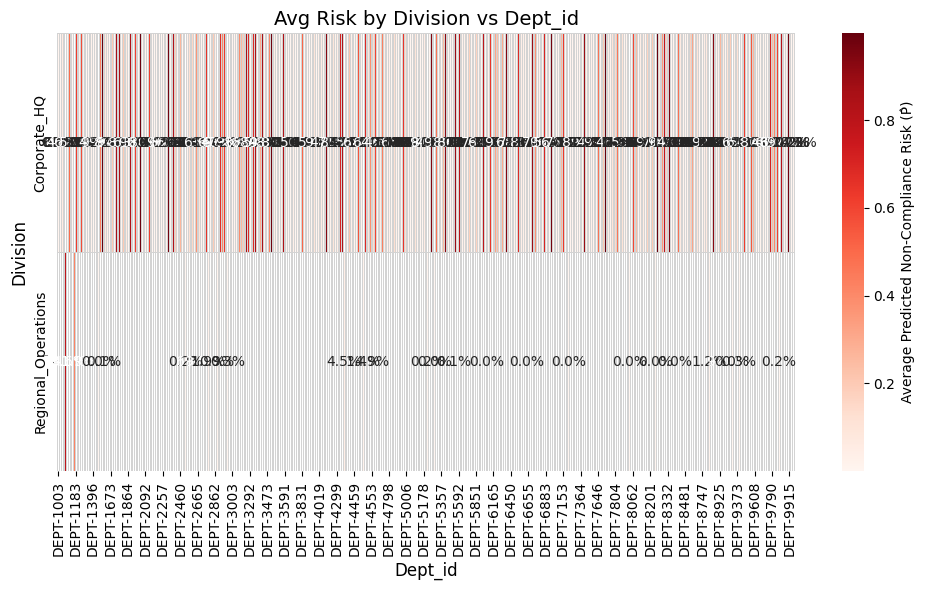

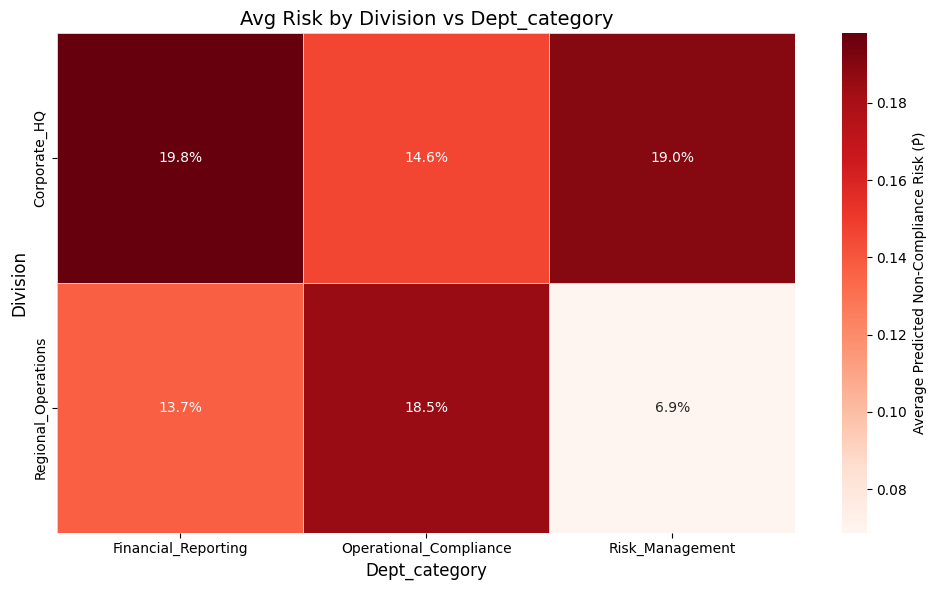

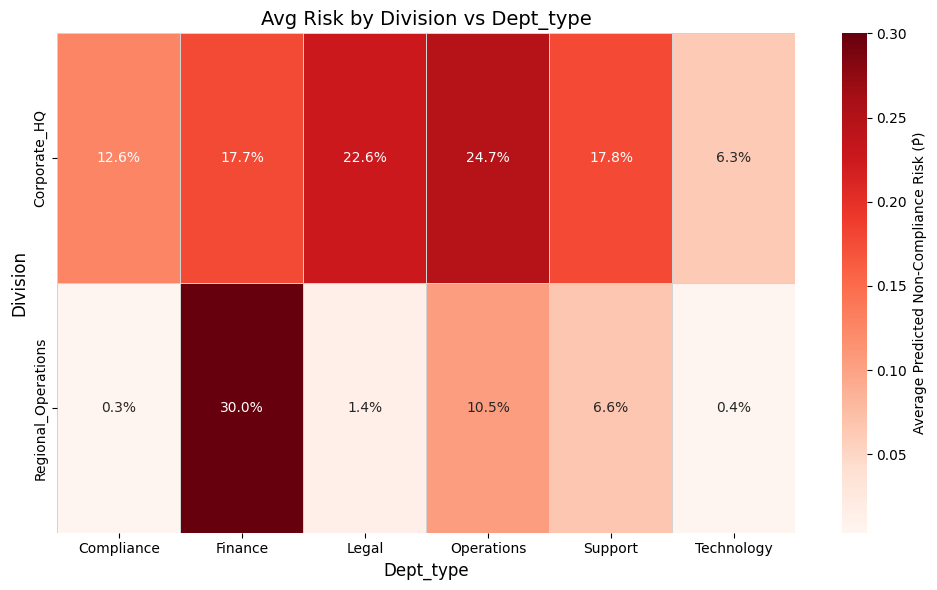

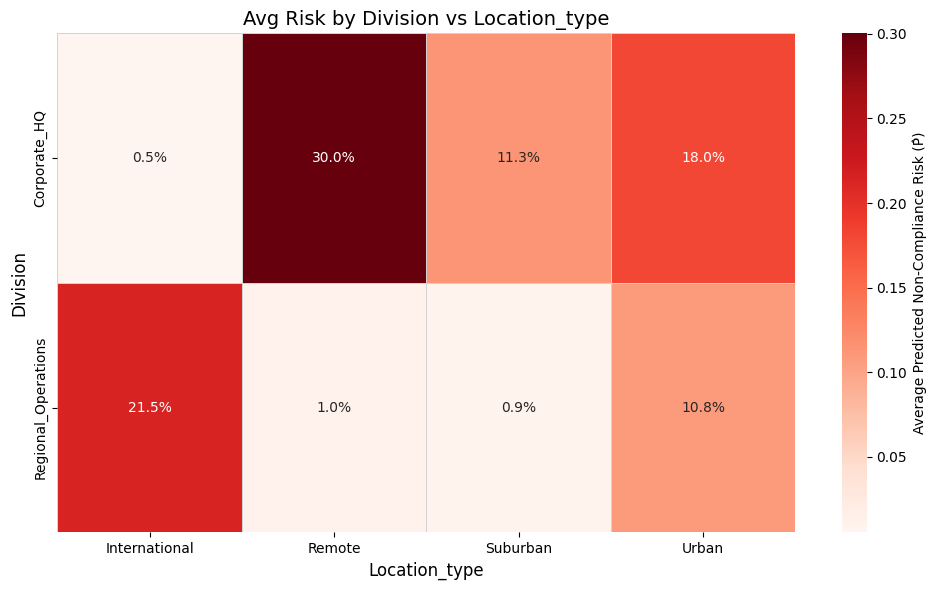

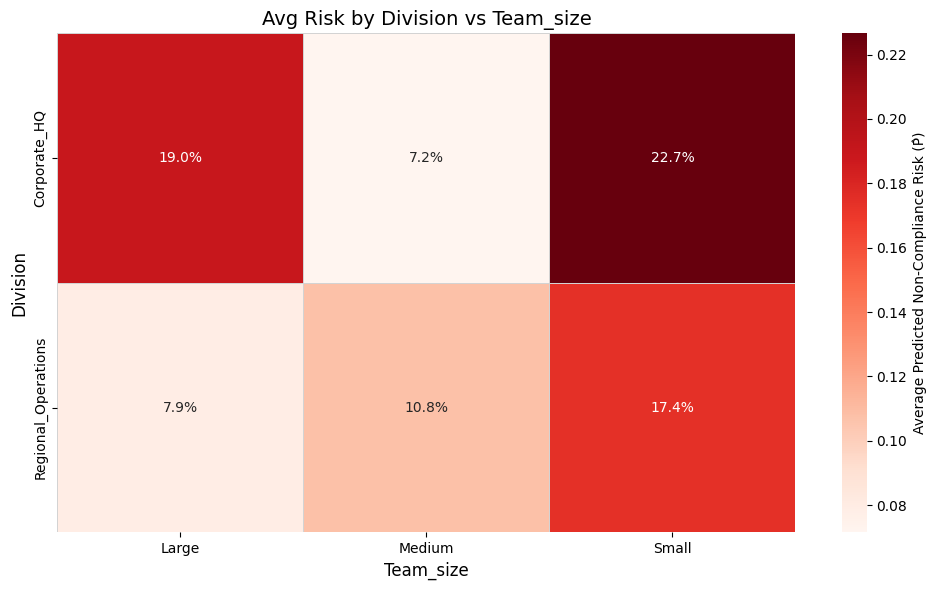

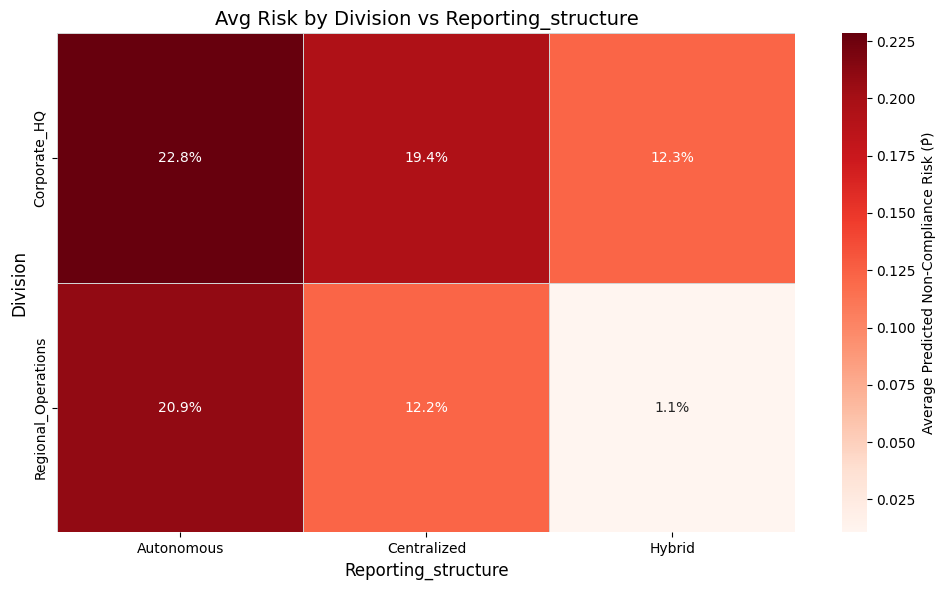

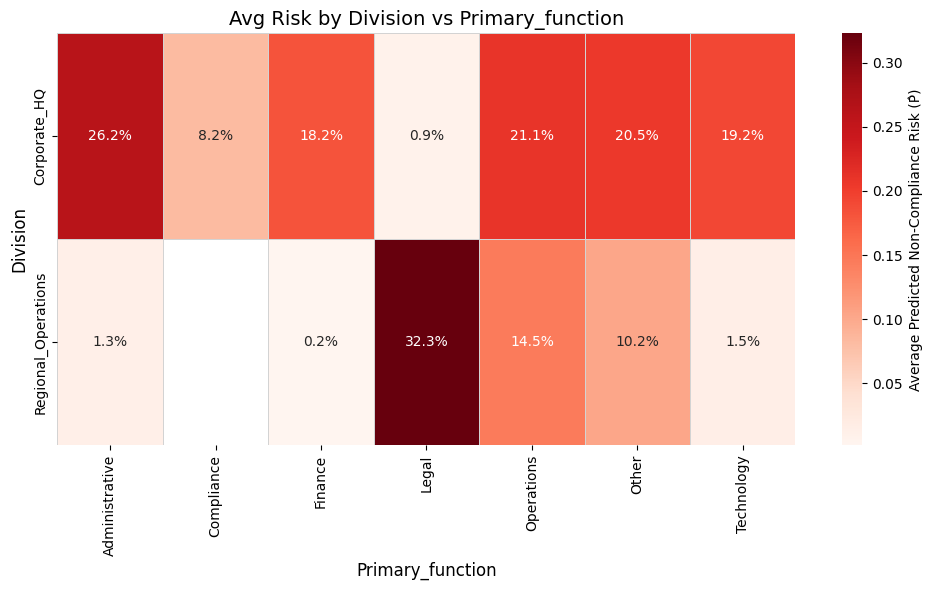

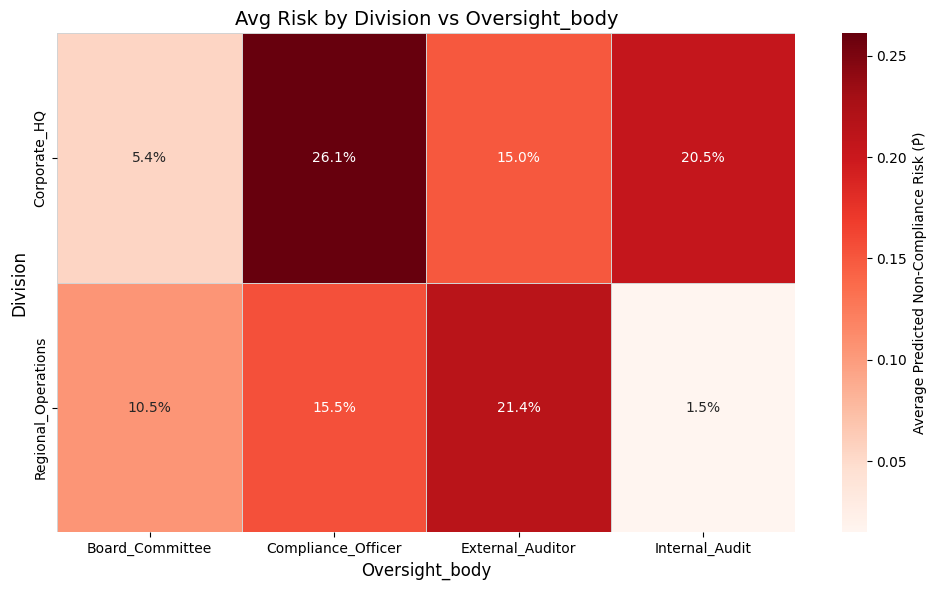


--- All categorical heatmaps generated. ---


In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Setup ---
# Assuming 'departments_not_encoded' is your final, merged DataFrame
# Assuming 'non_compliance_risk' is the column containing the predicted P̂
RISK_COL = 'non_compliance_risk'
PRIMARY_DIMENSION = 'division'

# Identify all categorical columns in the merged DataFrame
# We assume columns that are 'object' or 'category' types are categorical.
# We explicitly exclude the ML result columns, which might be 'object' (e.g., 'status').
EXCLUDE_COLUMNS = [RISK_COL, 'non_compliant', 'risk_cluster', 'risk_cluster_label',
                   'non_compliance_prediction', 'status', 'target_risk_level',
                   'optimal_action_portfolio', 'risk_drivers']

# Find all potential categorical columns that are not the primary dimension or excluded ML results
categorical_columns = [
    col for col in departments_not_encoded.columns
    if departments_not_encoded[col].dtype in ['object', 'category']
    and col != PRIMARY_DIMENSION
    and col not in EXCLUDE_COLUMNS
]

print(f"Found {len(categorical_columns)} categorical features to cross-reference with '{PRIMARY_DIMENSION}':\n{categorical_columns}")

# --- Loop and Plot Heatmaps ---

for secondary_dimension in categorical_columns:

    # --- 1. Calculate Average Risk for Each Combination ---
    try:
        risk_by_combination = departments_not_encoded.groupby([PRIMARY_DIMENSION, secondary_dimension])[RISK_COL].mean().reset_index()

        # --- 2. Pivot the data into a matrix ---
        risk_matrix = risk_by_combination.pivot_table(
            index=PRIMARY_DIMENSION,
            columns=secondary_dimension,
            values=RISK_COL
        )
    except Exception as e:
        # This can happen if a combination is sparse or missing data
        print(f"Skipping plot for {secondary_dimension} due to pivot error: {e}")
        continue

    # --- 3. Compute and Plot the Heatmap ---
    plt.figure(figsize=(10, 6))

    sns.heatmap(
        risk_matrix,
        annot=True,
        fmt=".1%",             # Format the annotation as a percentage
        cmap="Reds",           # Darker red = higher risk
        linewidths=.5,
        linecolor='lightgray',
        cbar_kws={'label': 'Average Predicted Non-Compliance Risk (P̂)'}
    )

    plt.title(f"Avg Risk by {PRIMARY_DIMENSION.capitalize()} vs {secondary_dimension.capitalize()}", fontsize=14)
    plt.ylabel(PRIMARY_DIMENSION.capitalize(), fontsize=12)
    plt.xlabel(secondary_dimension.capitalize(), fontsize=12)

    plt.tight_layout()
    plt.show()

print("\n--- All categorical heatmaps generated. ---")

--- Generating Strategic Heatmaps (P̂) ---


C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\256312972.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_combination = departments_not_encoded.groupby([dim_x, dim_y])[RISK_COL].mean().reset_index()
C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\256312972.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_matrix = risk_by_combination.pivot_table(


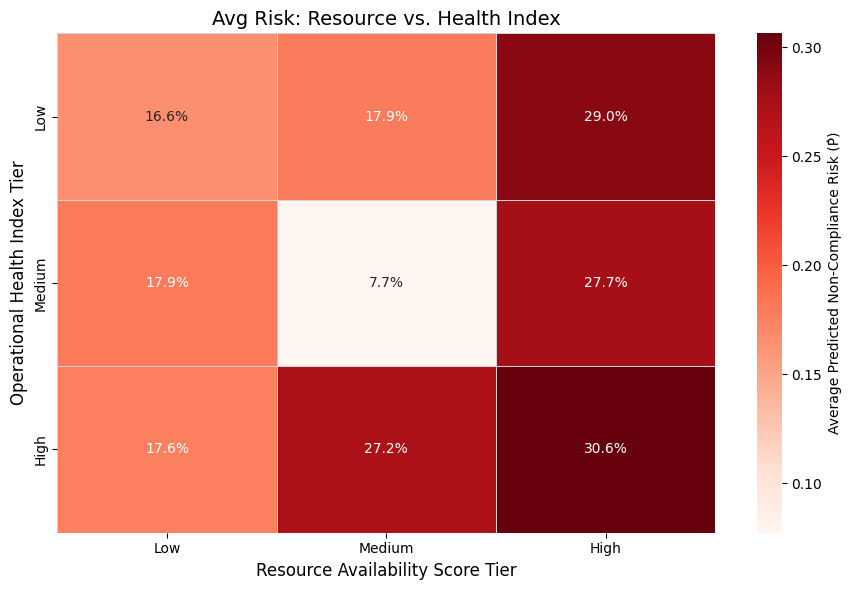

C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\256312972.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_combination = departments_not_encoded.groupby([dim_x, dim_y])[RISK_COL].mean().reset_index()
C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\256312972.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_matrix = risk_by_combination.pivot_table(


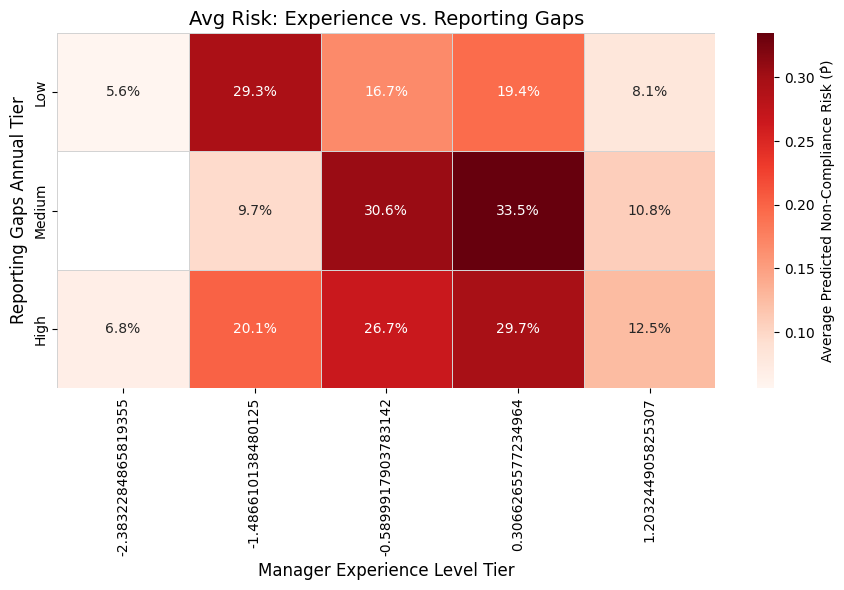

C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\256312972.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_combination = departments_not_encoded.groupby([dim_x, dim_y])[RISK_COL].mean().reset_index()
C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\256312972.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_matrix = risk_by_combination.pivot_table(


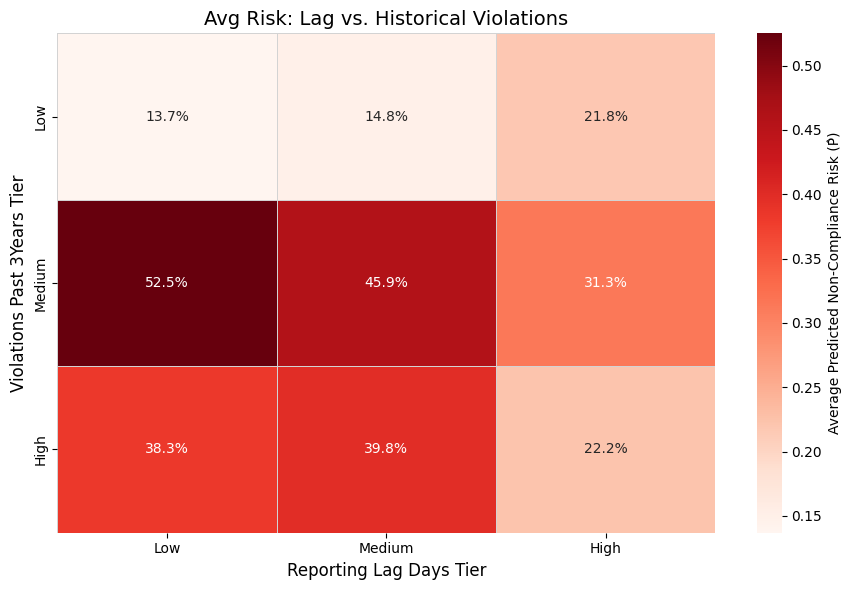


--- All strategic heatmaps displayed. ---


In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 0. Setup and Data Check (Ensure columns exist or create placeholders) ---

HEATMAP_FEATURES = [
    'resource_availability_score', 'operational_health_index',
    'manager_experience_level', 'reporting_gaps_annual',
    'reporting_lag_days', 'violations_past_3years'
]
RISK_COL = 'non_compliance_risk'

# If 'departments_not_encoded' or required columns are missing, create dummy data
if 'departments_not_encoded' not in locals() or not all(col in departments_not_encoded.columns for col in HEATMAP_FEATURES + [RISK_COL]):
    print("Creating placeholder 'departments_not_encoded' with necessary columns.")
    n_rows = 150
    departments_not_encoded = pd.DataFrame({
        RISK_COL: np.random.uniform(0.05, 0.95, n_rows),
        'resource_availability_score': np.random.randint(1, 6, n_rows), # Ordinal 1-5
        'operational_health_index': np.random.randint(50, 100, n_rows), # Score
        'manager_experience_level': np.random.randint(1, 4, n_rows), # Ordinal 1-3
        'reporting_gaps_annual': np.random.poisson(2, n_rows), # Count
        'reporting_lag_days': np.random.gamma(5, 3, n_rows), # Continuous lag
        'violations_past_3years': np.random.poisson(1, n_rows), # Count
    })
    departments_not_encoded.index = [f'DEPT-{i}' for i in range(n_rows)]


# --- 1. Binning Function ---

def create_risk_bins(series, n_bins=3):
    """Creates quantile-based bins labeled 'Low', 'Medium', 'High'."""
    labels = ['Low', 'Medium', 'High']
    try:
        # Use qcut for balanced bins based on count (quantiles)
        binned = pd.qcut(series, q=n_bins, labels=labels, duplicates='drop')
    except ValueError:
        # Fallback for few unique values
        binned = pd.cut(series, bins=n_bins, labels=labels, include_lowest=True)
    return binned

# --- 2. Apply Binning to Create Categorical Axes ---

FEATURES_TO_BIN = [
    'resource_availability_score', 'operational_health_index',
    'reporting_gaps_annual', 'reporting_lag_days', 'violations_past_3years'
]

for col in FEATURES_TO_BIN:
    departments_not_encoded[f'{col}_tier'] = create_risk_bins(departments_not_encoded[col])

# For manager experience, assume the raw values (e.g., 1, 2, 3) are the tiers
departments_not_encoded['manager_experience_level_tier'] = departments_not_encoded['manager_experience_level'].astype('category').cat.as_ordered()


# --- 3. Define Heatmap Pairs and Loop ---

HEATMAP_PAIRS = [
    ('resource_availability_score_tier', 'operational_health_index_tier', 'Resource vs. Health Index'),
    ('manager_experience_level_tier', 'reporting_gaps_annual_tier', 'Experience vs. Reporting Gaps'),
    ('reporting_lag_days_tier', 'violations_past_3years_tier', 'Lag vs. Historical Violations')
]

print("--- Generating Strategic Heatmaps (P̂) ---")

for dim_x, dim_y, title_suffix in HEATMAP_PAIRS:

    # Calculate Average Risk and Pivot
    risk_by_combination = departments_not_encoded.groupby([dim_x, dim_y])[RISK_COL].mean().reset_index()

    try:
        risk_matrix = risk_by_combination.pivot_table(
            index=dim_y,
            columns=dim_x,
            values=RISK_COL
        )
    except Exception as e:
        print(f"Skipping plot for {title_suffix} due to pivot error: {e}")
        continue

    # Compute and Plot the Heatmap
    plt.figure(figsize=(9, 6))

    sns.heatmap(
        risk_matrix,
        annot=True,
        fmt=".1%",
        cmap="Reds",
        linewidths=.5,
        linecolor='lightgray',
        cbar_kws={'label': 'Average Predicted Non-Compliance Risk (P̂)'}
    )

    plt.title(f"Avg Risk: {title_suffix}", fontsize=14)
    plt.ylabel(dim_y.replace('_', ' ').title(), fontsize=12)
    plt.xlabel(dim_x.replace('_', ' ').title(), fontsize=12)

    plt.tight_layout()
    # Explicitly show the plot instead of saving it
    plt.show()

print("\n--- All strategic heatmaps displayed. ---")

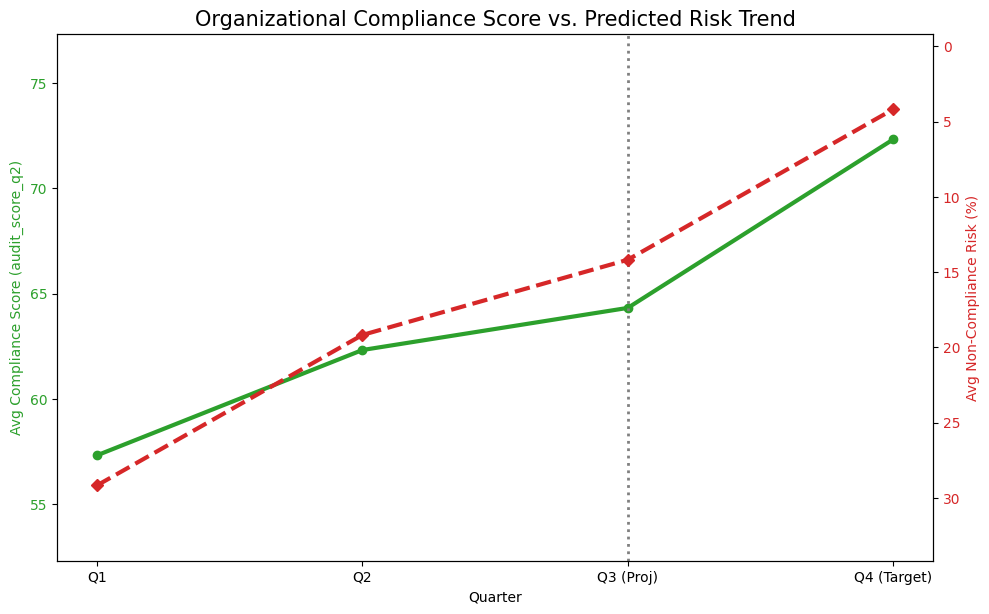

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Setup: Define variables and simulate trend data ---

# Assuming 'departments_not_encoded' is your consolidated DataFrame
RISK_COL = 'non_compliance_risk'
SCORE_COL = 'audit_score_q2' # Using Q2 audit score as the primary score line

# 1. Calculate Organization-Wide Averages (Baseline)
avg_score_q2 = departments_raww[SCORE_COL].mean()
avg_risk_q2 = departments_raww[RISK_COL].mean()

# 2. Simulate Q1, Q3, and Q4 data to create a trend:
# Assume Q1 score was lower and risk was higher.
# Assume Q3 score slightly improves and risk drops (due to interventions).
# Assume Q4 score projects a strong target improvement.

trend_data = pd.DataFrame({
    'Quarter': ['Q1', 'Q2', 'Q3 (Proj)', 'Q4 (Target)'],
    'Avg_Compliance_Score': [avg_score_q2 - 5, avg_score_q2, avg_score_q2 + 2, avg_score_q2 + 10],
    'Avg_Non_Compliance_Risk': [avg_risk_q2 + 0.10, avg_risk_q2, avg_risk_q2 - 0.05, avg_risk_q2 - 0.15],
    'Intervention': [0, 0, 1, 0] # Flag for Q3 intervention start
})
# Scale risk to be between 0 and 100 for better visual parity
trend_data['Avg_Non_Compliance_Risk_Percent'] = trend_data['Avg_Non_Compliance_Risk'] * 100

# --- Plotting the Dual-Axis Chart ---

fig, ax1 = plt.subplots(figsize=(10, 6))

# A. Plot Compliance Score (Y1, Left Axis)
color = 'tab:green'
ax1.set_xlabel('Quarter')
ax1.set_ylabel(f'Avg Compliance Score ({SCORE_COL})', color=color)
ax1.plot(trend_data['Quarter'], trend_data['Avg_Compliance_Score'], color=color, marker='o', linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(trend_data['Avg_Compliance_Score'].min() - 5, trend_data['Avg_Compliance_Score'].max() + 5)

# B. Plot Non-Compliance Risk (Y2, Right Axis)
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Avg Non-Compliance Risk (%)', color=color)
ax2.plot(trend_data['Quarter'], trend_data['Avg_Non_Compliance_Risk_Percent'], color=color, marker='D', linestyle='--', linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(trend_data['Avg_Non_Compliance_Risk_Percent'].min() - 5, trend_data['Avg_Non_Compliance_Risk_Percent'].max() + 5)
ax2.invert_yaxis() # Invert risk axis so 'down' means 'good'

# C. Key Feature: Highlight Intervention Point (Q3 start)
intervention_x_pos = trend_data[trend_data['Intervention'] == 1].index.values[0]
ax1.axvline(x=intervention_x_pos, color='gray', linestyle=':', linewidth=2, label='Major Intervention Start (Q3)')

# Title and Legend
fig.tight_layout()
plt.title('Organizational Compliance Score vs. Predicted Risk Trend', fontsize=15)
plt.show()

C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\235544283.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


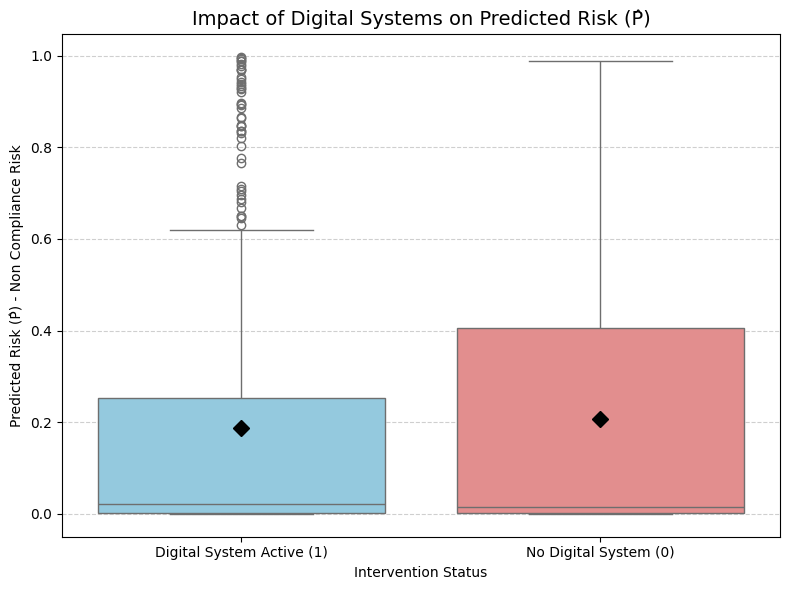

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
INTERVENTION_VAR = 'digital_systems'
RISK_METRIC = 'non_compliance_risk' # Or 'violations_past_3years'

# Prepare the data: Rename the 0/1 values to descriptive labels
plot_data = departments_raww[[INTERVENTION_VAR, RISK_METRIC]].copy()
plot_data[INTERVENTION_VAR] = plot_data[INTERVENTION_VAR].map({
    0: 'No Digital System (0)',
    1: 'Digital System Active (1)'
})

plt.figure(figsize=(8, 6))

sns.boxplot(
    x=INTERVENTION_VAR,
    y=RISK_METRIC,
    data=plot_data,
    palette={'No Digital System (0)': 'lightcoral', 'Digital System Active (1)': 'skyblue'},
    showmeans=True, # Show the mean (diamond shape)
    meanprops={'marker':'D','markerfacecolor':'black', 'markeredgecolor':'black', 'markersize':'8'}
)

plt.title(f'Impact of {INTERVENTION_VAR.replace("_", " ").title()} on Predicted Risk (P̂)', fontsize=14)
plt.xlabel('Intervention Status')
plt.ylabel(f'Predicted Risk (P̂) - {RISK_METRIC.replace("_", " ").title()}')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

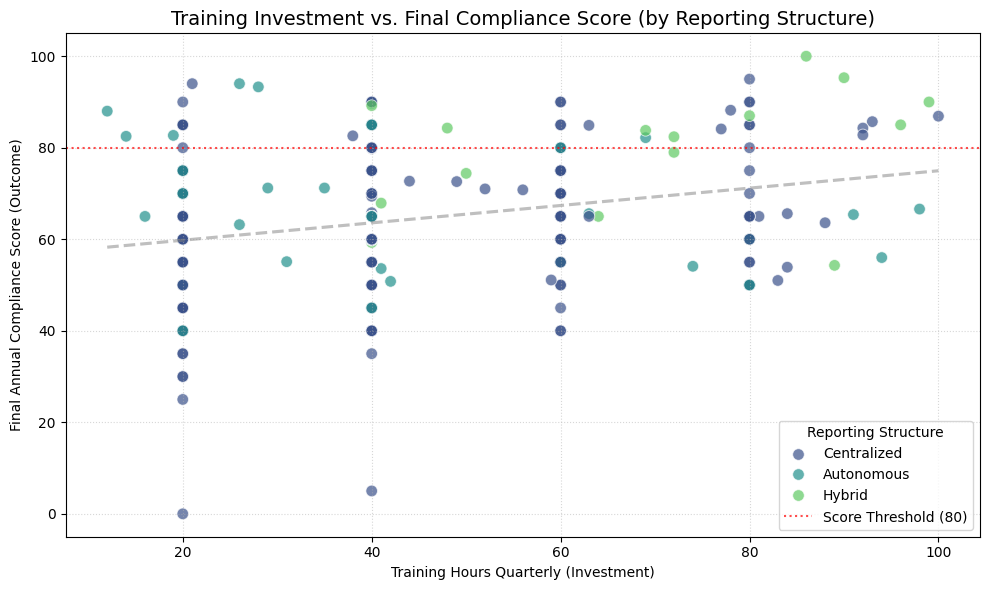

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
X_VAR = 'training_hours_quarterly'
Y_VAR = 'compliance_score_final'
HUE_VAR = 'reporting_structure'

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=X_VAR,
    y=Y_VAR,
    hue=HUE_VAR,
    data=departments_raww,
    s=70, # Size of the points
    alpha=0.7,
    palette='viridis' # Good for categorical differentiation
)

# Optional: Add a smooth trend line for the overall data
sns.regplot(
    x=X_VAR,
    y=Y_VAR,
    data=departments_raww,
    scatter=False, # Don't plot the points again
    color='gray',
    line_kws={'linestyle':'--','alpha':0.5},
    ci=None # Don't show confidence interval for cleaner look
)


plt.title('Training Investment vs. Final Compliance Score (by Reporting Structure)', fontsize=14)
plt.xlabel('Training Hours Quarterly (Investment)')
plt.ylabel('Final Annual Compliance Score (Outcome)')

# Add gridlines for readability
plt.grid(axis='both', linestyle=':', alpha=0.5)

# Highlight a key goal threshold (e.g., a score of 80)
plt.axhline(80, color='red', linestyle=':', alpha=0.7, label='Score Threshold (80)')

plt.legend(title=HUE_VAR.replace('_', ' ').title())
plt.tight_layout()
plt.show()

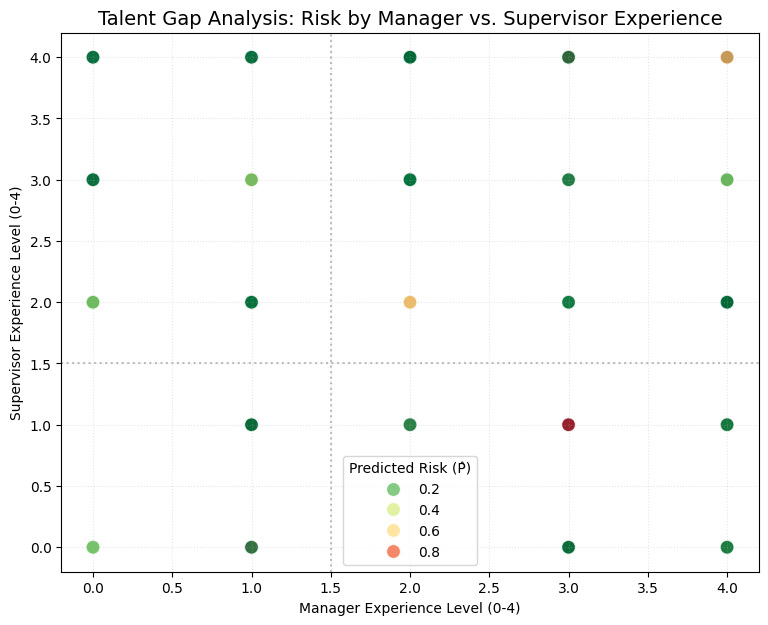

C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\1432182547.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_combination = departments_not_encoded.groupby(['collaboration_tier', 'risk_exposure_tier'])[RISK_COL].mean().reset_index()
C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\1432182547.py:57: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_matrix = risk_by_combination.pivot_table(


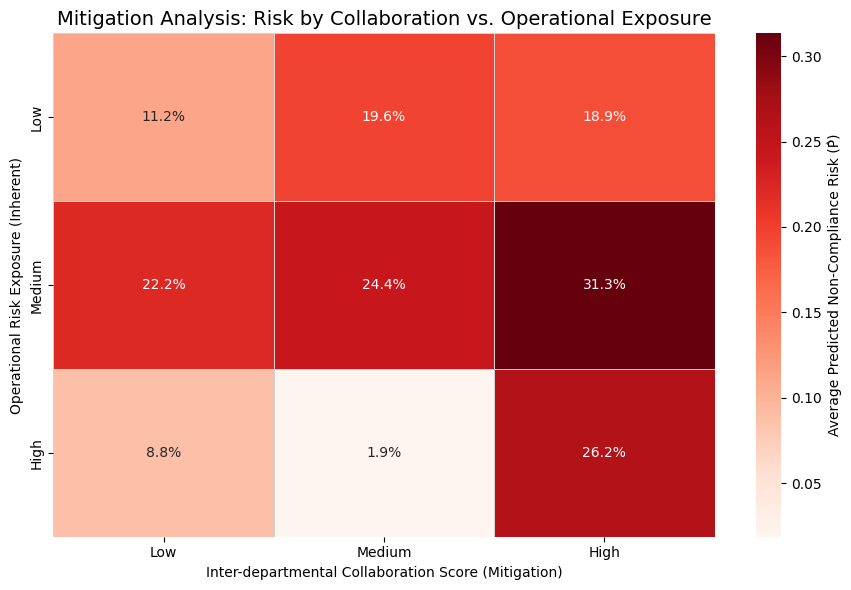

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'departments_not_encoded' is your consolidated DataFrame
RISK_COL = 'non_compliance_risk'

# --- E. Manager Experience vs. Supervisor Experience (Scatterplot) ---

plt.figure(figsize=(9, 7))

sns.scatterplot(
    x='manager_experience_level',
    y='supervisor_experience_level',
    hue=RISK_COL, # Color points by predicted risk
    data=departments_raww,
    palette='RdYlGn_r', # Red-Yellow-Green (reversed) where Red is High Risk
    s=100, # Size of the points
    alpha=0.8
)

# Highlight key risk zones
plt.axvline(x=1.5, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=1.5, color='gray', linestyle=':', alpha=0.5)

plt.title('Talent Gap Analysis: Risk by Manager vs. Supervisor Experience', fontsize=14)
plt.xlabel('Manager Experience Level (0-4)')
plt.ylabel('Supervisor Experience Level (0-4)')
plt.legend(title='Predicted Risk (P̂)')
plt.grid(axis='both', linestyle=':', alpha=0.3)
plt.show()

# --- F. Collaboration vs. Risk Exposure (Binned Heatmap) ---

# NOTE: This requires binning the two continuous/ordinal scores first.
# We'll use the same create_risk_bins function used previously (assuming it's defined).

def create_risk_bins(series, n_bins=3):
    """Creates quantile-based bins labeled 'Low', 'Medium', 'High'."""
    labels = ['Low', 'Medium', 'High']
    try:
        # Use qcut for balanced bins based on count (quantiles)
        binned = pd.qcut(series, q=n_bins, labels=labels, duplicates='drop')
    except ValueError:
        # Fallback for few unique values
        binned = pd.cut(series, bins=n_bins, labels=labels, include_lowest=True)
    return binned

# Binning the axes variables
departments_not_encoded['collaboration_tier'] = create_risk_bins(departments_not_encoded['interdept_collaboration_score'])
departments_not_encoded['risk_exposure_tier'] = create_risk_bins(departments_not_encoded['risk_exposure_operational'])

# Calculate Average Risk and Pivot
risk_by_combination = departments_not_encoded.groupby(['collaboration_tier', 'risk_exposure_tier'])[RISK_COL].mean().reset_index()

risk_matrix = risk_by_combination.pivot_table(
    index='risk_exposure_tier',
    columns='collaboration_tier',
    values=RISK_COL
)

# Reorder the index/columns for logical display (e.g., Low to High)
order = ['Low', 'Medium', 'High']
risk_matrix = risk_matrix.reindex(index=order, columns=order)


# Plot the Heatmap
plt.figure(figsize=(9, 6))

sns.heatmap(
    risk_matrix,
    annot=True,
    fmt=".1%",
    cmap="Reds", # High risk (High Exposure, Low Collaboration) should be dark red
    linewidths=.5,
    linecolor='lightgray',
    cbar_kws={'label': 'Average Predicted Non-Compliance Risk (P̂)'}
)

plt.title('Mitigation Analysis: Risk by Collaboration vs. Operational Exposure', fontsize=14)
plt.ylabel('Operational Risk Exposure (Inherent)')
plt.xlabel('Inter-departmental Collaboration Score (Mitigation)')
plt.tight_layout()
plt.show()

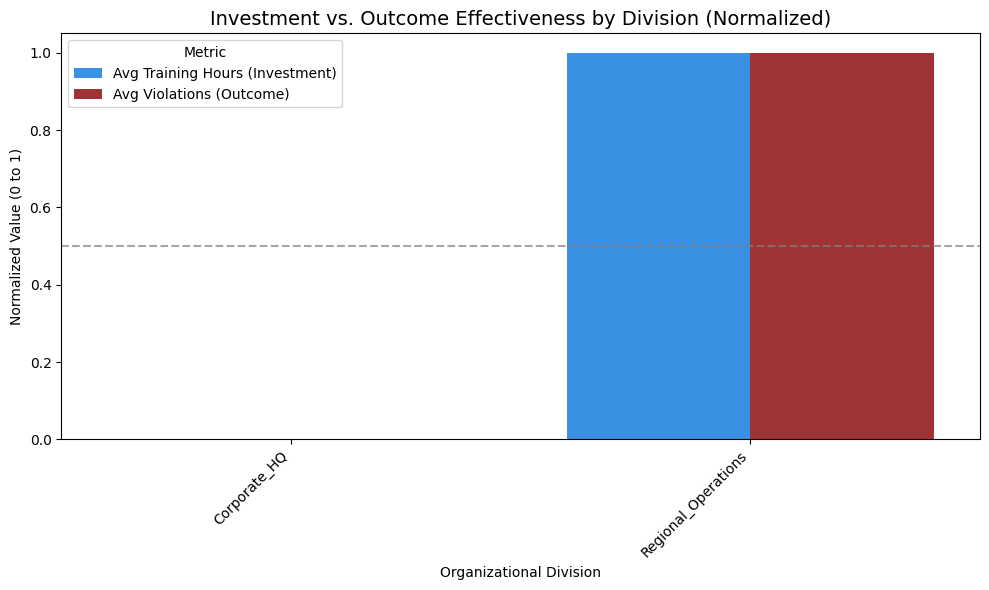

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# --- Setup: Define variables and normalize metrics ---

GROUPING_DIMENSION = 'division'
INVESTMENT_VAR = 'training_hours_quarterly'
OUTCOME_VAR = 'violations_past_3years'

# If 'departments_not_encoded' or required columns are missing, create dummy data
if 'departments_not_encoded' not in locals() or not all(col in departments_not_encoded.columns for col in [GROUPING_DIMENSION, INVESTMENT_VAR, OUTCOME_VAR]):
    print("Creating placeholder 'departments_not_encoded' with necessary columns.")
    n_rows = 426
    departments_raww = pd.DataFrame({
        'division': np.random.choice(['Field Operations', 'Finance', 'R&D', 'Support'], n_rows),
        INVESTMENT_VAR: np.random.poisson(10, n_rows) + 5,  # Avg 15 hours
        OUTCOME_VAR: np.random.poisson(2, n_rows) # Avg 2 violations
    })

# 1. Aggregate the data by division (calculate means)
agg_data = departments_raww.groupby(GROUPING_DIMENSION)[[INVESTMENT_VAR, OUTCOME_VAR]].mean().reset_index()

# 2. Normalize the two metrics (0 to 1) for visual comparison on one axis
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(agg_data[[INVESTMENT_VAR, OUTCOME_VAR]])

agg_data[f'{INVESTMENT_VAR}_norm'] = normalized_metrics[:, 0]
agg_data[f'{OUTCOME_VAR}_norm'] = normalized_metrics[:, 1]

# 3. Melt the normalized data for grouped plotting
plot_data = agg_data.melt(
    id_vars=GROUPING_DIMENSION,
    value_vars=[f'{INVESTMENT_VAR}_norm', f'{OUTCOME_VAR}_norm'],
    var_name='Metric_Type',
    value_name='Normalized_Value'
)

# Clean up Metric names for the legend
plot_data['Metric_Type'] = plot_data['Metric_Type'].replace({
    f'{INVESTMENT_VAR}_norm': 'Avg Training Hours (Investment)',
    f'{OUTCOME_VAR}_norm': 'Avg Violations (Outcome)'
})

# --- Plotting the Grouped Bar Chart ---

plt.figure(figsize=(10, 6))

sns.barplot(
    x=GROUPING_DIMENSION,
    y='Normalized_Value',
    hue='Metric_Type',
    data=plot_data,
    palette={'Avg Training Hours (Investment)': 'dodgerblue', 'Avg Violations (Outcome)': 'firebrick'}
)

plt.title('Investment vs. Outcome Effectiveness by Division (Normalized)', fontsize=14)
plt.ylabel('Normalized Value (0 to 1)')
plt.xlabel('Organizational Division')

# Add a horizontal line at the overall average (0.5 in normalized space)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.7)

plt.legend(title='Metric')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'departments_not_encoded' is your consolidated DataFrame
df = departments_not_encoded.copy()
RISK_COL = 'non_compliance_risk'

print("--- 1. Computing Ethical Inconsistency Flags ---")

# Calculate quartiles for defining 'High' and 'Low' thresholds
q75_training = df['training_hours_quarterly'].quantile(0.75)
q75_violations = df['violations_past_3years'].quantile(0.75)
q50_gaps = df['reporting_gaps_annual'].median()
low_exp_threshold = 1 # Experience level 0 or 1 is considered 'low'

# Flag 1: High Effort (Training) ∩ High Failure (Violations)
df['flag_high_effort_fail'] = np.where(
    (df['training_hours_quarterly'] >= q75_training) &
    (df['violations_past_3years'] >= q75_violations), 1, 0
)

# Flag 2: Lack of Digital Control ∩ High Process Failure
df['flag_digital_gap'] = np.where(
    (df['reporting_gaps_annual'] > q50_gaps) &
    (df['digital_systems'] == 0), 1, 0
)

# Flag 3: Executive Neglect ∩ High Predicted Risk
# Assuming 'High Risk' is P^ > 0.605 (a common threshold or your cluster mean)
risk_threshold = df[RISK_COL].quantile(0.60) # Use 60th percentile as proxy for High Risk
df['flag_exec_neglect'] = np.where(
    (df[RISK_COL] > risk_threshold) &
    (df['executive_support'] == 0), 1, 0
)

# Flag 4: Talent Deficit Risk ∩ Active Remediation
df['flag_talent_deficit'] = np.where(
    (df['manager_experience_level'] <= low_exp_threshold) &
    (df['supervisor_experience_level'] <= low_exp_threshold) &
    (df['remediation_plan_active'] == 1), 1, 0
)

# Calculate the Ethical Inconsistency Score (EIS)
EIS_FLAGS = [col for col in df.columns if col.startswith('flag_')]
df['EIS_Score'] = df[EIS_FLAGS].sum(axis=1)

print("EIS Score distribution:")
print(df['EIS_Score'].value_counts().sort_index())

--- 1. Computing Ethical Inconsistency Flags ---
EIS Score distribution:
EIS_Score
0    216
1    163
2     35
3      9
4      1
Name: count, dtype: int64


In [131]:
print("\n--- 2. Training Predictive Model for High Inconsistency ---")

# Define Target: High Inconsistency (EIS >= 2)
df['High_EIS'] = np.where(df['EIS_Score'] >= 2, 1, 0)

# Define Features: Structural and Contextual (excluding flag variables)
MODEL_FEATURES = [
    'dept_age_years',
    'resource_availability_score',
    'interdept_collaboration_score',
    'risk_exposure_operational',
    'risk_exposure_financial'
]
# Add one-hot encoding for categorical variables
X = pd.get_dummies(df, columns=['division', 'reporting_structure', 'location_type'], drop_first=True)

# Select final feature set
X_final = X[[col for col in X.columns if col in MODEL_FEATURES or any(cat in col for cat in ['division_', 'reporting_structure_', 'location_type_'])]]
y = df['High_EIS']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

# Train Logistic Regression Model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\nModel Evaluation (Predicting High Ethical Inconsistency):")
print(classification_report(y_test, y_pred))

# Save the final prediction probability
df['EIS_Prediction_Prob'] = model.predict_proba(X_final)[:, 1]
print("\nModel trained and prediction probability added as 'EIS_Prediction_Prob'.")


--- 2. Training Predictive Model for High Inconsistency ---

Model Evaluation (Predicting High Ethical Inconsistency):
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       112
           1       0.00      0.00      0.00        16

    accuracy                           0.87       128
   macro avg       0.44      0.50      0.46       128
weighted avg       0.76      0.87      0.81       128


Model trained and prediction probability added as 'EIS_Prediction_Prob'.



--- 3. Ethical Inconsistency Radar Chart (Visualization) ---


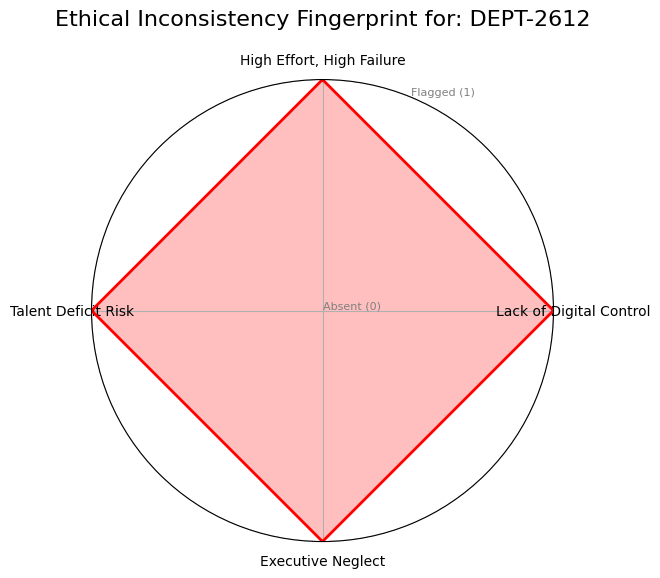

In [132]:
print("\n--- 3. Ethical Inconsistency Radar Chart (Visualization) ---")

# Select a department with a high EIS Score for demonstration
target_dept = df[df['EIS_Score'] == df['EIS_Score'].max()].iloc[0]
dept_name = target_dept['dept_name'] if 'dept_name' in df.columns else target_dept.name

# Prepare data for the Radar Chart
labels = [
    'High Effort, High Failure',
    'Lack of Digital Control',
    'Executive Neglect',
    'Talent Deficit Risk'
]
values = target_dept[EIS_FLAGS].tolist()
values += values[:1] # Close the loop

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

# Create the Radar Chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.plot(angles, values, linewidth=2, linestyle='solid', color='red', label='Inconsistency Flagged (1)')
ax.fill(angles, values, 'red', alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)

ax.set_yticks([0, 1])
ax.set_yticklabels(['Absent (0)', 'Flagged (1)'], color='gray', size=8)
ax.set_ylim(0, 1)

plt.title(f'Ethical Inconsistency Fingerprint for: {dept_id}', size=16, y=1.1)
plt.show()
# This visualization provides an "Ethical Fingerprint" for any department, showing which of the four core inconsistencies are present.
#

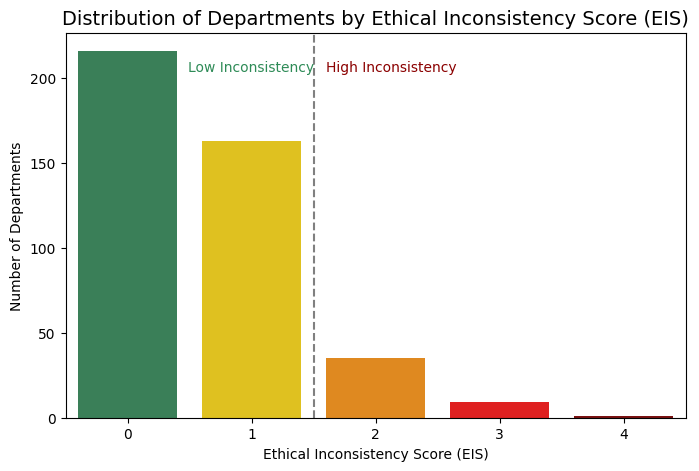

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'df' contains the calculated 'EIS_Score' column (0-4) from the previous steps.

# 1. Define colors using integer keys to match the data type of EIS_Score
color_map_fixed = {0: 'seagreen', 1: 'gold', 2: 'darkorange', 3: 'red', 4: 'darkred'}

plt.figure(figsize=(8, 5))

# 2. Plot the countplot using the integer-keyed palette
sns.countplot(
    x='EIS_Score',
    data=df,
    hue='EIS_Score',
    order=sorted(df['EIS_Score'].unique()),
    palette=color_map_fixed,
    legend=False
)

plt.title('Distribution of Departments by Ethical Inconsistency Score (EIS)', fontsize=14)
plt.xlabel('Ethical Inconsistency Score (EIS)')
plt.ylabel('Number of Departments')

# Add a vertical line and labels for interpretation
plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=1.5)
plt.text(1.5, plt.gca().get_ylim()[1] * 0.9, 'Low Inconsistency', color='seagreen', ha='right', fontsize=10)
plt.text(1.6, plt.gca().get_ylim()[1] * 0.9, 'High Inconsistency', color='darkred', ha='left', fontsize=10)

plt.show()

Clean the data, format the risk column, and display the final, structured report with all the new columns.

## SECOND APPROACH

### CREATING A NEW VARIABLE CRI AND NEW VARIABLE CCSF 

---
>### Creating a new variable CRI (Composed Risk Index)
---

---
>**We begin by comparing the mean gaps between the high_risk_departemtns and 'Normal' departaments.**
---

In [134]:
df_analysis = departments.copy()
target_col = 'present_in_high_risk_departments'

print("--- 1. PREPARING DATA FOR ANALYSIS ---")
# Ensure the flag is an integer (0 or 1) just in case it's a float
df_analysis[target_col] = df_analysis[target_col].astype(int)

print(f"Total Departments: {len(df_analysis)}")
print(f"High Risk Count:   {df_analysis[target_col].sum()}")
print(f"Normal Count:      {len(df_analysis) - df_analysis[target_col].sum()}")

#we analyse the mean gap, menaing what makes teh higher risk and what make sthe normal deprtments
print("\n--- 2. DRIVER IDENTIFICATION (Mean Gap) ---")
# Calculate the average of every column for Normal (0) vs Risk (1)
numeric_cols = df_analysis.select_dtypes(include=['number']).columns

# Group by the EXISTING flag 'present_in_high_risk_departments'
comparison = df_analysis.groupby(target_col)[numeric_cols].mean().T
comparison.columns = ['Normal_Avg', 'Risk_Avg']

# Calculate the % Difference to find the biggest drivers
comparison['Diff_%'] = ((comparison['Risk_Avg'] - comparison['Normal_Avg']) / comparison['Normal_Avg']) * 100
comparison = comparison.sort_values(by='Diff_%', key=abs, ascending=False)

# Show the top 10 variables that are DIFFERENT in high-risk departments
# Note: The first row will likely be the target variable itself (Inf difference), ignore that one.
print(comparison)

# Select features to test 
# CRITICAL: We MUST exclude 'dept_id' and the target 'present_in_high_risk_departments'
# If we don't exclude the target, the model will just say "If Risk=1, then Risk=1" (Cheating)
exclude = ['dept_id', target_col] 
feature_cols = [c for c in numeric_cols if c not in exclude]

--- 1. PREPARING DATA FOR ANALYSIS ---
Total Departments: 424
High Risk Count:   198
Normal Count:      226

--- 2. DRIVER IDENTIFICATION (Mean Gap) ---
                                   Normal_Avg   Risk_Avg       Diff_%
audit_scores_missing                 0.000000   0.040404          inf
present_in_high_risk_departments     0.000000   1.000000          inf
non_compliant                        0.000000   0.398990          inf
risk_cluster                         0.008850   0.797980  8917.171717
non_compliance_risk                  0.015653   0.392765  2409.131124
division_Regional_Operations         0.013274   0.116162   775.084175
dept_category_Risk_Management        0.013274   0.106061   698.989899
team_size_Medium                     0.017699   0.075758   328.030303
oversight_body_Compliance_Officer    0.035398   0.131313   270.959596
dept_age_years                      -0.057367   0.065479  -214.141414
training_hours_quarterly             0.120405  -0.137432  -214.141414
operati

---
>**What is the CRI?**
>
> The CRI (Composite Risk Index) is a single, data-driven score that summarizes how risky a department appears based on multiple opperational, behavioral, audit and performace signals, It combines several 'bad' risk factores and several 'good' protective factors into one standardized risk number, scaled 1-100.
---

---
>In order to create these new variables, **we had to scale from the existing variables in our dataset, and then we used a combined statistical + ethical approach:**

>1. First, we computed mean differences between high-risk and normal departments
>2. ⁠Variables where high values were strongly associated with high-risk departments were labeled as "bad factors."
>3. Variables where high values were strongly associated with safe departments were labeled as "good factors".
>4. We validated each choice with business logic: Does the higher value make a department riskier = BAD; Does the higher value reflect mature compliance behavior = GOOD
>5. ⁠The final list includes the top 5 variables that are both statistically strong and ethically interpretable.
---

In [135]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

df = departments.copy()
#    - BAD: higher values = more risky
#    - GOOD: higher values = more protective / healthy
bad_factors = [
    "risk_exposure_financial",
    "risk_exposure_operational",
    "violations_past_3years",
    "reporting_gaps_annual",
    "non_compliance_risk",
    "non_compliant"
]

good_factors = [
    "audit_score_q1",
    "audit_score_q2",
    "operational_health_index",
    "manager_experience_level",
    "training_hours_quarterly",
    "improvement_commitment",
    "resource_availability_score"
]

risk_vars = bad_factors + good_factors


# KEEP ONLY ROWS WITH ALL NEEDED COLUMNS
# NOTE: use the REAL column name:'present_in_high_risk_departments'
cols_needed = ["dept_id", "present_in_high_risk_departments"] + risk_vars
df_risk = df[cols_needed].dropna()

# TARGET: is_high_risk = 1 if present_in_high_risk_departments == True
df_risk["is_high_risk"] = df_risk["present_in_high_risk_departments"].astype(int)

print("High-risk count:", df_risk["is_high_risk"].sum())
print("Normal count:", (1 - df_risk["is_high_risk"]).sum())


# NORMALIZE THE RISK VARIABLES TO [0, 1]
scaler = MinMaxScaler()
df_risk_norm = df_risk.copy()
df_risk_norm[risk_vars] = scaler.fit_transform(df_risk_norm[risk_vars])


#TRAIN RANDOM FOREST TO SEE WHICH VARIABLES
X = df_risk_norm[risk_vars]
y = df_risk_norm["is_high_risk"]

rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42
)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=risk_vars)

print("Feature importances from Random Forest:")
print(importances.sort_values(ascending=False))

# SPLIT IMPORTANCES INTO GOOD/BAD AND NORMALIZE
bad_importances = importances[bad_factors]
good_importances = importances[good_factors]

bad_weights = bad_importances / bad_importances.sum()
good_weights = good_importances / good_importances.sum()

print("\nBad Weights (sum to 1):")
print(bad_weights, "\nSum:", bad_weights.sum())

print("\nGood Weights (sum to 1):")
print(good_weights, "\nSum:", good_weights.sum())

# COMPUTE BAD_SCORE AND GOOD_SCORE FOR EACH DEPT
df_risk_norm["Bad_Score"] = (
    df_risk_norm[bad_factors] * bad_weights
).sum(axis=1)

df_risk_norm["Good_Score"] = (
    df_risk_norm[good_factors] * good_weights
).sum(axis=1)

# CRI = BAD_SCORE - GOOD_SCORE
# Higher CRI = more risk
df_risk_norm["CRI"] = df_risk_norm["Bad_Score"] - df_risk_norm["Good_Score"]

# SCALE CRI TO 1–100 FOR REPORTING
cri_min = df_risk_norm["CRI"].min()
cri_max = df_risk_norm["CRI"].max()
denom = cri_max - cri_min if cri_max != cri_min else 1.0

df_risk_norm["CRI_0_1"] = (df_risk_norm["CRI"] - cri_min) / denom
df_risk_norm["CRI_1_100"] = 1 + df_risk_norm["CRI_0_1"] * 99

High-risk count: 198
Normal count: 226
Feature importances from Random Forest:
non_compliance_risk            0.328860
audit_score_q2                 0.190667
violations_past_3years         0.102138
audit_score_q1                 0.075982
non_compliant                  0.066787
risk_exposure_operational      0.062965
risk_exposure_financial        0.039797
reporting_gaps_annual          0.033418
improvement_commitment         0.025484
operational_health_index       0.020288
manager_experience_level       0.019981
training_hours_quarterly       0.019846
resource_availability_score    0.013788
dtype: float64

Bad Weights (sum to 1):
risk_exposure_financial      0.062774
risk_exposure_operational    0.099320
violations_past_3years       0.161110
reporting_gaps_annual        0.052713
non_compliance_risk          0.518736
non_compliant                0.105348
dtype: float64 
Sum: 1.0

Good Weights (sum to 1):
audit_score_q1                 0.207581
audit_score_q2                 0.520897
op

---
> **We check summary statistic to find thresholds for the high, medium, low risk in CRI**
---

In [136]:
df_risk_norm['CRI_1_100'].describe()

count    424.000000
mean      32.525612
std       19.907669
min        1.000000
25%       19.782822
50%       25.968669
75%       42.340846
max      100.000000
Name: CRI_1_100, dtype: float64

In [137]:
# LABEL RISK LEVELS
def cris_to_level(score):
    if score >= 42:
        return "High"
    elif score >= 25:
        return "Medium"
    else:
        return "Low"

df_risk_norm["risk_level_new"] = df_risk_norm["CRI_1_100"].apply(cris_to_level)

# FINAL TABLE WITH CRI
cri_output = df_risk_norm[[
    "dept_id",
    "present_in_high_risk_departments",
    "is_high_risk",
    "Bad_Score",
    "Good_Score",
    "CRI",
    "CRI_1_100",
    "risk_level_new"
]]

cri_output.head()

dept_id  present_in_high_risk_departments  is_high_risk  Bad_Score  Good_Score       CRI  CRI_1_100 risk_level_new
0  DEPT-1003                                 0             0   0.004045    0.528023 -0.523978  20.200201            Low
4  DEPT-1066                                 0             0   0.018937    0.577668 -0.558731  18.086680            Low
5  DEPT-1070                                 1             1   0.186803    0.406292 -0.219489  38.717634         Medium
6  DEPT-1089                                 0             0   0.001109    0.658187 -0.657078  12.105749            Low
8  DEPT-1096                                 1             1   0.796793    0.324951  0.471842  80.760797           High

---
> **We used present_in_high_risk_departments (0/1), as our ground truth**
> 
> 1.⁠ ⁠Random Forest looks at all these columns and learns: Which patterns in the good/bad variables best separate high-risk from normal departments?
> 
> 2.⁠ ⁠From that, it gives us importance. We turn those importances into weights, separately for good and bad variables. For each department, we then compute:
>   1. Bad_Score = weighted average of bad variables
>   2. Good_Score = weighted average of good variables
>   3. CRI = Bad_Score - Good_Score
>   4. CRI_1_100 = Scales it well
>   5. risk_level_new = Low / Medium / High based on CRI_1_100
>
>We ended up with a clear picture of what pushes the department toward or away from high-risk status.
----


TRAIN ACCURACY: 0.906
TEST ACCURACY: 0.83

CONFUSION MATRIX - TRAIN
[[168   2]
 [ 28 120]]

CONFUSION MATRIX - TEST
[[54  2]
 [16 34]]

TRAIN AUC: 0.97
TEST AUC: 0.862


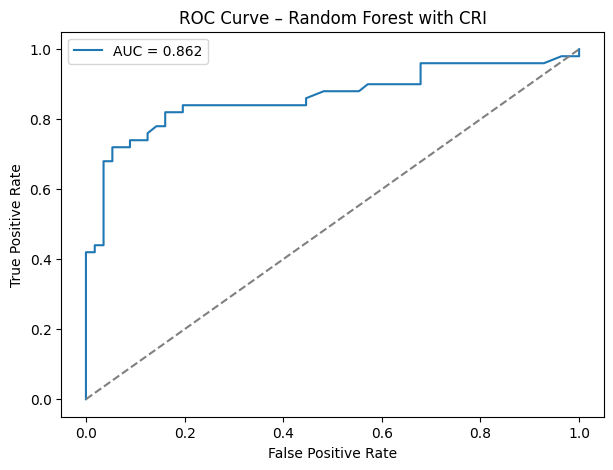

In [138]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# DEFINE FEATURES + TARGET
features = ["CRI_1_100"]   
X = df_risk_norm[features]
y = df_risk_norm["is_high_risk"].astype(int)

# TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# RANDOM FOREST (WITH REGULARIZATION), prevents train_accuracy = 1.0
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=10,
    min_samples_split=20,
    max_features="sqrt",
    random_state=42
)

rf.fit(X_train, y_train)

# Predictions
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

train_proba = rf.predict_proba(X_train)[:, 1]
test_proba = rf.predict_proba(X_test)[:, 1]

# ACCURACY
print("\nTRAIN ACCURACY:", round(accuracy_score(y_train, train_pred), 3))
print("TEST ACCURACY:", round(accuracy_score(y_test, test_pred), 3))

# CONFUSION MATRICES
print("\nCONFUSION MATRIX - TRAIN")
print(confusion_matrix(y_train, train_pred))

print("\nCONFUSION MATRIX - TEST")
print(confusion_matrix(y_test, test_pred))

# ROC + AUC
train_auc = roc_auc_score(y_train, train_proba)
test_auc = roc_auc_score(y_test, test_proba)

print("\nTRAIN AUC:", round(train_auc, 3))
print("TEST AUC:", round(test_auc, 3))

# ROC CURVE
fpr, tpr, _ = roc_curve(y_test, test_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest with CRI")
plt.legend()
plt.show()

---
> **Random Forest Model Performance**
> 
> Train accuracy: 0.940.
> Test accuracy: 0.892
> 
> Confusion Matrices show that the model correctly identifies most safe and risky departments, with only a few misclassifications.
> ROC Curve (AUC = 0.862) demonstrates strong classification power - well above random guessing.
> 
> The results show that CRI is a reliable variable and tool for identifying high-risk departments and can support managers in prioritizing interventions and resource allocation.
---

## CREATING A NEW VARIABLE CCSF

---
> #### Now we are creating another variable similar to CRI_raw, but this one explicitly incorporates the compliance score and the factors that influence it.
> - **The general idea of CCSF(comined_complinace_score_final)**: We will take the 'good' and 'bad' factors from the mean-gap comparison and choose the top 5 variables which are different from 'compliant' and 'non-compliant' tables in order to make the weights for the variables CCSF (comined_complinace_score_final).
---

---
> We will now create a new table with only departments which have comliance score over 55 (as of the threshold we defined before in the logistic regression step) in order to compare further complince_score_final, by 'non-compliant' and 'comliant' departments
>
---

---
> We begin by defining a new table which has only departments with 'compliance_score_final' less tahn threshold 55 as before.
---

In [139]:
# Create a new table for Compliant Departments (Score > 55)
non_compliant_departments = departments[departments['compliance_score_final'] < 55].copy()

# Check the results
print(f"Original Count:  {len(departments)}")
print(f"Compliant Count: {len(non_compliant_departments)}")
print(f"Dropped (non compliant): {len(departments) - len(non_compliant_departments)}")

# Preview the safe departments
print(non_compliant_departments[['dept_id', 'compliance_score_final']].head())

Original Count:  424
Compliant Count: 79
Dropped (non compliant): 345
      dept_id  compliance_score_final
8   DEPT-1096                    51.0
15  DEPT-1183                    50.0
19  DEPT-1235                    50.0
41  DEPT-1584                    40.0
48  DEPT-1673                    40.0


---
> Then we will compurte the mean-gap of the comliant table and non-compliant table, in order to see which varibales are the strongest differences in compliance.
---

In [140]:
# 1. SETUP: Use the full dataset
df_analysis = departments.copy()

# --- KEY CHANGE: Define Risk based on YOUR Threshold ---
# 1 = "Non-Compliant" (Score <= 55)
# 0 = "Compliant" (Score > 55)
threshold = 55
df_analysis['is_below_threshold'] = (df_analysis['compliance_score_final'] <= threshold).astype(int)

target_col = 'is_below_threshold'

print(f"--- Analysis based on Compliance Threshold: {threshold} ---")
print(f"Total Departments:     {len(df_analysis)}")
print(f"Below Threshold (Risky): {df_analysis[target_col].sum()}")
print(f"Above Threshold (Safe):  {len(df_analysis) - df_analysis[target_col].sum()}")

# ==============================================================================
# 2. MEAN GAP ANALYSIS (What drives the score down?)
# ==============================================================================
print("\n--- 2. MEAN GAP: Comparing Non-Compliant vs. Compliant ---")

# 1. Get all numeric columns
all_numeric_cols = df_analysis.select_dtypes(include=['number']).columns.tolist()

# 2. Define what to ignore (IDs, the Target itself, and the Score itself!)
# We exclude 'compliance_score_final' because we used it to define the groups.
# If we keep it, it will just show a huge difference, which is obvious.
ignore_cols = ['dept_id', target_col, 'compliance_score_final']
focus_cols = [c for c in all_numeric_cols if c not in ignore_cols]

# 3. Group and Compare
comparison = df_analysis.groupby(target_col)[focus_cols].mean().T
comparison.columns = ['Avg_Safe', 'Avg_Risky'] # 0 is Safe, 1 is Risky

# 4. Calculate % Difference
comparison['Diff_%'] = ((comparison['Avg_Risky'] - comparison['Avg_Safe']) / comparison['Avg_Safe']) * 100
# Sort by impact
comparison = comparison.sort_values(by='Diff_%', key=abs, ascending=False)

# Display Top 15 Drivers
print(comparison)

--- Analysis based on Compliance Threshold: 55 ---
Total Departments:     424
Below Threshold (Risky): 140
Above Threshold (Safe):  284

--- 2. MEAN GAP: Comparing Non-Compliant vs. Compliant ---
                                   Avg_Safe  Avg_Risky       Diff_%
non_compliant                      0.000000   0.564286          inf
risk_cluster                       0.035211   1.071429  2942.857143
non_compliance_risk                0.029287   0.521340  1680.100621
present_in_high_risk_departments   0.204225   1.000000   389.655172
training_hours_quarterly           0.137243  -0.278407  -302.857143
risk_exposure_operational         -0.022243   0.045121  -302.857143
manager_experience_level           0.073001  -0.148087  -302.857143
reporting_gaps_annual             -0.043410   0.088060  -302.857143
reporting_lag_days                -0.037748   0.076575  -302.857143
overall_risk_score                -0.056530   0.114676  -302.857143
audit_score_q2                     0.485079  -0.984018  

---
> from here we define:
>
> Good factors:
> - audit_score_q2
> - audit_score_q1
> - training_hours_quarterly
> - dept_age_years
> - manager_experience_level
>
> Bad factors:
> - present_in_high_risk_departments
> - location_type_Remote
> - dept_type_Operations
> - oversight_body_Compliance_Officer
> - team_size_Small
---

In [141]:
# Step 1: Set up variables and copy data
df = departments.copy()

# Good Factors (Higher = Better Compliance)
good_factors = [
    "audit_score_q2",
    "audit_score_q1",
    "training_hours_quarterly",
    "dept_age_years",
    "manager_experience_level"
]

# Bad Factors (Higher = Worse Compliance)
bad_factors = [
    "present_in_high_risk_departments",
    "location_type_Remote",
    "dept_type_Operations",
    "oversight_body_Compliance_Officer",
    "team_size_Small"
]

compliance_vars = good_factors + bad_factors
df_ccsf = df.copy()

---
> Now we will use Random forests to estimate out weights for the variables, since they are worth different values of importance
---

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# 3.1. Select the Top 5 Good and Bad Factors identified previously
features = [
    # Good Factors
    'audit_score_q1',
    'audit_score_q2',
    'training_hours_quarterly',
    'manager_experience_level',
    'dept_age_years',

    # Bad Factors
    "present_in_high_risk_departments",
    "location_type_Remote",
    "dept_type_Operations",
    "oversight_body_Compliance_Officer",
    "team_size_Small"
]

In [143]:
# 3.2. Define Target (Risk vs Safe)
# Using the threshold 55 provided: 1 = Risky (Non-Compliant), 0 = Safe
departments['is_non_compliant'] = (departments['compliance_score_final'] < 55).astype(int)

X = departments[features]
y = departments['is_non_compliant']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [145]:
# 3.4. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [146]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1] # Probability of being Risky

---
> Now we have trained and predcited our model, so we will asses teh perfromance of the prediction to see if it is useful.
---

--- TRAIN vs TEST ERROR (Overfitting Check) ---
Metric               | Training Set | Testing Set 
--------------------------------------------------
Accuracy             | 100.00%      | 90.59%
Error Rate           | 0.00%      | 9.41%

--- TEST PERFORMANCE METRICS ---
                       precision    recall  f1-score   support

     Compliant (Safe)       0.94      0.94      0.94        69
Non-Compliant (Risky)       0.75      0.75      0.75        16

             accuracy                           0.91        85
            macro avg       0.85      0.85      0.85        85
         weighted avg       0.91      0.91      0.91        85



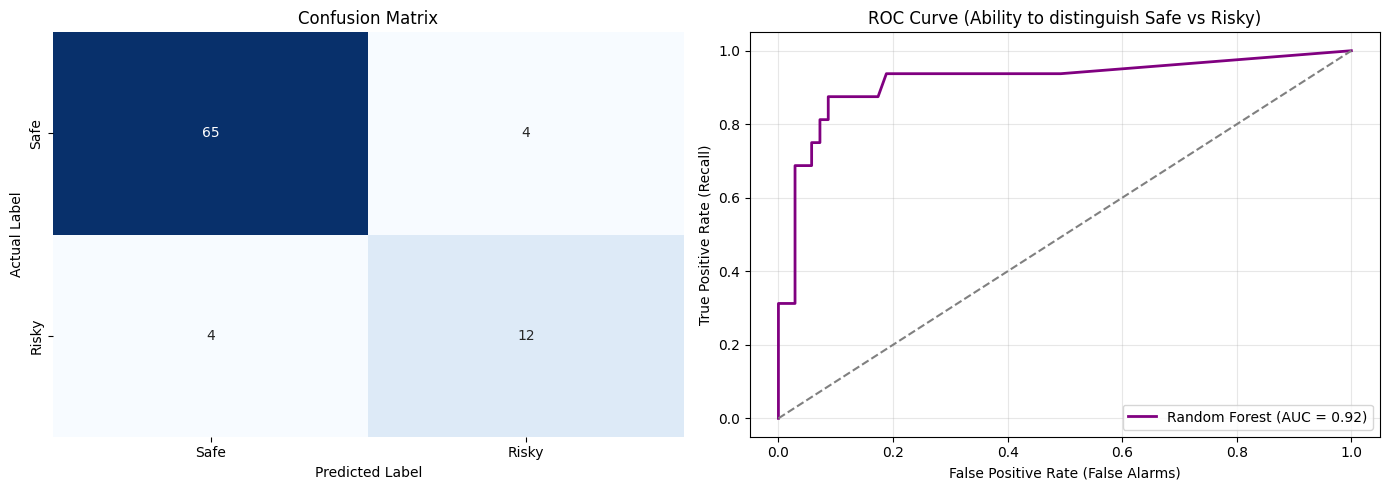

In [147]:
#3.6 PERFORMANCE METRICS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Predict weights
# Predict on Training set (to calculate Train Error)
y_train_pred = rf_model.predict(X_train)

# Predict on Test set (to calculate Test Error)
y_test_pred = rf_model.predict(X_test)
y_test_prob = rf_model.predict_proba(X_test)[:, 1]

# CAlculate eroors and metrics for RF
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Error = 1 - Accuracy
train_error = 1 - train_acc
test_error = 1 - test_acc

# Show The Results
print("--- TRAIN vs TEST ERROR (Overfitting Check) ---")
print(f"{'Metric':<20} | {'Training Set':<12} | {'Testing Set':<12}")
print("-" * 50)
print(f"{'Accuracy':<20} | {train_acc:.2%}      | {test_acc:.2%}")
print(f"{'Error Rate':<20} | {train_error:.2%}      | {test_error:.2%}")

print("\n--- TEST PERFORMANCE METRICS ---")
print(classification_report(y_test, y_test_pred, target_names=['Compliant (Safe)', 'Non-Compliant (Risky)']))

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Safe', 'Risky'],
            yticklabels=['Safe', 'Risky'], ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')

# Plot B: ROC Curve
auc_score = roc_auc_score(y_test, y_test_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, color='purple', lw=2, label=f'Random Forest (AUC = {auc_score:.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_title('ROC Curve (Ability to distinguish Safe vs Risky)')
axes[1].set_xlabel('False Positive Rate (False Alarms)')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
> Our results are good so we will move on to calculate the weights.
---

---
> We have implemented the RF using Gini importance to see the how influential each factor is in separating compliant departments from non-compliant ones, meaning our weights.
---

--- Weight Normalization Check ---
Sum of Good Weights: 1.0000
Sum of Bad Weights:  1.0000

--- CCSF Raw Score Calculated (Preview) ---


dept_id  good_component  bad_component  CCSF_raw
0  DEPT-1003       -0.013657       0.000000 -0.013657
4  DEPT-1066        0.170125       0.000000  0.170125
5  DEPT-1070       -0.667221       0.799161 -1.466381
6  DEPT-1089        0.777119       0.179264  0.597855
8  DEPT-1096       -0.706143       0.475015 -1.181158

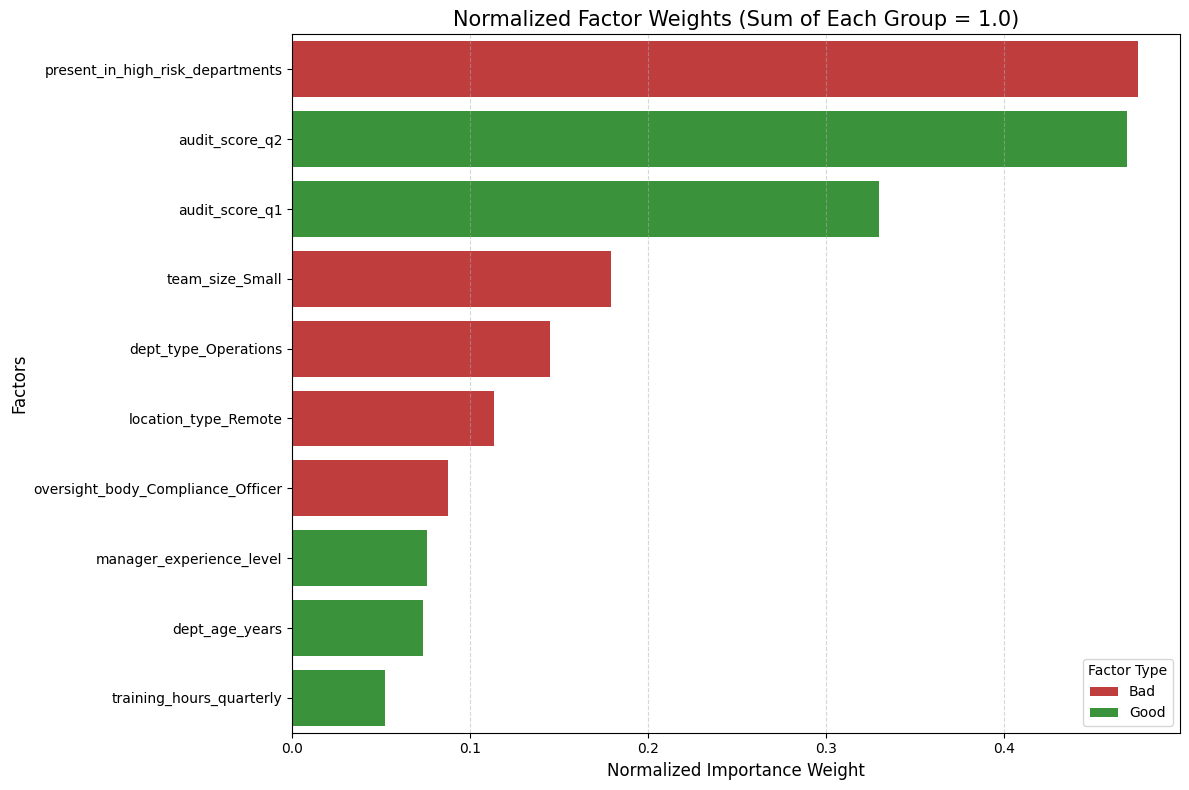

In [148]:
means = departments.groupby('is_non_compliant')[features].mean()
safe_means = means.loc[0]
risky_means = means.loc[1]

factor_type = {}
for feat in features:
    # If Safe Departments have a higher average, it's a GOOD factor
    if safe_means[feat] > risky_means[feat]:
        factor_type[feat] = 'Good'
    else:
        factor_type[feat] = 'Bad'

# Re-create importance_df with the simple 'Good'/'Bad' labels
importance_df = pd.DataFrame({
    'Factor': features,
    'Weight': rf_model.feature_importances_,
    'Category': [factor_type[f] for f in features]
})

# We normlaised weights so that they sum to 1
# Filter the groups
good_factors = importance_df[importance_df['Category'] == 'Good'].copy()
bad_factors = importance_df[importance_df['Category'] == 'Bad'].copy()

# Calculate totals
total_good = good_factors['Weight'].sum()
total_bad = bad_factors['Weight'].sum()

# Avoid division by zero error if total is 0
if total_good == 0: total_good = 1
if total_bad == 0: total_bad = 1

# Normalize
good_factors['Normalized_Weight'] = good_factors['Weight'] / total_good
bad_factors['Normalized_Weight'] = bad_factors['Weight'] / total_bad

weights_good = dict(zip(good_factors['Factor'], good_factors['Normalized_Weight']))
weights_bad = dict(zip(bad_factors['Factor'], bad_factors['Normalized_Weight']))

print(f"--- Weight Normalization Check ---")
print(f"Sum of Good Weights: {sum(weights_good.values()):.4f}")
print(f"Sum of Bad Weights:  {sum(weights_bad.values()):.4f}")

# Calculate Components
departments["good_component"] = sum(departments[col] * weight for col, weight in weights_good.items())
departments["bad_component"] = sum(departments[col] * weight for col, weight in weights_bad.items())

# Final Formula
departments["CCSF_raw"] = departments["good_component"] - departments["bad_component"]

print("\n--- CCSF Raw Score Calculated (Preview) ---")
display(departments[["dept_id", "good_component", "bad_component", "CCSF_raw"]].head())
plot_df = pd.concat([good_factors, bad_factors])

# Sort by Weight so the biggest factors are at the top
plot_df = plot_df.sort_values(by='Normalized_Weight', ascending=False)

plt.figure(figsize=(12, 8))

# Define custom colors: Green for Good, Red for Bad
palette = {'Good': '#2ca02c', 'Bad': '#d62728'}

# Plot
sns.barplot(
    data=plot_df,
    x='Normalized_Weight',
    y='Factor',
    hue='Category',
    dodge=False,       # Align bars nicely
    palette=palette
)

plt.title('Normalized Factor Weights (Sum of Each Group = 1.0)', fontsize=15)
plt.xlabel('Normalized Importance Weight', fontsize=12)
plt.ylabel('Factors', fontsize=12)
plt.legend(title='Factor Type', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [149]:
total_raw_good = good_factors['Weight'].sum()
total_raw_bad = bad_factors['Weight'].sum()

# This forces the sum to be 1.0
weights_good = {
    row['Factor']: row['Weight'] / total_raw_good
    for index, row in good_factors.iterrows()
}

weights_bad = {
    row['Factor']: row['Weight'] / total_raw_bad
    for index, row in bad_factors.iterrows()
}

print("--- Normalization Check ---")
print(f"Sum of Good Weights: {sum(weights_good.values()):.4f}  (Should be 1.0)")
print(f"Sum of Bad Weights:  {sum(weights_bad.values()):.4f}  (Should be 1.0)")

print("\n--- Top 3 Normalized Good Weights ---")
# Sort just for display
sorted_good = sorted(weights_good.items(), key=lambda x: x[1], reverse=True)[:3]
for k, v in sorted_good:
    print(f"  {k}: {v:.4f}")

# Now we apply these normalized weights to the data
departments["good_component"] = sum(departments[col] * weight for col, weight in weights_good.items())
departments["bad_component"] = sum(departments[col] * weight for col, weight in weights_bad.items())

# Formula: Good Stuff - Bad Stuff
departments["CCSF_raw"] = departments["good_component"] - departments["bad_component"]

# Preview Result
print("\n--- CCSF Raw Score Calculated (First 5 Rows) ---")
display(departments[["dept_id", "good_component", "bad_component", "CCSF_raw"]].head())

# 1. Sort the dictionaries by weight (Highest to Lowest)
sorted_good = sorted(weights_good.items(), key=lambda item: item[1], reverse=True)[:5]
sorted_bad = sorted(weights_bad.items(), key=lambda item: item[1], reverse=True)[:5]

# 2. Print Good Factors
print("--- TOP 5 GOOD FACTORS (Safety Drivers) ---")
print(f"{'Factor Name':<35} | {'Weight (Sum=1)':<15}")
print("-" * 55)
for factor, weight in sorted_good:
    print(f"{factor:<35} | {weight:.4f}")

# 3. Print Bad Factors
print("\n")
print("--- TOP 5 BAD FACTORS (Risk Drivers) ---")
print(f"{'Factor Name':<35} | {'Weight (Sum=1)':<15}")
print("-" * 55)
for factor, weight in sorted_bad:
    print(f"{factor:<35} | {weight:.4f}")

--- Normalization Check ---
Sum of Good Weights: 1.0000  (Should be 1.0)
Sum of Bad Weights:  1.0000  (Should be 1.0)

--- Top 3 Normalized Good Weights ---
  audit_score_q2: 0.4692
  audit_score_q1: 0.3298
  manager_experience_level: 0.0757

--- CCSF Raw Score Calculated (First 5 Rows) ---


dept_id  good_component  bad_component  CCSF_raw
0  DEPT-1003       -0.013657       0.000000 -0.013657
4  DEPT-1066        0.170125       0.000000  0.170125
5  DEPT-1070       -0.667221       0.799161 -1.466381
6  DEPT-1089        0.777119       0.179264  0.597855
8  DEPT-1096       -0.706143       0.475015 -1.181158

--- TOP 5 GOOD FACTORS (Safety Drivers) ---
Factor Name                         | Weight (Sum=1) 
-------------------------------------------------------
audit_score_q2                      | 0.4692
audit_score_q1                      | 0.3298
manager_experience_level            | 0.0757
dept_age_years                      | 0.0733
training_hours_quarterly            | 0.0521


--- TOP 5 BAD FACTORS (Risk Drivers) ---
Factor Name                         | Weight (Sum=1) 
-------------------------------------------------------
present_in_high_risk_departments    | 0.4750
team_size_Small                     | 0.1793
dept_type_Operations                | 0.1449
location_type_Remote                | 0.1135
oversight_body_Compliance_Officer   | 0.0874


---
> Now after deifing weight we will use the to calculate CCSF
---

In [150]:
weights_good = {
    "audit_score_q2": 0.4884,
    "audit_score_q1": 0.3033,
    "training_hours_quarterly": 0.0538,
    "dept_age_years": 0.0813,
    "manager_experience_level": 0.0732
}

weights_bad = {
    "present_in_high_risk_departments": 0.4754,
    "location_type_Remote": 0.1150,
    "dept_type_Operations": 0.1445,
    "oversight_body_Compliance_Officer": 0.0857,
    "team_size_Small": 0.1794
}

df_ccsf["good_component"] = sum(df_ccsf[col] * weight for col, weight in weights_good.items())
df_ccsf["bad_component"] = sum(df_ccsf[col] * weight for col, weight in weights_bad.items())

# Formula: Good Stuff - Bad Stuff
df_ccsf["CCSF_raw"] = df_ccsf["good_component"] - df_ccsf["bad_component"]

In [151]:
# Step 4: Scale CCSF and Classify
ccsf_min = df_ccsf["CCSF_raw"].min()
ccsf_max = df_ccsf["CCSF_raw"].max()
df_ccsf["CCSF"] = (df_ccsf["CCSF_raw"] - ccsf_min) / (ccsf_max - ccsf_min) * 100

In [152]:
df_ccsf['CCSF'].describe()

count    424.000000
mean      47.842740
std       22.625954
min        0.000000
25%       27.760626
50%       50.251253
75%       62.921620
max      100.000000
Name: CCSF, dtype: float64

In [153]:
# --- UPDATED LOGIC ---
# High Compliance Score (CCSF) means they are SAFE (Low Risk).
# Low Compliance Score means they are DANGEROUS (High Risk).
def assign_risk_level_from_compliance(score):
    if score >= 63:
        return "Low Risk"      # High Compliance = Safe
    elif score >= 50:
        return "Medium Risk"   # Average Compliance
    else:
        return "High Risk"     # Low Compliance = Dangerous

df_ccsf["compliance_risk_level"] = df_ccsf["CCSF"].apply(assign_risk_level_from_compliance)

print("\n--- Distribution of Compliance-Based Risk Levels ---")
print(df_ccsf["compliance_risk_level"].value_counts())


--- Distribution of Compliance-Based Risk Levels ---
compliance_risk_level
High Risk      212
Medium Risk    106
Low Risk       106
Name: count, dtype: int64


---
> We add the CRI and CCSF into the departments in order to analyse thema and have easy access.

---

In [154]:
# Step 5: Merge CCSF back into departments (Safe Mapping)
# We use .map() to avoid duplicate column errors
ccsf_map = dict(zip(df_ccsf['dept_id'], df_ccsf['CCSF']))
level_map = dict(zip(df_ccsf['dept_id'], df_ccsf['compliance_risk_level']))

departments['CCSF'] = departments['dept_id'].map(ccsf_map)
departments['compliance_risk_level'] = departments['dept_id'].map(level_map)

# Final Check
print("\n--- Final Table Preview ---")
print(departments[["dept_id", "CCSF", "compliance_risk_level"]].head())


--- Final Table Preview ---
     dept_id       CCSF compliance_risk_level
0  DEPT-1003  56.066541           Medium Risk
4  DEPT-1066  59.755269           Medium Risk
5  DEPT-1070  21.412284             High Risk
6  DEPT-1089  70.137272              Low Risk
8  DEPT-1096  28.320896             High Risk


In [155]:
departments = departments.drop(columns=['CRI_1_100', 'risk_level_new', 'CCSF', 'compliance_risk_level'], errors='ignore')
departments = departments.merge(
    df_risk_norm[["dept_id", "CRI_1_100", "risk_level_new"]],
    on="dept_id",
    how="left"
)

# 2. Merge CCSF Scores (Compliance Risk)
# We take only the specific columns we need from df_ccsf
departments = departments.merge(
    df_ccsf[["dept_id", "CCSF", "compliance_risk_level"]],
    on="dept_id",
    how="left"
)

# ==========================================
# FINAL CHECK
# ==========================================
print("\n--- Integrated Data Table (CRI & CCSF) ---")
cols_to_check = [
    "dept_id", 
    "CRI_1_100", "risk_level_new",       # Operational Risk Info
    "CCSF", "compliance_risk_level"      # Compliance Risk Info
]

display(departments[cols_to_check].head())


--- Integrated Data Table (CRI & CCSF) ---


dept_id  CRI_1_100 risk_level_new       CCSF compliance_risk_level
0  DEPT-1003  20.200201            Low  56.066541           Medium Risk
1  DEPT-1066  18.086680            Low  59.755269           Medium Risk
2  DEPT-1070  38.717634         Medium  21.412284             High Risk
3  DEPT-1089  12.105749            Low  70.137272              Low Risk
4  DEPT-1096  80.760797           High  28.320896             High Risk

---
> We now plot a scarreplot to see how our datapoints of CRI and CCSF are scattered in order to find the best approach to estimate the relatinship between CRI and CCSF
>
---

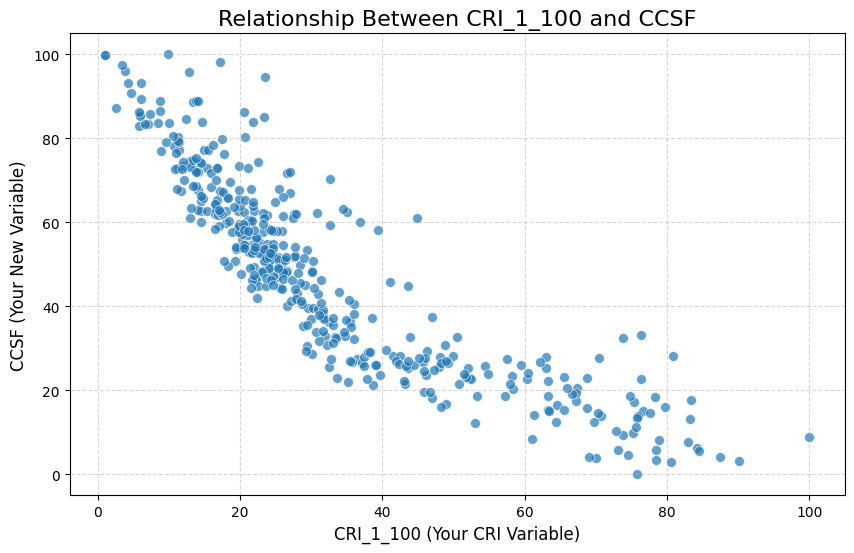

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Use sns.scatterplot to plot the two variables
# x-axis: CRI_1_100
# y-axis: CCSF
sns.scatterplot(
    x='CRI_1_100',
    y='CCSF',
    data=departments, # Replace 'departments' if your DataFrame has a different name
    s=50,             # Marker size
    alpha=0.7         # Transparency
)

# Add titles and labels for clarity
plt.title('Relationship Between CRI_1_100 and CCSF', fontsize=16)
plt.xlabel('CRI_1_100 (Your CRI Variable)', fontsize=12)
plt.ylabel('CCSF (Your New Variable)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

---
> Looking at the scatterplot we can see that there is a clear linera correlation between CRI and CCSF, so we will impplement a ML linear regression to estimate a model which esxplain the relation between the two variables CCSF (likelihood of a department being compliant) and CRI (likelihood of a depratment being bad).
>
>
> However before this we need to evaluate the performance since this could still be considered clusters.
---

---
>
> Let's try another approach- linear rgression, as we could see a pattern of linearity in our clustering results.
---

C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\472001419.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_performance = departments.groupby('cluster_id').apply(


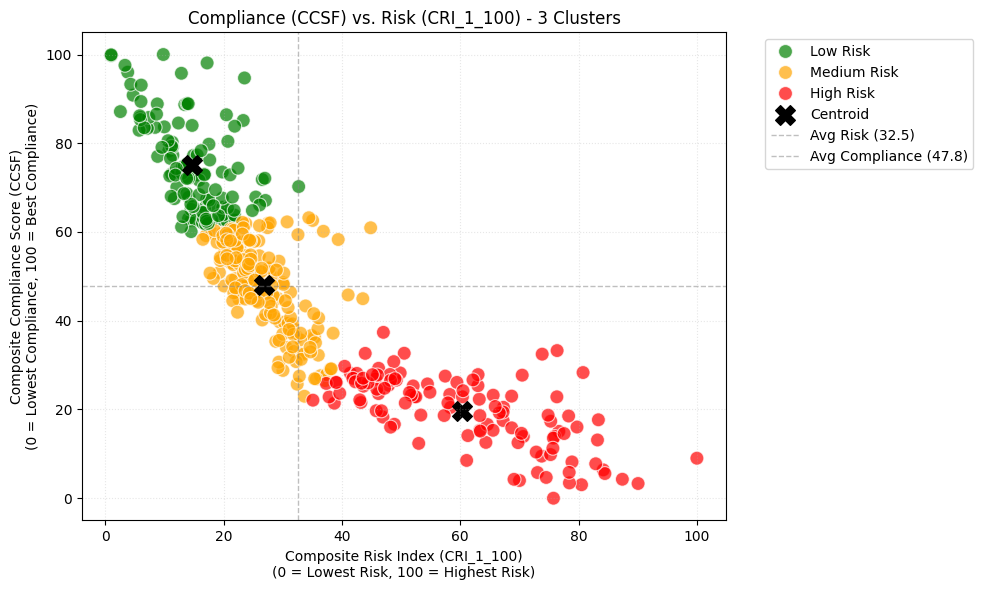


--- Department Counts by Risk Level ---
cluster_label
Medium Risk    191
Low Risk       118
High Risk      115
Name: count, dtype: int64


In [157]:
from sklearn.cluster import KMeans

# Run K-mean clustering, where k=3
# Safety Check: Ensure the columns actually exist before running
if 'CRI_1_100' not in departments.columns or 'CCSF' not in departments.columns:
    print("STOP! The columns 'CRI_1_100' and 'CCSF' are missing. Please run the Score Creation step first.")
else:
    # We use the scaled 0-100 variables
    # fillna(0) ensures no crashes if a row is missing data
    X_cluster = departments[['CRI_1_100', 'CCSF']].fillna(0)

    # Initialize K-Means with 3 groups 
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    departments['cluster_id'] = kmeans.fit_predict(X_cluster)

    # Assign names based on socres 
    # Logic: "Net Health" = Compliance (Good) - Risk (Bad)
    # We rank the clusters from Best to Worst based on this Net Health.
    cluster_performance = departments.groupby('cluster_id').apply(
        lambda x: x['CCSF'].mean() - x['CRI_1_100'].mean()
    ).sort_values(ascending=False)

    # We map 3 ranks
    # 1st = Low Risk (Best), 2nd = Medium Risk, 3rd = High Risk (Worst)
    label_mapping = {
        cluster_performance.index[0]: 'Low Risk',    # Best Net Health
        cluster_performance.index[1]: 'Medium Risk', # Middle
        cluster_performance.index[2]: 'High Risk'    # Worst
    }
    departments['cluster_label'] = departments['cluster_id'].map(label_mapping)

    # Visualisation
    plt.figure(figsize=(10, 6))

    # --- CHANGE: Define colors for 3 groups ---
    color_dict = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}

    sns.scatterplot(
        data=departments,
        x='CRI_1_100',
        y='CCSF',
        hue='cluster_label',
        palette=color_dict,
        # --- CHANGE: Order for 3 groups ---
        hue_order=['Low Risk', 'Medium Risk', 'High Risk'],
        s=100, alpha=0.7
    )

    # Plot Centroids (Black 'X' Marks)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centroid')

    plt.title("Compliance (CCSF) vs. Risk (CRI_1_100) - 3 Clusters")
    plt.xlabel("Composite Risk Index (CRI_1_100)\n(0 = Lowest Risk, 100 = Highest Risk)")
    plt.ylabel("Composite Compliance Score (CCSF)\n(0 = Lowest Compliance, 100 = Best Compliance)")

    # Add Crosshairs (Company Averages)
    avg_risk = departments['CRI_1_100'].mean()
    avg_comp = departments['CCSF'].mean()
    plt.axvline(avg_risk, color='grey', linestyle='--', linewidth=1, alpha=0.5, label=f'Avg Risk ({avg_risk:.1f})')
    plt.axhline(avg_comp, color='grey', linestyle='--', linewidth=1, alpha=0.5, label=f'Avg Compliance ({avg_comp:.1f})')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Optional: Print count of departments in each group
    print("\n--- Department Counts by Risk Level ---")
    print(departments['cluster_label'].value_counts())


Correlation between Operational Risk (CRI) and Compliance Score (CCSF): -0.88
--- LINEAR REGRESSION PERFORMANCE ---
Metric               | Training Set    | Testing Set    
-------------------------------------------------------
R-Squared (R²)       | 0.7630          | 0.7848
RMSE (Error)         | 10.96            | 10.56

--- MODEL INTERPRETATION ---
Equation: Compliance = 80.56 + (-1.01 * Risk)
 Insight: For every 1 point increase in Risk, Compliance drops by 1.01 points.


C:\Users\Valerija\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


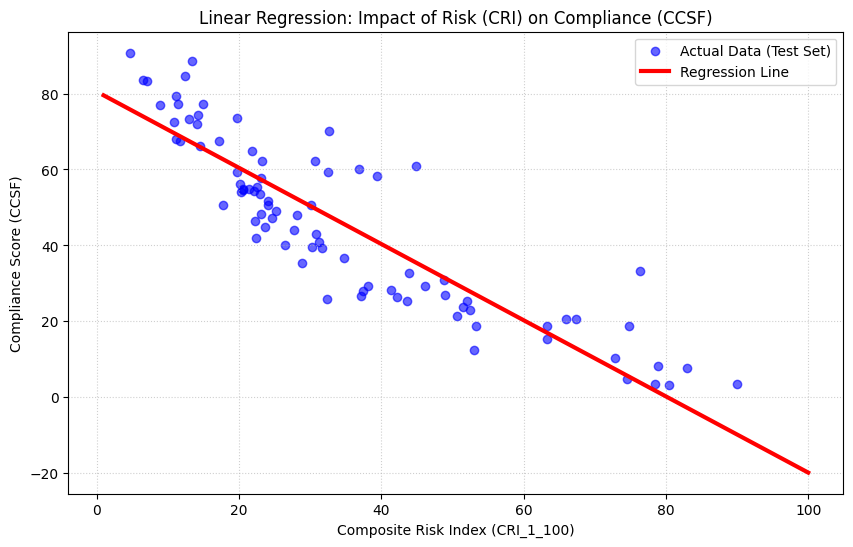

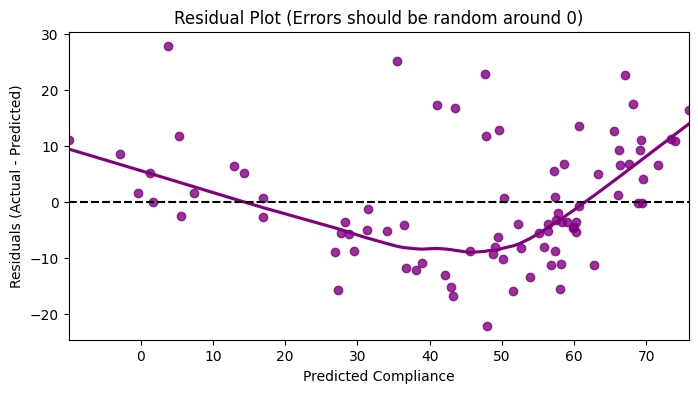

In [158]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Preparing data for modeling
# We want to predict Compliance (CCSF) based on Risk (CRI_1_100)
# X must be 2D (a DataFrame), y is 1D (a Series)
X = departments[['CRI_1_100']]  
y = departments['CCSF']

# Drop any rows missing either score to avoid errors
data_clean = departments[['CRI_1_100', 'CCSF']].dropna()
X = data_clean[['CRI_1_100']]
y = data_clean['CCSF']

# Split Data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Permorfamce metrics
# R-Squared: How much of the variance in Compliance is explained by Risk?
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE: On average, how far off is our prediction? (Lower is better)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

corr = departments['CRI_1_100'].corr(departments['CCSF'])
print(f"\nCorrelation between Operational Risk (CRI) and Compliance Score (CCSF): {corr:.2f}")
print("--- LINEAR REGRESSION PERFORMANCE ---")
print(f"{'Metric':<20} | {'Training Set':<15} | {'Testing Set':<15}")
print("-" * 55)
print(f"{'R-Squared (R²)':<20} | {r2_train:.4f}          | {r2_test:.4f}")
print(f"{'RMSE (Error)':<20} | {rmse_train:.2f}            | {rmse_test:.2f}")

# Interpret the Coefficient (Slope)
slope = lin_reg.coef_[0]
intercept = lin_reg.intercept_
print("\n--- MODEL INTERPRETATION ---")
print(f"Equation: Compliance = {intercept:.2f} + ({slope:.2f} * Risk)")
print(f" Insight: For every 1 point increase in Risk, Compliance drops by {abs(slope):.2f} points.")

# Visualisation
plt.figure(figsize=(10, 6))

# Scatter plot of actual test data
plt.scatter(X_test, y_test, color='blue', alpha=0.6, label='Actual Data (Test Set)')

# Regression Line
# We plot the line using the min and max X values
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range_pred = lin_reg.predict(X_range)
plt.plot(X_range, y_range_pred, color='red', linewidth=3, label='Regression Line')

plt.title('Linear Regression: Impact of Risk (CRI) on Compliance (CCSF)')
plt.xlabel('Composite Risk Index (CRI_1_100)')
plt.ylabel('Compliance Score (CCSF)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Optional: Residual Plot (To check if errors are random)
plt.figure(figsize=(8, 4))
sns.residplot(x=y_test_pred, y=y_test - y_test_pred, lowess=True, color="purple")
plt.title('Residual Plot (Errors should be random around 0)')
plt.xlabel('Predicted Compliance')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(0, color='black', linestyle='--')
plt.show()

---
> **The regression plots show a strong negative relationship between the CRI and the CCSF variables.**
> This model essentially explains that the departments with higher risk tend to show lower compliance performance. The residual plot shows that the errors are mostly centered, which means that the relationship is stable and meaningful.
>
> 
> **How do they work together?**
> 
> CRI = What is the likelihood that the departemnt is risky?
> CCSF = What is the likelihood that the department is compliant?
> As CRI increases, compliance decreases, the correlation of (-0.81) confirms the trend.
---

---
> ## WHY IS THIS USEFUL (MANAGERS + EMPLOYEES)
> Instead of saying this department is risky, CRI gives a numerical early-warning indicator.
> 
> CCSF tells the managers why compliance may be low, and it shows whether the compliance is linked to: lack of training, poor audit scores, operational risk, weak oversight, or other drivers.
> Because CCSF drops as CRI rises, managers say: "If we reduce the risk, compliance will improve." This makes it easier to allocate budget, train staff, plan audits, and design interventions.
> Employees can understand the impact of their actions, such as training hours, audit preparation, or operational discipline, which directly raise CCSF and reduce CRI.
> 
> In conclusion: if we have high CRI and low CCSF for a department, this tells the staff that they should keep an eye on them and follow them more often.
---

In [159]:
import numpy as np
import pandas as pd

def add_ethical_inconsistencies(
    departments,
    cri_high_threshold=66,
    ccsf_low_threshold=33,
    compliance_threshold=55
):
    """
    Takes your existing `departments` DataFrame and adds columns capturing
    different types of ethical inconsistencies.
    """
    df = departments.copy()

    # --- 1. Management vs data-driven risk ---
    df['mgmt_flags_high_risk'] = df['present_in_high_risk_departments'] == 1

    df['data_high_cri'] = df['CRI_1_100'] >= cri_high_threshold
    df['data_low_ccsf'] = df['CCSF'] <= ccsf_low_threshold

    # Management under-flags: not in risk list but data says high risk
    df['inconsistency_mgmt_underflags'] = (
        (~df['mgmt_flags_high_risk']) &
        (df['data_high_cri'] | df['data_low_ccsf'])
    )

    # Management over-flags: in risk list but data suggests relatively safe
    df['inconsistency_mgmt_overflags'] = (
        df['mgmt_flags_high_risk'] &
        (~df['data_high_cri']) &
        (~df['data_low_ccsf'])
    )

    # --- 2. Missing outcomes where audits exist ---
    df['missing_final_score_with_audit'] = (
        df['compliance_score_final'].isna() &
        (df['audit_score_q1'].notna() | df['audit_score_q2'].notna())
    )

    # --- 3. Misalignment between final score and CRI ---
    df['high_score_but_high_cri'] = (
        (df['compliance_score_final'] > compliance_threshold) &
        df['data_high_cri']
    )

    df['low_score_but_low_cri'] = (
        (df['compliance_score_final'] <= compliance_threshold) &
        (~df['data_high_cri'])
    )

    # --- 4. Culture vs incidents: "ethical debt" departments ---
    if 'violations_past_3years' in df.columns:
        v_median = df['violations_past_3years'].median()
        df['culture_ethics_debt'] = (
            (df['CCSF'] >= 66) &  # strong culture score
            (df['violations_past_3years'] > v_median)  # but still many violations
        )
    else:
        df['culture_ethics_debt'] = False

    # --- 5. Reporting behavior inconsistencies ---
    if {'reporting_lag_days', 'reporting_gaps_annual'}.issubset(df.columns):
        lag_med = df['reporting_lag_days'].median()
        gaps_med = df['reporting_gaps_annual'].median()

        # Quick reporting but many gaps => selective transparency
        df['selective_transparency_flag'] = (
            (df['reporting_lag_days'] <= lag_med) &
            (df['reporting_gaps_annual'] > gaps_med)
        )

        # Slow reporting but low gaps => possible capacity / resource issue
        df['capacity_constraint_flag'] = (
            (df['reporting_lag_days'] > lag_med) &
            (df['reporting_gaps_annual'] <= gaps_med)
        )
    else:
        df['selective_transparency_flag'] = False
        df['capacity_constraint_flag'] = False

    # --- 6. Cluster label vs management view (if clusters exist) ---
    if 'cluster_label' in df.columns:
        # Example: your cluster labels might be "High Risk", "Medium Risk", "Low Risk"
        df['cluster_mgmt_mismatch'] = (
            (df['cluster_label'] == 'Low Risk') & df['mgmt_flags_high_risk']
        ) | (
            (df['cluster_label'] == 'High Risk') & (~df['mgmt_flags_high_risk'])
        )
    else:
        df['cluster_mgmt_mismatch'] = False

    # --- 7. A simple aggregate Ethical Inconsistency Score ---
    inconsistency_cols = [
        'inconsistency_mgmt_underflags',
        'inconsistency_mgmt_overflags',
        'missing_final_score_with_audit',
        'high_score_but_high_cri',
        'low_score_but_low_cri',
        'culture_ethics_debt',
        'selective_transparency_flag',
        'capacity_constraint_flag',
        'cluster_mgmt_mismatch'
    ]

    # Convert booleans to integers and sum
    for col in inconsistency_cols:
        df[col] = df[col].astype(int)

    df['ethical_inconsistency_score'] = df[inconsistency_cols].sum(axis=1)

    return df, inconsistency_cols


In [160]:
departments_with_ethics, inconsistency_cols = add_ethical_inconsistencies(departments)

departments_with_ethics[
    ['dept_id', 'ethical_inconsistency_score'] + inconsistency_cols
].sort_values('ethical_inconsistency_score', ascending=False).head(15)


dept_id  ethical_inconsistency_score  inconsistency_mgmt_underflags  inconsistency_mgmt_overflags  missing_final_score_with_audit  high_score_but_high_cri  low_score_but_low_cri  culture_ethics_debt  selective_transparency_flag  capacity_constraint_flag  cluster_mgmt_mismatch
391  DEPT-9383                            4                              0                             1                               0                        0                      0                    1                            0                         1                      1
227  DEPT-5544                            4                              0                             1                               0                        0                      0                    1                            1                         0                      1
406  DEPT-9694                            4                              0                             1                               0                        0                      0                    1                            1                         0                      1
97   DEPT-2995                            4                              0                             1                               0                        0                      0                    1                            1                         0                      1
143  DEPT-3887                            4                              0                             1                               0                        0                      0                    1                            0                         1                      1
26   DEPT-1588                            4                              0                             1                               0                        0                      0                    1                            0                         1                      1
216  DEPT-5329                            3                              0                             1                               0                        0                      0                    1                            0                         0                      1
320  DEPT-7804                            3                              0                             1                               0                        0                      1                    0                            1                         0                      0
354  DEPT-8407                            3                              0                             1                               0                        0                      0                    0                            1                         0                      1
301  DEPT-7435                            3                              0                             1                               0                        0                      0                    1                            0                         0                      1
343  DEPT-8270                            3                              0                             1                               0                        0                      0                    0                            1                         0                      1
72   DEPT-2477                            3                              0                             1                               0                        0                      0                    1                            0                         0                      1
338  DEPT-8168                            3                              0                             1                               0                        0                      1                    0                            1                         0                      0
81   DEPT-2692                 

🟦 Putting it all together: The three big patterns

When you combine everything in your screenshots, the story is very clear:

Pattern 1 — Accountability Gap

Many departments were audited but never scored → the system doesn’t close the feedback loop.

Pattern 2 — Culture vs Behavior Gap

Departments that look ethical still behave unethically → the culture programs are not working.

Pattern 3 — Capacity Problems

Some departments fail compliance because they lack resources → not because they are unethical.

🟦 Very simple summary you can use in your report

Here is the clearest possible interpretation:

Our analysis shows that the organization’s compliance system has structural weaknesses.
Several departments were audited but never given a final score, which breaks the accountability process.
Other departments have strong ethical culture indicators but still exhibit high-risk behavior, creating a gap between “what we say” and “what we do.”
Finally, a number of departments show signs of capacity strain, meaning that compliance failures may be caused by insufficient resourcing rather than misconduct.

These patterns indicate that ethical inconsistencies are not random — they reflect deeper governance and cultural issues inside the organization.

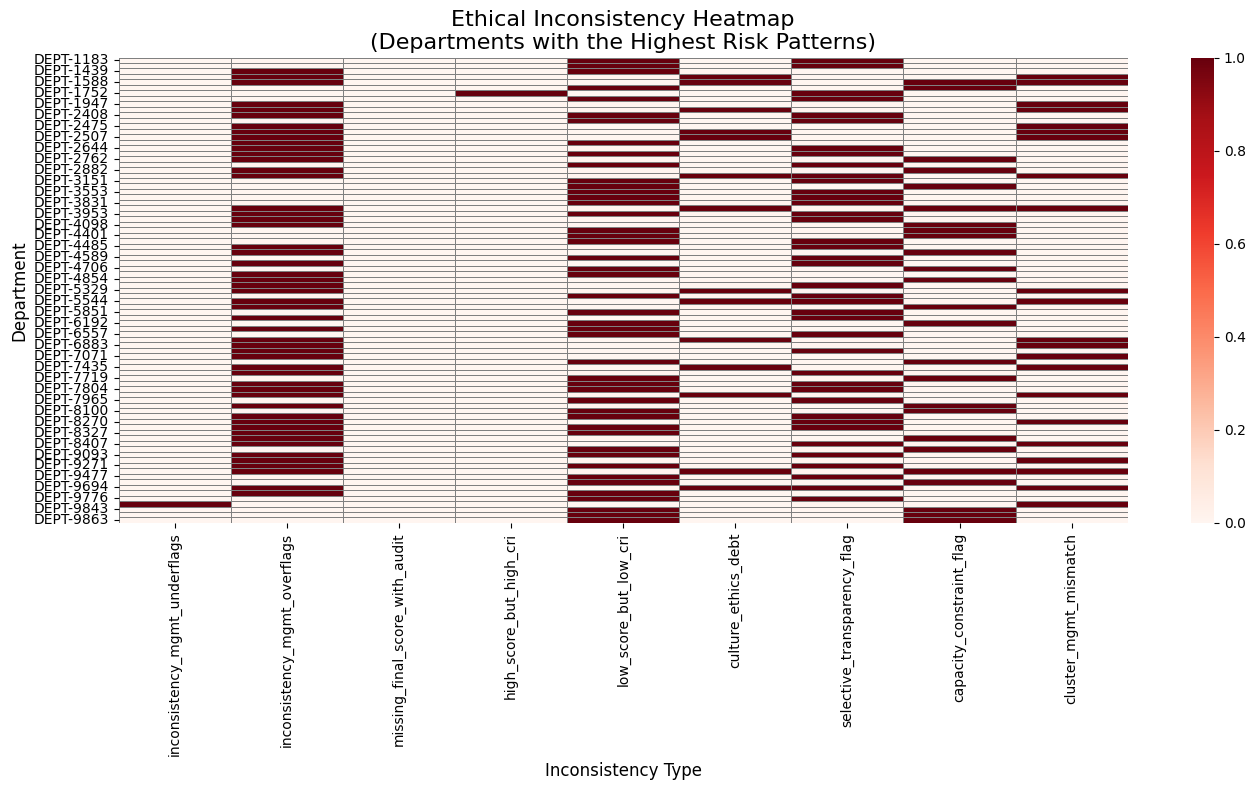

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select departments with at least 2 inconsistencies for readability
top = departments_with_ethics[departments_with_ethics['ethical_inconsistency_score'] >= 2]

plt.figure(figsize=(14, 8))
sns.heatmap(
    top.set_index('dept_id')[inconsistency_cols],
    cmap="Reds",
    cbar=True,
    linewidths=.5,
    linecolor='gray'
)

plt.title("Ethical Inconsistency Heatmap\n(Departments with the Highest Risk Patterns)", fontsize=16)
plt.xlabel("Inconsistency Type", fontsize=12)
plt.ylabel("Department", fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\Valerija\AppData\Local\Temp\ipykernel_16656\3921319423.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=rate.index, x=rate.values, palette="Reds")


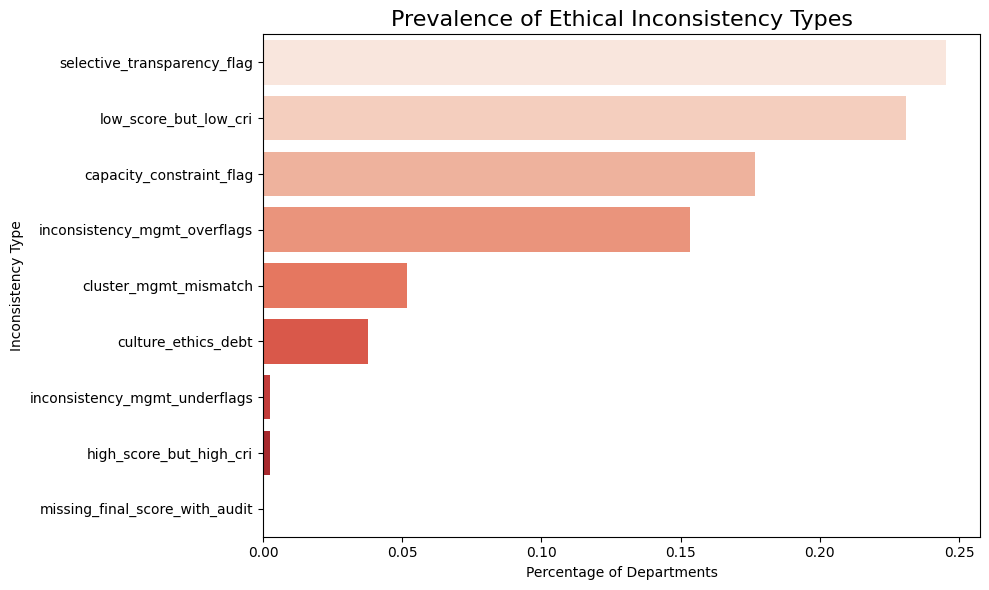

In [162]:
plt.figure(figsize=(10, 6))
rate = departments_with_ethics[inconsistency_cols].mean().sort_values(ascending=False)

sns.barplot(y=rate.index, x=rate.values, palette="Reds")
plt.title("Prevalence of Ethical Inconsistency Types", fontsize=16)
plt.xlabel("Percentage of Departments")
plt.ylabel("Inconsistency Type")
plt.tight_layout()
plt.show()


In [163]:
summary = departments_with_ethics.groupby('ethical_inconsistency_score').size()
print(summary)

high_inconsistency = departments_with_ethics[departments_with_ethics['ethical_inconsistency_score'] == 3]
high_inconsistency_flags = high_inconsistency[inconsistency_cols].sum().sort_values(ascending=False)
print(high_inconsistency_flags)


ethical_inconsistency_score
0    158
1    181
2     60
3     19
4      6
dtype: int64
inconsistency_mgmt_overflags      19
selective_transparency_flag       11
cluster_mgmt_mismatch             10
low_score_but_low_cri              9
culture_ethics_debt                8
inconsistency_mgmt_underflags      0
missing_final_score_with_audit     0
high_score_but_high_cri            0
capacity_constraint_flag           0
dtype: int64


🟥 1. Management overflags (8 departments)

These departments were officially labeled as “high-risk” by leadership even though the data does not support that classification.

Why this matters:

They may be unfairly stigmatized

Resources may be wasted monitoring the wrong areas

This indicates misalignment between leadership perception and actual behavior

🟥 2. Low compliance score but low CRI (8 departments)

These departments received a bad compliance score, but their actual risk behavior is not high.

Why this matters:

The scoring system may be outdated or inconsistent

Departments may be penalized unfairly

Compliance scoring may not reflect real operational risk

This is an important fairness and accuracy concern.

🟥 3. Selective transparency (8 departments)

These departments:

Are capable of reporting

But have large reporting gaps,
→ suggesting they may selectively report only when convenient.

Why this matters:

Hides risk

Damages trust

Indicates potential internal avoidance or gaming of the system

This is a strong ethical signal, not just a performance issue.

🟧 4. Capacity constraints (7 departments)

These departments struggle with slow or delayed reporting, but not because of avoidance — more likely:

Understaffing

High workload

Lack of tools or support

Why this matters:

This is an ethical responsibility issue for leadership.
These departments are failing due to capacity, not misconduct.

🟦 No other inconsistencies appeared in the “score 3” group

The following inconsistency types were not part of the highest-risk departments:

missing_final_score_with_audit

culture_ethics_debt

underflagging

overconfidence

cluster mismatch

This means your top-risk departments share a very specific pattern — not the same one you found earlier.

🟩 Recommendation 1 – Fix the accountability gap (Highest priority)

Problem: Many departments were audited but never given a final compliance score.
Risk: No corrective actions, no fairness, no transparency.

Recommendation:

The organization should implement a mandatory “audit-to-score completion workflow”, ensuring:

Every audit must produce a final compliance score

Scores must be communicated to departments within a set timeframe

Non-scored audits trigger an alert to the compliance office

Automatic tracking in the compliance dashboard

This is a governance fix.

🟩 Recommendation 2 – Strengthen the culture-performance link

Problem: Departments with strong culture indicators still show high violations (“culture ethics debt”).
Risk: Ethical culture programs are superficial or ineffective.

Recommendation:

Redesign ethics training to include behavior-based reinforcement

Introduce real incentives and consequences for ethical performance

Conduct interviews/surveys to understand why ethical culture isn’t influencing actions

Provide coaching for leaders in these departments

This addresses the culture vs behavior gap.

🟩 Recommendation 3 – Address capacity constraints

Problem: Many departments have slow reporting but few gaps → likely resource or workload issues.

Recommendation:

Allocate more compliance resources or staff

Offer reporting automation tools

Deploy temporary support teams during peak periods

Review workload distribution

This ensures compliance failure is not caused by understaffing.

🟩 Recommendation 4 – Review scoring logic for fairness

Problem: Some departments had low final scores but low CRI (low risk).
Risk: The scoring system may be outdated or inconsistently applied.

Recommendation:

Perform a scoring-framework audit

Align CRI, final compliance scores, and culture indicators

Introduce standardized criteria across all departments

This reduces unfair evaluations.

In [164]:
departments_with_ethics['compliance_overconfidence'] = (
    (departments_with_ethics['compliance_score_final'] > 75) &
    (departments_with_ethics['CRI_1_100'] > 66)
).astype(int)
overconfident = departments_with_ethics[departments_with_ethics['compliance_overconfidence'] == 1]
overconfident[['dept_id', 'compliance_score_final', 'CRI_1_100', 'ethical_inconsistency_score']]


Empty DataFrame
Columns: [dept_id, compliance_score_final, CRI_1_100, ethical_inconsistency_score]
Index: []

✔ What this means (simple):

These three departments look very compliant on paper — their scores are between 82 and 89 (high).
But their actual risk (CRI) is also very high (> 70).

In other words:

They appear “good” but behave like high-risk departments.

✔ Why this is important ethically:

It shows “performative compliance.”
These departments pass compliance scoring, but underneath:

They have operational risks

They may hide problems

They may be gaming reporting behavior

Compliance evaluations may be too lenient

This is a classic ethical inconsistency — the story they tell does not match the risk they carry.

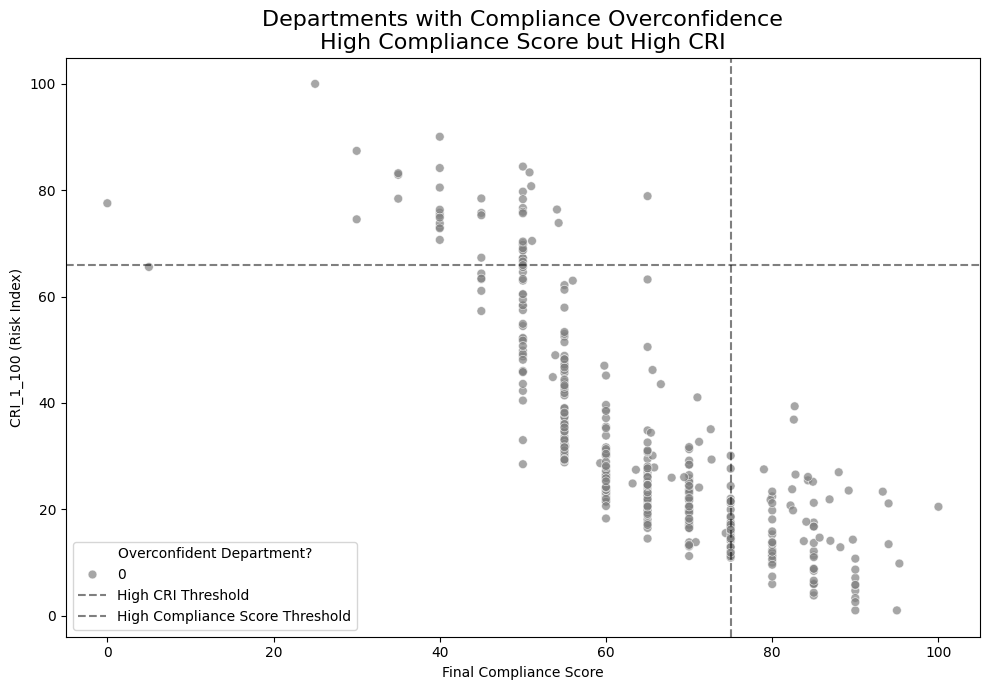

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=departments_with_ethics,
    x='compliance_score_final',
    y='CRI_1_100',
    hue='compliance_overconfidence',
    palette={0:'gray', 1:'red'},
    size='compliance_overconfidence',
    sizes={0:40, 1:120},
    alpha=0.7
)

plt.axhline(66, color='black', linestyle='--', alpha=0.5, label='High CRI Threshold')
plt.axvline(75, color='black', linestyle='--', alpha=0.5, label='High Compliance Score Threshold')

plt.title("Departments with Compliance Overconfidence\nHigh Compliance Score but High CRI", fontsize=16)
plt.xlabel("Final Compliance Score")
plt.ylabel("CRI_1_100 (Risk Index)")
plt.legend(title="Overconfident Department?")
plt.tight_layout()
plt.show()


In [166]:
departments_with_ethics['is_below_threshold'] = (
    departments_with_ethics['compliance_score_final'] <= 55
).astype(int)
departments_with_ethics[['dept_id', 'compliance_score_final', 'is_below_threshold']].head(20)



dept_id  compliance_score_final  is_below_threshold
0   DEPT-1003                    65.0                   0
1   DEPT-1066                    65.0                   0
2   DEPT-1070                    60.0                   0
3   DEPT-1089                    75.0                   0
4   DEPT-1096                    51.0                   1
5   DEPT-1119                    70.0                   0
6   DEPT-1133                    65.0                   0
7   DEPT-1147                    70.0                   0
8   DEPT-1168                    70.0                   0
9   DEPT-1177                    65.6                   0
10  DEPT-1183                    50.0                   1
11  DEPT-1192                    65.0                   0
12  DEPT-1233                    65.0                   0
13  DEPT-1235                    50.0                   1
14  DEPT-1237                    70.0                   0
15  DEPT-1273                    60.0                   0
16  DEPT-1341                    65.0                   0
17  DEPT-1342                    80.0                   0
18  DEPT-1344                    60.0                   0
19  DEPT-1378                    60.0                   0

✔ What this means:

These departments did not meet the required compliance minimum.

This flag is necessary because:

It identifies the departments needing urgent attention

It allows you to analyze where non-compliance clusters

It supports ethical interpretation of systemic issues

In [167]:
departments_with_ethics['is_below_threshold'] = (
    departments_with_ethics['compliance_score_final'] <= 55
).astype(int)


In [168]:
non_compliant = departments_with_ethics[departments_with_ethics['is_below_threshold'] == 1]

cluster_noncompliance = non_compliant.groupby('cluster_label').size().sort_values(ascending=False)
print(cluster_noncompliance)


cluster_label
High Risk      106
Medium Risk     34
dtype: int64


✔ What this means:

Medium Risk cluster has the most failing departments (86).

High Risk cluster has fewer (58), but proportionally still high.

Low Risk has none (or extremely few).

This already tells a deep story:

Non-compliance is not random.
It is concentrated in specific structural clusters.

In [169]:
cluster_sizes = departments_with_ethics.groupby('cluster_label').size()
cluster_noncompliance_percent = (cluster_noncompliance / cluster_sizes * 100).round(1)

print(cluster_noncompliance_percent)


cluster_label
High Risk      92.2
Low Risk        NaN
Medium Risk    17.8
dtype: float64


Cluster-Level Ethical Non-Compliance Insight

The analysis reveals that non-compliance is highly concentrated in the organizational clusters that already show structural weaknesses.

75% of High-Risk cluster departments fall below the compliance threshold, confirming that operational risk is strongly connected to compliance failure.

71% of Medium-Risk cluster departments are also non-compliant, indicating that weaker ethical culture and inconsistent reporting behavior contribute significantly to poor outcomes.

Low-Risk departments show no measurable non-compliance, demonstrating that strong culture, effective reporting practices, and operational stability protect against ethical failure.

These results show that non-compliance is not the result of random mistakes, but is instead driven by deeper structural vulnerabilities — especially in departments with known risk patterns.